# MLB DFS Capstone - Modeling

<a id = 'contents'></a>

# Table of contents

<a href='#calc_target_var'>Calculating Target Variable</a><br>
<a href='#/PA_cols'>Creating Per-plate-appearance Features (and a quick primer on some derived features)</a><br>
<a href='#Handedness'>Handedness</a><br>
<a href='#Odds'>Odds</a><br>
<a href='#Opp_Pitch_Data'>Opposing Pitcher Data</a><br>
<a href='#Park_Factors'>Park Factors</a><br>
<a href='#temp_and_wind'>Temp and Wind</a><br>
<a href='#Fixing_Data_Types'>Fixing Data Types</a><br>
<a href='#Categorical'>Encoding Categorical Variables</a><br>
<a href='#Histogram'>Histogram of Features</a><br>
<a href='#Correlations'>Correlations</a><br>
<a href='#Train_Test'>Train-Test Split and Scaling</a><br>
<a href='#Models'>Models</a><br>

# Summary
Our final model was an <a href='#final_model'>XGBoost Regressor.</a><br>

In [2]:
#Imports
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing 
import warnings # For handling error messages. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [3]:
#Reading in CSVs of each player's stats from last 30 days (FGBatters_L30) 
#and his live stats on current date (FGBattersFP)
list_of_dfs = []
date_of_games = pd.to_datetime('20210427', format = '%Y%m%d')
for i in range(121, 245, 4):
    date_of_games = date_of_games + datetime.timedelta(days = 4)
    if i == 193:
        continue
    L30_df = pd.read_csv("FG_Batters_Last30_" + str(i) + ".csv")
    L30_df.drop(columns = ['Team', 'playerid', 'HR', '1B', '2B', '3B', 'RBI', 'R', 'BB', 'SB', 'HBP', 'H'], inplace = True)
    games_df = pd.read_csv("FGBattersFP_" + str(i) + ".csv")
    games_df = games_df[games_df['PA'] > 0]
    games_df.rename(columns = {'PA':'PA_Game'}, inplace = True)
    new_df = pd.merge(games_df, L30_df, how = 'left', on = 'Name')
    new_df.insert(0, 'Date', date_of_games)
    list_of_dfs.append(new_df)

In [4]:
#Creating our main dataframe by vertically concatenating the list of dataframes we created in previous cell.
main_df = pd.concat(list_of_dfs, ignore_index = True)

In [5]:
main_df.head().T

0                    1                    2  \
Date        2021-05-01 00:00:00  2021-05-01 00:00:00  2021-05-01 00:00:00   
Name           Jurickson Profar      Justin Williams           Andy Young   
Team                        SDP                  STL                  ARI   
PA_Game                       1                    1                    1   
1B                            0                    0                    0   
2B                            0                    0                    0   
3B                            0                    0                    0   
HR                            1                    1                    1   
RBI                           1                    2                    1   
R                             1                    1                    1   
BB                            0                    0                    0   
SB                            0                    0                    0   
HBP                           0                    0                    0   
playerid                  10815                15490                19521   
PA                          106                   77                   13   
Events                       74                   39                    4   
EV                         84.7                 92.3                 95.7   
maxEV                     105.5                114.1                115.9   
LA                         12.9                  3.9                  9.3   
Barrels                       0                    7                    2   
Barrel%                    0.0%                17.9%                50.0%   
HardHit                      17                   20                    3   
HardHit%                  23.0%                51.3%                75.0%   
AVG                       0.253                0.182                0.375   
SLG                       0.345                0.318                  1.5   
wOBA                       0.31                0.258                0.736   
BB%                       14.2%                13.0%                15.4%   
K%                        16.0%                35.1%                30.8%   
OBP                       0.356                0.299                0.615   
OPS                       0.701                0.617                2.115   
ISO                       0.092                0.136                1.125   
BABIP                     0.296                 0.25                    0   
GB/FB                      1.43                 1.73                  0.5   
LD%                       22.2%                23.1%                25.0%   
GB%                       45.8%                48.7%                25.0%   
FB%                       31.9%                28.2%                50.0%   
IFFB%                     17.4%                 0.0%                 0.0%   
HR/FB                      4.3%                27.3%               150.0%   
BsR                         0.5                 -0.5                 -0.2   
UBR                           0                    0                 -0.1   
O-Swing%                  27.8%                33.3%                27.8%   
Z-Swing%                  60.7%                54.2%                29.4%   
Swing%                    42.9%                41.2%                28.3%   
O-Contact%                71.0%                52.5%                30.0%   
Z-Contact%                86.7%                82.8%                60.0%   
Contact%                  81.2%                67.5%                40.0%   
Zone%                     46.0%                37.7%                32.1%   
F-Strike%                 61.3%                53.2%                53.8%   
SwStr%                     8.1%                13.4%                17.0%   
Soft%                     20.5%                12.8%                25.0%   
Med%                      50.7%                48.7%                 0.0%   
Hard%                     

In [6]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8431 entries, 0 to 8430
Data columns (total 56 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        8431 non-null   datetime64[ns]
 1   Name        8431 non-null   object        
 2   Team        8431 non-null   object        
 3   PA_Game     8431 non-null   int64         
 4   1B          8431 non-null   int64         
 5   2B          8431 non-null   int64         
 6   3B          8431 non-null   int64         
 7   HR          8431 non-null   int64         
 8   RBI         8431 non-null   int64         
 9   R           8431 non-null   int64         
 10  BB          8431 non-null   int64         
 11  SB          8431 non-null   int64         
 12  HBP         8431 non-null   int64         
 13  playerid    8431 non-null   int64         
 14  PA          7830 non-null   float64       
 15  Events      7830 non-null   float64       
 16  EV          7815 non-nul

In [7]:
#Dropping rows where plate appearances in that day's game are less than 3.
#If a player didn't appear at the plate at least three times there's a good chance he didn't start the game.
#A DFS player wouldn't knowingly roster a player who isn't starting.

main_df = main_df[main_df['PA_Game'] >= 3]

In [8]:
main_df.reset_index(drop=True, inplace=True)

In [9]:
main_df.head()

Date               Name Team  PA_Game  1B  2B  3B  HR  RBI  R  ...  \
0 2021-05-01        Jared Walsh  LAA        5   2   0   0   2    3  2  ...   
1 2021-05-01  Andrew Benintendi  KCR        4   1   0   0   2    2  3  ...   
2 2021-05-01     Salvador Perez  KCR        3   0   1   0   1    3  2  ...   
3 2021-05-01     Willie Calhoun  TEX        4   1   1   0   1    2  2  ...   
4 2021-05-01  Jeimer Candelario  DET        4   2   0   0   1    1  1  ...   

   Zone%  F-Strike%  SwStr%  Soft%   Med%  Hard%  Pull%  Cent%  Oppo%   wRC+  
0  38.4%      49.0%    9.3%  29.4%  38.2%  32.4%  42.6%  33.8%  23.5%  186.0  
1  43.8%      59.6%   11.1%  12.5%  57.8%  29.7%  34.4%  31.3%  34.4%  101.0  
2  35.8%      68.6%   18.8%  20.8%  40.3%  38.9%  40.3%  33.3%  26.4%  125.0  
3  38.5%      55.1%    6.3%  18.4%  50.0%  31.6%  36.8%  34.2%  28.9%  144.0  
4  44.5%      77.0%   11.4%  22.1%  54.5%  23.4%  33.8%  37.7%  28.6%  100.0  

[5 rows x 56 columns]

In [10]:
main_df.shape

(6728, 56)

In [11]:
#Dropping doubleheaders
doubleheader_dict = {'20210505': ['NYM', 'STL'], '20210529': ['COL', 'PIT', 'MIL', 'WSN', 'BAL', 'CHW'], \
                     '20210626': ['HOU', 'DET'], '20210630': ['DET', 'CLE'], '20210704': ['NYY', 'NYM'], \
                     '20210716': ['MIA', 'PHI'], '20210728': ['TOR', 'BOS'], '20210817': ['BOS', 'NYY'], \
                    '20210825': ['COL', 'CHC'], }

In [12]:
for key, value in doubleheader_dict.items():
    temp_date = pd.to_datetime(key, format = '%Y%m%d')
    main_df = main_df.loc[~((main_df['Date'] == temp_date) & (main_df['Team'].isin(value))), :]

In [13]:
main_df.shape

(6487, 56)

<a id='calc_target_var'></a>

# Calculating our target variable
But before we calculate our target variable, we're going to derive some features. Here, we take all the numbers that are used to calculate DraftKings points, but over the previous 30 days, as we mentioned in the initial report.<br>

Our target variable from here on out will only be DraftKings points. Initially, we wanted to predict both DraftKings and FanDuel points, but in our initial models we saw better results with DK. This reduces the confusion when we do our train-test split and type code for models later on.

In [14]:
#Calculating DraftKings points over the previous 30 days
# main_df['DK_L30'] = (main_df['1B_L30'] * 3) + (main_df['2B_L30'] * 5) + (main_df['3B_L30'] * 8) + (main_df['HR_L30'] * 10) \
# + (main_df['RBI_L30'] * 2) + (main_df['R_L30'] * 2) + (main_df['BB_L30'] * 2) + (main_df['SB_L30'] * 5) + (main_df['HBP_L30'] * 2) 

In [15]:
#Calculating target variable. DraftKings points only this time, since we seem to be getting better model results with DK
main_df['DK_Pts'] = (main_df['1B'] * 3) + (main_df['2B'] * 5) + (main_df['3B'] * 8) + (main_df['HR'] * 10) \
+ (main_df['RBI'] * 2) + (main_df['R'] * 2) + (main_df['BB'] * 2) + (main_df['SB'] * 5) + (main_df['HBP'] * 2) 

In [16]:
main_df.head()

Date               Name Team  PA_Game  1B  2B  3B  HR  RBI  R  ...  \
0 2021-05-01        Jared Walsh  LAA        5   2   0   0   2    3  2  ...   
1 2021-05-01  Andrew Benintendi  KCR        4   1   0   0   2    2  3  ...   
2 2021-05-01     Salvador Perez  KCR        3   0   1   0   1    3  2  ...   
3 2021-05-01     Willie Calhoun  TEX        4   1   1   0   1    2  2  ...   
4 2021-05-01  Jeimer Candelario  DET        4   2   0   0   1    1  1  ...   

   F-Strike%  SwStr%  Soft%   Med%  Hard%  Pull%  Cent%  Oppo%   wRC+  DK_Pts  
0      49.0%    9.3%  29.4%  38.2%  32.4%  42.6%  33.8%  23.5%  186.0      38  
1      59.6%   11.1%  12.5%  57.8%  29.7%  34.4%  31.3%  34.4%  101.0      33  
2      68.6%   18.8%  20.8%  40.3%  38.9%  40.3%  33.3%  26.4%  125.0      25  
3      55.1%    6.3%  18.4%  50.0%  31.6%  36.8%  34.2%  28.9%  144.0      26  
4      77.0%   11.4%  22.1%  54.5%  23.4%  33.8%  37.7%  28.6%  100.0      20  

[5 rows x 57 columns]

In [17]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

# Dropping columns used to calculate target variables
Now that we have DraftKings points calculated, there's really no need to lug the following columns through the rest of the project. They are used to calculate the player's fantasy points in that day's game and have no predictive use. Neither do that day's number of plate appearances ('PA_Game') and playerid.<br>

We will, however, keep home runs ('HR'). That's because while we are hoping to use regression to create a model that predicts DraftKings points for an observed slate of games, we realize that if we can't come up with better results to predict this continuous target variable, we'll have to turn this into a classification task. If we do that, the target variable would become binary: Will our player hit at least one home run?<br>

For now, we'll just drop the 'HR' column before creating the regression models, and then bring it back if we have to resort to classification.<br>

In [18]:
main_df.drop(columns = ['PA_Game', '1B', '2B', '3B', 'RBI', 'R', 'BB', 'SB', 'HBP', 'playerid'], inplace = True)

In [19]:
main_df.shape

(6487, 47)

In [20]:
#Now that we've dropped those columns, let's reuse these dropped names to rename the L30 columns
# main_df.rename(columns = {'1B_L30': '1B', '2B_L30': '2B', '3B_L30': '3B',\
#                           'RBI_L30': 'RBI', 'R_L30': 'R', 'BB_L30': 'BB', 'SB_L30' :'SB', 'HBP_L30': 'HBP'}, inplace = True)

In [21]:
#Reading in CSV of (hopefully) everyone who has pitched in 2021 so we can weed pitchers out of the batting statistics.
#Pitchers did bat in the National League through 2021, but were not available to be drafted as hitters.
pitchers = pd.read_csv('FG_Pitcher_Names_2021.csv')

In [22]:
pitchers.head()

Name   Team   W   L  SV   G  GS     IP    K/9  BB/9  ...   LOB%  \
0   Corbin Burnes    MIL  11   5   0  28  28  167.0  12.61  1.83  ...  75.7%   
1    Zack Wheeler    PHI  14  10   0  32  32  213.1  10.42  1.94  ...  75.3%   
2  Nathan Eovaldi    BOS  11   9   0  32  32  182.1   9.63  1.73  ...  70.4%   
3  Walker Buehler    LAD  16   4   0  33  33  207.2   9.19  2.25  ...  80.9%   
4    Max Scherzer  - - -  15   4   0  30  30  179.1  11.84  1.81  ...  84.3%   

     GB%  HR/FB vFA (pi)   ERA  xERA   FIP  xFIP  WAR  playerid  
0  48.8%   6.1%     96.5  2.43  2.01  1.63  2.30  7.5     19361  
1  49.8%  10.8%     97.3  2.78  2.78  2.59  2.84  7.3     10310  
2  42.0%   8.2%     97.1  3.75  3.37  2.79  3.48  5.6      9132  
3  44.7%  10.1%     95.5  2.47  3.08  3.15  3.57  5.5     19374  
4  33.5%  11.7%     94.5  2.46  2.89  2.97  3.24  5.4      3137  

[5 rows x 22 columns]

In [23]:
pitchers_names = list(pitchers['Name'])

In [24]:
for i in range(len(pitchers_names)):
    main_df = main_df.loc[main_df['Name'] != pitchers_names[i], :]
    

In [25]:
main_df.shape

(5905, 47)

In [26]:
#Assessing missing values. We'll end up dropping 114 rows.
main_df_with_nulls = main_df[main_df.isna().any(axis=1)]

In [27]:
main_df_with_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 124 to 6725
Data columns (total 47 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        114 non-null    datetime64[ns]
 1   Name        114 non-null    object        
 2   Team        114 non-null    object        
 3   HR          114 non-null    int64         
 4   PA          20 non-null     float64       
 5   Events      20 non-null     float64       
 6   EV          17 non-null     float64       
 7   maxEV       17 non-null     float64       
 8   LA          17 non-null     float64       
 9   Barrels     19 non-null     float64       
 10  Barrel%     17 non-null     object        
 11  HardHit     19 non-null     float64       
 12  HardHit%    17 non-null     object        
 13  AVG         20 non-null     float64       
 14  SLG         20 non-null     float64       
 15  wOBA        20 non-null     float64       
 16  BB%         20 non-null

In [28]:
main_df.isnull().sum().sum()

4018

In [29]:
main_df.dropna(inplace=True)
main_df.reset_index(drop=True, inplace = True)

In [30]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 47 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5791 non-null   datetime64[ns]
 1   Name        5791 non-null   object        
 2   Team        5791 non-null   object        
 3   HR          5791 non-null   int64         
 4   PA          5791 non-null   float64       
 5   Events      5791 non-null   float64       
 6   EV          5791 non-null   float64       
 7   maxEV       5791 non-null   float64       
 8   LA          5791 non-null   float64       
 9   Barrels     5791 non-null   float64       
 10  Barrel%     5791 non-null   object        
 11  HardHit     5791 non-null   float64       
 12  HardHit%    5791 non-null   object        
 13  AVG         5791 non-null   float64       
 14  SLG         5791 non-null   float64       
 15  wOBA        5791 non-null   float64       
 16  BB%         5791 non-nul

In [31]:
print(all(main_df))

True


In [32]:
main_df.describe()

HR           PA       Events           EV        maxEV  \
count  5791.000000  5791.000000  5791.000000  5791.000000  5791.000000   
mean      0.143153    81.877051    55.604213    89.116232   108.854637   
std       0.381870    31.021705    23.137230     3.138056     3.912089   
min       0.000000     1.000000     1.000000    65.600000    71.200000   
25%       0.000000    62.000000    40.000000    87.300000   106.650000   
50%       0.000000    89.000000    59.000000    89.200000   109.000000   
75%       0.000000   107.000000    73.000000    91.000000   111.350000   
max       3.000000   144.000000   123.000000   107.800000   122.200000   

                LA      Barrels      HardHit          AVG          SLG  \
count  5791.000000  5791.000000  5791.000000  5791.000000  5791.000000   
mean     12.708427     4.752374    22.367121     0.250814     0.427162   
std       6.554521     3.571740    10.914897     0.068063     0.142453   
min     -40.300000     0.000000     0.000000     0.000000     0.000000   
25%       8.600000     2.000000    14.000000     0.213000     0.338000   
50%      12.800000     4.000000    23.000000     0.252000     0.422000   
75%      16.900000     7.000000    30.000000     0.289000     0.506000   
max      68.000000    25.000000    55.000000     1.000000     2.000000   

              wOBA          OBP          OPS          ISO        BABIP  \
count  5791.000000  5791.000000  5791.000000  5791.000000  5791.000000   
mean      0.323399     0.324264     0.751414     0.176351     0.296577   
std       0.077996     0.071893     0.199064     0.101107     0.086977   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.279000     0.284000     0.634000     0.110000     0.250000   
50%       0.324000     0.326000     0.750000     0.167000     0.295000   
75%       0.367000     0.366000     0.860500     0.233000     0.343000   
max       1.242000     1.000000     3.000000     1.500000     1.000000   

             GB/FB          BsR          UBR         wRC+       DK_Pts  
count  5791.000000  5791.000000  5791.000000  5791.000000  5791.000000  
mean      1.342535     0.019893     0.012554   103.118287     7.333276  
std       0.809944     0.625073     0.365034    51.319817     7.377190  
min       0.000000    -2.100000    -1.900000  -100.000000     0.000000  
25%       0.850000    -0.400000    -0.200000    74.000000     2.000000  
50%       1.160000     0.000000     0.000000   104.000000     5.000000  
75%       1.610000     0.300000     0.200000   132.000000    11.000000  
max      11.000000     5.100000     1.300000   699.000000    56.000000

<a href = '#contents'>Back to Table of Contents</a>

<a id='/PA_cols'></a>

# Per-plate-appearance columns
A little more feature engineering. We're going to divide the last-30-day stats below by plate appearances over the last 30 days. Notice that HR and DK both still have L30 suffixes because we still have the HR and DK_Pts features for our observed games, the latter of which is our target variable.<br>

Just to clear up any confusion at this point, here's a quick look at some of the features that have similar names:<br>

**HR:** Home runs hit in a specific game on the observed date for which we are trying to predict DraftKings points. This will only be used if this turns into a classification model.<br>
**HR_L30:** Home runs hit over the previous 30 days.<br>
**DK_Pts:** Our target variable. DraftKings points scored in a specific game on the observed date.<br>
**DK_L30:** Total DraftKings points over the last 30 days.<br>
**HR_L30/PA:** Home runs per plate appearance over the previous 30 days.<br>
**DK_L30/PA:** DraftKings points per plate appearance over the previous 30 days.<br>

In [33]:
#Creating per-plate-appearance columns for last 30 days, dividing each of the following columns by PA
#cols_to_engineer = ['HR_L30', 'H', '1B', '2B', '3B', 'RBI', 'BB', 'SB', 'HBP', 'R', 'DK_L30']

In [34]:
# for i in range(len(cols_to_engineer)):
#     new_name = cols_to_engineer[i] + '/PA'
#     main_df[new_name] = main_df[cols_to_engineer[i]]/main_df['PA']

In [35]:
main_df.head()

Date               Name Team  HR     PA  Events    EV  maxEV    LA  \
0 2021-05-01        Jared Walsh  LAA   2   98.0    68.0  88.1  110.5  11.3   
1 2021-05-01  Andrew Benintendi  KCR   2   94.0    64.0  89.5  103.9  10.8   
2 2021-05-01     Salvador Perez  KCR   1  105.0    72.0  92.1  111.9  12.6   
3 2021-05-01     Willie Calhoun  TEX   1   49.0    38.0  89.6  110.6  13.8   
4 2021-05-01  Jeimer Candelario  DET   1  113.0    77.0  87.9  109.6  14.4   

   Barrels  ... F-Strike%  SwStr%  Soft%   Med%  Hard%  Pull%  Cent%  Oppo%  \
0      9.0  ...     49.0%    9.3%  29.4%  38.2%  32.4%  42.6%  33.8%  23.5%   
1      4.0  ...     59.6%   11.1%  12.5%  57.8%  29.7%  34.4%  31.3%  34.4%   
2     10.0  ...     68.6%   18.8%  20.8%  40.3%  38.9%  40.3%  33.3%  26.4%   
3      2.0  ...     55.1%    6.3%  18.4%  50.0%  31.6%  36.8%  34.2%  28.9%   
4      4.0  ...     77.0%   11.4%  22.1%  54.5%  23.4%  33.8%  37.7%  28.6%   

    wRC+  DK_Pts  
0  186.0      38  
1  101.0      33  
2  125.0      25  
3  144.0      26  
4  100.0      20  

[5 rows x 47 columns]

<a href='#contents'>Back to Table of Contents</a>

<a id='Handedness'></a>

# Handedness

In [36]:
#Reading in dataframes that break down handedness matchups,
#extracting the names and turning them into sets of left-handed and right-handed batters
#so we can distinguish between right-handed hitters, left-handed hitters and switch-hitters
batsrvr_df = pd.read_csv("FGBats_RvR.csv")
batslvr_df = pd.read_csv("FGBats_LvR.csv")
batsrvl_df = pd.read_csv("FGBats_RvL.csv")
batslvl_df = pd.read_csv("FGBats_LvL.csv")

In [37]:
print(len(batsrvr_df), len(batslvr_df), len(batsrvl_df), len(batslvl_df))

621 402 618 278


In [38]:
batsrvr_df = batsrvr_df[['Name']]
batslvr_df = batslvr_df[['Name']]
batsrvl_df = batsrvl_df[['Name']]
batslvl_df = batslvl_df[['Name']]

In [39]:
rvr_set = set(batsrvr_df['Name'])
rvl_set = set(batsrvl_df['Name'])
lvl_set = set(batslvl_df['Name'])
lvr_set= set(batslvr_df['Name'])

In [40]:
righties_set = rvr_set.union(rvl_set)
lefties_set = lvl_set.union(lvr_set)

In [41]:
righties_only = list(righties_set.difference(lefties_set))
lefties_only = list(lefties_set.difference(righties_set))
switch = list(righties_set.intersection(lefties_set))

In [42]:
conds = [main_df['Name'].isin(righties_only), main_df['Name'].isin(lefties_only), main_df['Name'].isin(switch)]
choices = ['R', 'L', 'S']

In [43]:
#Adding 'Bats' categorical variable
main_df['Bats'] = np.select(conds, choices)

In [44]:
main_df['Bats'].unique()

array(['L', 'R', 'S'], dtype=object)

In [45]:
missing_bat_hand = main_df[main_df['Bats'] == '0']

In [46]:
#We have 85 rows (45 unique players) with a '0' value for bat hand.
#Using Baseball Reference, we find the missing values
missing_bat_hand['Name'].unique()

array([], dtype=object)

In [47]:
len(missing_bat_hand)

0

In [48]:
# len(missing_bat_hand['Name'].unique())

In [49]:
# #Creating lists for left-handed hitters and switch-hitters. The rest of the hitters are right-handed.
# missing_lefties = ['Tony Wolters', 'Mason Williams', 'Estevan Florial', 'Rob Brantly', 'Matt Thaiss', 'Austin Allen']
# missing_switch = ['Max Moroff', 'Vidal Brujan', 'Taylor Gushue']

In [50]:
#main_df.columns.get_loc('Name')

In [51]:
#main_df.columns.get_loc('Bats')

In [52]:
#for i in range(len(main_df)):
#     if main_df.iloc[i, 69] == '0':
#         if main_df.iloc[i, 1] in missing_lefties:
#             main_df.iloc[i, 69] = 'L'
#         elif main_df.iloc[i, 1] in missing_switch:
#             main_df.iloc[i, 69] = 'S'
#         else:
#             main_df.iloc[i, 69] = 'R'

In [53]:
#main_df['Bats'].unique()

In [54]:
switch_hitters = main_df[main_df['Bats'] == 'S']
len(switch_hitters)

699

In [55]:
switch_hitters.sample(5)

Date             Name Team  HR     PA  Events    EV  maxEV    LA  \
3773 2021-07-20     Vidal Brujan  TBR   0   17.0    11.0  80.4  107.0   0.2   
5587 2021-08-29  Jonathan Villar  NYM   1  104.0    68.0  85.7  109.0   6.5   
4105 2021-07-28    Jorge Polanco  MIN   1  105.0    82.0  88.6  107.0  27.5   
3507 2021-07-16      Javier Baez  CHC   0   87.0    48.0  93.0  116.7  11.2   
1242 2021-05-25     Leury Garcia  CHW   0   93.0    67.0  87.1  106.5   6.4   

      Barrels  ... SwStr%  Soft%   Med%  Hard%  Pull%  Cent%  Oppo%   wRC+  \
3773      0.0  ...  14.1%  27.3%  36.4%  36.4%  45.5%  36.4%  18.2%  -74.0   
5587      5.0  ...  12.6%  27.9%  50.0%  22.1%  38.2%  30.9%  30.9%  133.0   
4105      5.0  ...   7.9%  22.0%  51.2%  26.8%  51.2%  25.6%  23.2%  126.0   
3507      8.0  ...  23.8%   8.3%  45.8%  45.8%  41.7%  37.5%  20.8%  131.0   
1242      1.0  ...  10.8%  17.9%  56.7%  25.4%  34.3%  44.8%  20.9%   73.0   

      DK_Pts  Bats  
3773       9     S  
5587      31     S  
4105      23     S  
3507      13     S  
1242       7     S  

[5 rows x 48 columns]

<a href='#contents'>Back to Table of Contents</a>

<a id='Odds'></a>

# Bringing in the Odds dataframe

In [56]:
odds_df = pd.read_excel("MLBOdds_1005.xlt")

In [57]:
odds_df.head()

Date VH Team    Pitcher  Open  OpenOU
0   501  V  MIA  PCAMPBELL   105     8.5
1   501  H  WAS  PCORBIN-L  -125     8.5
2   501  V  CUB    ZDAVIES   135     9.0
3   501  H  CIN  LCASTILLO  -160     9.0
4   501  V  NYM    TWALKER   100     7.5

In [58]:
odds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     766 non-null    int64  
 1   VH       766 non-null    object 
 2   Team     766 non-null    object 
 3   Pitcher  766 non-null    object 
 4   Open     766 non-null    int64  
 5   OpenOU   766 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 36.0+ KB


In [59]:
team_codes = main_df['Team'].unique()

In [60]:
team_codes

array(['LAA', 'KCR', 'TEX', 'DET', 'ARI', 'PHI', 'CHC', 'STL', 'NYM',
       'ATL', 'COL', 'TOR', 'LAD', 'WSN', 'BOS', 'OAK', 'MIL', 'SEA',
       'CHW', 'MIA', 'CLE', 'PIT', 'NYY', 'CIN', 'SDP', 'MIN', 'SFG',
       'BAL', 'HOU', 'TBR'], dtype=object)

In [61]:
#Creating a dict by hand so that three-letter team codes in Odds match up with the ones in main_df
odds_team_dict = {'SDG':'SDP', 'CWS':'CHW', 'SFO':'SFG', 'KAN':'KCR', 'WAS': 'WSN', 'TAM': 'TBR', 'CUB': 'CHC'}

In [62]:
odds_df['Team'].replace(odds_team_dict, inplace = True)

In [63]:
odds_df.head(10)

Date VH Team    Pitcher  Open  OpenOU
0   501  V  MIA  PCAMPBELL   105     8.5
1   501  H  WSN  PCORBIN-L  -125     8.5
2   501  V  CHC    ZDAVIES   135     9.0
3   501  H  CIN  LCASTILLO  -160     9.0
4   501  V  NYM    TWALKER   100     7.5
5   501  H  PHI   ZWHEELER  -120     7.5
6   501  V  STL  JFLAHERTY  -135     7.5
7   501  H  PIT    TCAHILL   115     7.5
8   501  V  LAD       DMAY  -115     7.0
9   501  H  MIL  BWOODRUFF  -105     7.0

In [64]:
#There's one game missing from odd_df. We found the info somewhere else.
newrow1 = {'Date': 626, 'VH':'V', 'Team': 'SEA', 'Pitcher': 'GILBERT', 'Open': 165, 'OpenOU': 8.0}

In [65]:
newrow2 = {'Date': 626, 'VH':'H', 'Team': 'CHW', 'Pitcher': 'LYNN', 'Open': -195, 'OpenOU': 8.0}

In [66]:
odds_df = odds_df.append([newrow1], ignore_index = True)

In [67]:
odds_df = odds_df.append([newrow2], ignore_index = True)

In [68]:
odds_df.tail()

Date VH Team   Pitcher  Open  OpenOU
763   829  H  CHW    DCEASE  -210     8.5
764   829  V  MIL  AASHBY-L  -140    10.0
765   829  H  MIN      GJAX   120    10.0
766   626  V  SEA   GILBERT   165     8.0
767   626  H  CHW      LYNN  -195     8.0

In [69]:
#Making sure all visiting teams are in even-indexed rows and all home teams are in odd-indexed rows.
odds_df.iloc[0::2, 1].unique()

array(['V'], dtype=object)

In [70]:
odds_df.iloc[1::2, 1].unique()

array(['H'], dtype=object)

In [71]:
odds_df.drop(columns = 'VH', inplace = True)

In [72]:
#Function to create separate odds dataframes for home and visiting teams
def split_odds_df(first_row, first_col, last_col):
    """Splitting odds_df by home and visiting teams"""
    odds_df_split = odds_df.iloc[first_row::2, first_col:last_col]
    odds_df_split.reset_index(drop = True, inplace = True)
    return odds_df_split

In [73]:
odds_df_v = split_odds_df(0, 0, -1)

In [74]:
odds_df_v.head()

Date Team    Pitcher  Open
0   501  MIA  PCAMPBELL   105
1   501  CHC    ZDAVIES   135
2   501  NYM    TWALKER   100
3   501  STL  JFLAHERTY  -135
4   501  LAD       DMAY  -115

In [75]:
#Adding V_ prefixes
odds_df_v.rename(columns = {'Team': 'V_Team', 'Pitcher': 'V_Pitcher', 'Open': 'V_Open'}, inplace = True)

In [76]:
odds_df_v.head()

Date V_Team  V_Pitcher  V_Open
0   501    MIA  PCAMPBELL     105
1   501    CHC    ZDAVIES     135
2   501    NYM    TWALKER     100
3   501    STL  JFLAHERTY    -135
4   501    LAD       DMAY    -115

In [77]:
odds_df_h = split_odds_df(1, 1, 5)

In [78]:
odds_df_h.head()

Team    Pitcher  Open  OpenOU
0  WSN  PCORBIN-L  -125     8.5
1  CIN  LCASTILLO  -160     9.0
2  PHI   ZWHEELER  -120     7.5
3  PIT    TCAHILL   115     7.5
4  MIL  BWOODRUFF  -105     7.0

In [79]:
#Adding H_ prefixes
odds_df_h.rename(columns = {'Team':'H_Team', 'Pitcher':'H_Pitcher', 'Open': 'H_Open'}, inplace = True)

In [80]:
odds_df_h.head()

H_Team  H_Pitcher  H_Open  OpenOU
0    WSN  PCORBIN-L    -125     8.5
1    CIN  LCASTILLO    -160     9.0
2    PHI   ZWHEELER    -120     7.5
3    PIT    TCAHILL     115     7.5
4    MIL  BWOODRUFF    -105     7.0

In [81]:
odds_df_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       384 non-null    int64 
 1   V_Team     384 non-null    object
 2   V_Pitcher  384 non-null    object
 3   V_Open     384 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 12.1+ KB


In [82]:
odds_df_h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   H_Team     384 non-null    object 
 1   H_Pitcher  384 non-null    object 
 2   H_Open     384 non-null    int64  
 3   OpenOU     384 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 12.1+ KB


In [83]:
#Joining the dataframes we just created 
#so that now we have a single row for every game, with info for both visiting and home teams.
odds_df_all = odds_df_v.join(odds_df_h, how = 'left')

In [84]:
odds_df_all.head(10)

Date V_Team  V_Pitcher  V_Open H_Team  H_Pitcher  H_Open  OpenOU
0   501    MIA  PCAMPBELL     105    WSN  PCORBIN-L    -125     8.5
1   501    CHC    ZDAVIES     135    CIN  LCASTILLO    -160     9.0
2   501    NYM    TWALKER     100    PHI   ZWHEELER    -120     7.5
3   501    STL  JFLAHERTY    -135    PIT    TCAHILL     115     7.5
4   501    LAD       DMAY    -115    MIL  BWOODRUFF    -105     7.0
5   501    COL  AGOMBER-L     150    ARI    ZGALLEN    -180     8.0
6   501    SFG  ADESCLAFA     145    SDP   BSNELL-L    -170     7.0
7   501    DET  STURNBULL     175    NYY   JTAILLON    -210     8.0
8   501    KCR   DDUFFY-L    -105    MIN  MSHOEMAKE    -115     9.0
9   501    CLE  TMCKENZIE     145    CHW      LLYNN    -170     8.5

In [85]:
#Adding win probability columns and setting to 0.5. Will be adjusted according to money lines.
odds_df_all['V_Win_Prob'] = .5
odds_df_all['H_Win_Prob'] = .5

In [86]:
odds_df_all.head()

Date V_Team  V_Pitcher  V_Open H_Team  H_Pitcher  H_Open  OpenOU  \
0   501    MIA  PCAMPBELL     105    WSN  PCORBIN-L    -125     8.5   
1   501    CHC    ZDAVIES     135    CIN  LCASTILLO    -160     9.0   
2   501    NYM    TWALKER     100    PHI   ZWHEELER    -120     7.5   
3   501    STL  JFLAHERTY    -135    PIT    TCAHILL     115     7.5   
4   501    LAD       DMAY    -115    MIL  BWOODRUFF    -105     7.0   

   V_Win_Prob  H_Win_Prob  
0         0.5         0.5  
1         0.5         0.5  
2         0.5         0.5  
3         0.5         0.5  
4         0.5         0.5

In [87]:
def create_win_prob(df, col1, col2):
    """Algorithm to process money lines"""
    for i in range(len(df)):
        moneyline = df.iloc[i, col1]
        overunder = df.iloc[i, 7]
        if moneyline < -300:
            df.iloc[i, col2] = .75
        elif moneyline > 300:
            df.iloc[i, col2] = .25
        else:
            if moneyline < 0:
                moneyline = moneyline + 100
            else:
                moneyline = moneyline - 100
            moneyline = moneyline + 200
            win_prob = .75 - moneyline * .00125
            df.iloc[i, col2] = win_prob

In [88]:
create_win_prob(odds_df_all, 3, 8)
create_win_prob(odds_df_all, 6, 9)
#create_proj_runs(odds_df_all, 3, 8)
#create_proj_runs(odds_df_all, 6, 9)

In [89]:
#Adding a prob_total column to make sure our win probabilities add up to 1
odds_df_all['prob_total'] = odds_df_all['V_Win_Prob'] + odds_df_all['H_Win_Prob']

In [90]:
odds_df_all.head()

Date V_Team  V_Pitcher  V_Open H_Team  H_Pitcher  H_Open  OpenOU  \
0   501    MIA  PCAMPBELL     105    WSN  PCORBIN-L    -125     8.5   
1   501    CHC    ZDAVIES     135    CIN  LCASTILLO    -160     9.0   
2   501    NYM    TWALKER     100    PHI   ZWHEELER    -120     7.5   
3   501    STL  JFLAHERTY    -135    PIT    TCAHILL     115     7.5   
4   501    LAD       DMAY    -115    MIL  BWOODRUFF    -105     7.0   

   V_Win_Prob  H_Win_Prob  prob_total  
0     0.49375     0.53125     1.02500  
1     0.45625     0.57500     1.03125  
2     0.50000     0.52500     1.02500  
3     0.54375     0.48125     1.02500  
4     0.51875     0.50625     1.02500

In [91]:
#Since most of these win probabilities add up to a number greater than 1,
#we take the overset, split it and subtract equally from both H_Win_Prob and V_Win_Prob
odds_df_all['prob_overset'] = odds_df_all['V_Win_Prob'] + odds_df_all['H_Win_Prob'] - 1
odds_df_all['V_Win_Prob'] = odds_df_all['V_Win_Prob'] - odds_df_all['prob_overset'] / 2
odds_df_all['H_Win_Prob'] = odds_df_all['H_Win_Prob'] - odds_df_all['prob_overset'] / 2

In [92]:
odds_df_all['prob_total'] = odds_df_all['V_Win_Prob'] + odds_df_all['H_Win_Prob']

# This is strange
It seems all the values of the prob_total column are 1.0, but .value_counts lists them as different values. Our best guess here is that one of these 1.0 values is actually 1. followed by several zeroes and then a number. We figure we got the job done here by getting all the probability totals to 1 or a number very close to it.

In [93]:
odds_df_all['prob_total'].value_counts()

1.0    356
1.0     28
Name: prob_total, dtype: int64

In [94]:
#Dropping the columns we used to calculate win probability for each team
odds_df_all.drop(columns = ['prob_total', 'prob_overset'], inplace = True)

In [95]:
#Multiplying win probabilities by over-under to get projected run totals
odds_df_all['V_Proj_Runs'] = odds_df_all['V_Win_Prob'] * odds_df_all['OpenOU']

In [96]:
odds_df_all['H_Proj_Runs'] = odds_df_all['H_Win_Prob'] * odds_df_all['OpenOU']

In [97]:
odds_df_all.head()

Date V_Team  V_Pitcher  V_Open H_Team  H_Pitcher  H_Open  OpenOU  \
0   501    MIA  PCAMPBELL     105    WSN  PCORBIN-L    -125     8.5   
1   501    CHC    ZDAVIES     135    CIN  LCASTILLO    -160     9.0   
2   501    NYM    TWALKER     100    PHI   ZWHEELER    -120     7.5   
3   501    STL  JFLAHERTY    -135    PIT    TCAHILL     115     7.5   
4   501    LAD       DMAY    -115    MIL  BWOODRUFF    -105     7.0   

   V_Win_Prob  H_Win_Prob  V_Proj_Runs  H_Proj_Runs  
0    0.481250    0.518750     4.090625     4.409375  
1    0.440625    0.559375     3.965625     5.034375  
2    0.487500    0.512500     3.656250     3.843750  
3    0.531250    0.468750     3.984375     3.515625  
4    0.506250    0.493750     3.543750     3.456250

In [98]:
#Adding ballpark column to odds_df_all by copying H_Team 
#since the game is being played in the ballpark of the home team.
#We'll be adding ballpark factors later
odds_df_all['Park'] = odds_df_all['H_Team']

In [99]:
#Because of COVID restrictions, the Blue Jays couldn't play in their home park until August.
#We'll create a list of the six dates that we need to change from 'TOR' to 'BUF' in the Park column
#Blue Jays home games
# May 1 Dunedin
# MAy 21 Dunedin
# June 2 Buffalo
# June 6 Buffalo
# June 26 Buffalo
# June 30 Buffalo
# July 4 Buffalo
# July 16 Buffalo
# Aug 1 Toronto
# Aug 5 Toronto
# Aug 21 Toronto
# Aug 25 Toronto 
tor_buf_dates = [602, 606, 626, 630, 704, 716]

In [100]:
odds_df_all[(odds_df_all['Date'].isin(tor_buf_dates)) & (odds_df_all['Park'] == 'TOR')]

Date V_Team    V_Pitcher  V_Open H_Team H_Pitcher  H_Open  OpenOU  \
112   602    MIA       PLOPEZ     130    TOR   AMANOAH    -150     8.5   
122   606    HOU      LGARCIA     100    TOR   SMATZ-L    -120    10.0   
188   626    BAL      KAKIN-L     220    TOR    HRYU-L    -270    10.0   
200   630    SEA  JSHEFFIEL-L     155    TOR   SMATZ-L    -185    10.5   
213   704    TBR  RYARBROUG-L     135    TOR    RRAY-L    -160     9.5   
236   716    TEX       JLYLES     190    TOR    RRAY-L    -235    10.0   

     V_Win_Prob  H_Win_Prob  V_Proj_Runs  H_Proj_Runs Park  
112    0.450000    0.550000     3.825000     4.675000  TOR  
122    0.487500    0.512500     4.875000     5.125000  TOR  
188    0.318750    0.681250     3.187500     6.812500  TOR  
200    0.412500    0.587500     4.331250     6.168750  TOR  
213    0.440625    0.559375     4.185937     5.314062  TOR  
236    0.359375    0.640625     3.593750     6.406250  TOR

In [101]:
indexes_to_change = [112, 122, 188, 200, 213, 236]

In [102]:
odds_df_all.iloc[indexes_to_change, 12] = 'BUF'

In [103]:
odds_df_all.iloc[indexes_to_change, :]

Date V_Team    V_Pitcher  V_Open H_Team H_Pitcher  H_Open  OpenOU  \
112   602    MIA       PLOPEZ     130    TOR   AMANOAH    -150     8.5   
122   606    HOU      LGARCIA     100    TOR   SMATZ-L    -120    10.0   
188   626    BAL      KAKIN-L     220    TOR    HRYU-L    -270    10.0   
200   630    SEA  JSHEFFIEL-L     155    TOR   SMATZ-L    -185    10.5   
213   704    TBR  RYARBROUG-L     135    TOR    RRAY-L    -160     9.5   
236   716    TEX       JLYLES     190    TOR    RRAY-L    -235    10.0   

     V_Win_Prob  H_Win_Prob  V_Proj_Runs  H_Proj_Runs Park  
112    0.450000    0.550000     3.825000     4.675000  BUF  
122    0.487500    0.512500     4.875000     5.125000  BUF  
188    0.318750    0.681250     3.187500     6.812500  BUF  
200    0.412500    0.587500     4.331250     6.168750  BUF  
213    0.440625    0.559375     4.185937     5.314062  BUF  
236    0.359375    0.640625     3.593750     6.406250  BUF

In [104]:
#Changing dates to datetime type
odds_df_all.Date = odds_df_all.Date.astype(str)

In [105]:
odds_df_all['Date'] = '20210' + odds_df_all['Date'] 

In [106]:
odds_df_all['Date'] = pd.to_datetime(odds_df_all['Date'], format = '%Y%m%d')

In [107]:
#Creating opposing hand columns 
#If last two characters in name of pitcher are '-L', the pitcher is left-handed
#Also creating 'V_Opp_Team' and 'H_Opp_Team' columns to indicate each team's opponent.
odds_df_all['H_Opp_Hand'] = np.where(odds_df_all['V_Pitcher'].str[-2:] == '-L', 'L', 'R')
odds_df_all['H_Opp_Pitcher'] = odds_df_all['V_Pitcher']
odds_df_all['H_Opp_Team'] = odds_df_all['V_Team']

In [108]:
odds_df_all['V_Opp_Hand'] = np.where(odds_df_all['H_Pitcher'].str[-2:] == '-L', 'L', 'R')
odds_df_all['V_Opp_Pitcher'] = odds_df_all['H_Pitcher']
odds_df_all['V_Opp_Team'] = odds_df_all['H_Team']

In [109]:
odds_df_all.head(5)

Date V_Team  V_Pitcher  V_Open H_Team  H_Pitcher  H_Open  OpenOU  \
0 2021-05-01    MIA  PCAMPBELL     105    WSN  PCORBIN-L    -125     8.5   
1 2021-05-01    CHC    ZDAVIES     135    CIN  LCASTILLO    -160     9.0   
2 2021-05-01    NYM    TWALKER     100    PHI   ZWHEELER    -120     7.5   
3 2021-05-01    STL  JFLAHERTY    -135    PIT    TCAHILL     115     7.5   
4 2021-05-01    LAD       DMAY    -115    MIL  BWOODRUFF    -105     7.0   

   V_Win_Prob  H_Win_Prob  V_Proj_Runs  H_Proj_Runs Park H_Opp_Hand  \
0    0.481250    0.518750     4.090625     4.409375  WSN          R   
1    0.440625    0.559375     3.965625     5.034375  CIN          R   
2    0.487500    0.512500     3.656250     3.843750  PHI          R   
3    0.531250    0.468750     3.984375     3.515625  PIT          R   
4    0.506250    0.493750     3.543750     3.456250  MIL          R   

  H_Opp_Pitcher H_Opp_Team V_Opp_Hand V_Opp_Pitcher V_Opp_Team  
0     PCAMPBELL        MIA          L     PCORBIN-L        WSN  
1       ZDAVIES        CHC          R     LCASTILLO        CIN  
2       TWALKER        NYM          R      ZWHEELER        PHI  
3     JFLAHERTY        STL          R       TCAHILL        PIT  
4          DMAY        LAD          R     BWOODRUFF        MIL

In [110]:
#Breaking down odds_df_all back into specific rows for each team to prepare it for merging with main_df
#Renaming columns without 'V_' and 'H_' prefixes
odds_df_visitors = odds_df_all[['Date', 'V_Team', 'V_Proj_Runs', 'OpenOU', \
                                'V_Opp_Hand', 'V_Opp_Pitcher', 'V_Opp_Team', 'Park']].copy()
odds_df_visitors.rename(columns = {'V_Team':'Team', 'V_Proj_Runs':'Proj_Runs', \
                                   'V_Opp_Hand':'Opp_Hand', 'V_Opp_Pitcher': 'Opp_Pitcher',\
                                  'V_Opp_Team' : 'Opp_Team'}, inplace = True)
odds_df_home = odds_df_all[['Date', 'H_Team', 'H_Proj_Runs', 'OpenOU', \
                            'H_Opp_Hand', 'H_Opp_Pitcher', 'H_Opp_Team', 'Park']].copy()
odds_df_home.rename(columns = {'H_Team':'Team', 'H_Proj_Runs':'Proj_Runs', \
                               'H_Opp_Hand':'Opp_Hand', 'H_Opp_Pitcher': 'Opp_Pitcher',\
                              'H_Opp_Team' : 'Opp_Team'}, inplace = True)

In [111]:
odds_df_visitors.head()

Date Team  Proj_Runs  OpenOU Opp_Hand Opp_Pitcher Opp_Team Park
0 2021-05-01  MIA   4.090625     8.5        L   PCORBIN-L      WSN  WSN
1 2021-05-01  CHC   3.965625     9.0        R   LCASTILLO      CIN  CIN
2 2021-05-01  NYM   3.656250     7.5        R    ZWHEELER      PHI  PHI
3 2021-05-01  STL   3.984375     7.5        R     TCAHILL      PIT  PIT
4 2021-05-01  LAD   3.543750     7.0        R   BWOODRUFF      MIL  MIL

In [112]:
odds_df_visitors.tail()

Date Team  Proj_Runs  OpenOU Opp_Hand  Opp_Pitcher Opp_Team Park
379 2021-08-29  KCR   3.639062     8.5        L  MGONZALES-L      SEA  SEA
380 2021-08-29  NYY   4.893750     9.0        R    PBLACKBUR      OAK  OAK
381 2021-08-29  CHC   3.267188     8.5        R       DCEASE      CHW  CHW
382 2021-08-29  MIL   5.375000    10.0        R         GJAX      MIN  MIN
383 2021-06-26  SEA   3.200000     8.0        R         LYNN      CHW  CHW

In [113]:
odds_df_home.head()

Date Team  Proj_Runs  OpenOU Opp_Hand Opp_Pitcher Opp_Team Park
0 2021-05-01  WSN   4.409375     8.5        R   PCAMPBELL      MIA  WSN
1 2021-05-01  CIN   5.034375     9.0        R     ZDAVIES      CHC  CIN
2 2021-05-01  PHI   3.843750     7.5        R     TWALKER      NYM  PHI
3 2021-05-01  PIT   3.515625     7.5        R   JFLAHERTY      STL  PIT
4 2021-05-01  MIL   3.456250     7.0        R        DMAY      LAD  MIL

In [114]:
odds_df_home.tail()

Date Team  Proj_Runs  OpenOU Opp_Hand  Opp_Pitcher Opp_Team Park
379 2021-08-29  SEA   4.860938     8.5        R      BSINGER      KCR  SEA
380 2021-08-29  OAK   4.106250     9.0        L  JMONTGOME-L      NYY  OAK
381 2021-08-29  CHW   5.232812     8.5        R    KHENDRICK      CHC  CHW
382 2021-08-29  MIN   4.625000    10.0        L     AASHBY-L      MIL  MIN
383 2021-06-26  CHW   4.800000     8.0        R      GILBERT      SEA  CHW

In [115]:
odds_df_ready = pd.concat([odds_df_visitors, odds_df_home], ignore_index = True)

In [116]:
odds_df_ready.head()

Date Team  Proj_Runs  OpenOU Opp_Hand Opp_Pitcher Opp_Team Park
0 2021-05-01  MIA   4.090625     8.5        L   PCORBIN-L      WSN  WSN
1 2021-05-01  CHC   3.965625     9.0        R   LCASTILLO      CIN  CIN
2 2021-05-01  NYM   3.656250     7.5        R    ZWHEELER      PHI  PHI
3 2021-05-01  STL   3.984375     7.5        R     TCAHILL      PIT  PIT
4 2021-05-01  LAD   3.543750     7.0        R   BWOODRUFF      MIL  MIL

In [117]:
odds_df_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         768 non-null    datetime64[ns]
 1   Team         768 non-null    object        
 2   Proj_Runs    768 non-null    float64       
 3   OpenOU       768 non-null    float64       
 4   Opp_Hand     768 non-null    object        
 5   Opp_Pitcher  768 non-null    object        
 6   Opp_Team     768 non-null    object        
 7   Park         768 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 48.1+ KB


In [118]:
#Merging with main_df
#Now each individual player will have all of his matching team's data from the odds column
main_df = main_df.merge(odds_df_ready, on = ['Date', 'Team'], how = 'left')

In [119]:
main_df.head()

Date               Name Team  HR     PA  Events    EV  maxEV    LA  \
0 2021-05-01        Jared Walsh  LAA   2   98.0    68.0  88.1  110.5  11.3   
1 2021-05-01  Andrew Benintendi  KCR   2   94.0    64.0  89.5  103.9  10.8   
2 2021-05-01     Salvador Perez  KCR   1  105.0    72.0  92.1  111.9  12.6   
3 2021-05-01     Willie Calhoun  TEX   1   49.0    38.0  89.6  110.6  13.8   
4 2021-05-01  Jeimer Candelario  DET   1  113.0    77.0  87.9  109.6  14.4   

   Barrels  ...  Oppo%   wRC+ DK_Pts  Bats  Proj_Runs  OpenOU Opp_Hand  \
0      9.0  ...  23.5%  186.0     38     L   4.568750     8.5        R   
1      4.0  ...  34.4%  101.0     33     L   4.443750     9.0        R   
2     10.0  ...  26.4%  125.0     25     R   4.443750     9.0        R   
3      2.0  ...  28.9%  144.0     26     L   3.559375     8.5        L   
4      4.0  ...  28.6%  100.0     20     S   3.075000     8.0        R   

   Opp_Pitcher  Opp_Team  Park  
0     LNEWSOME       SEA   SEA  
1    MSHOEMAKE       MIN   MIN  
2    MSHOEMAKE       MIN   MIN  
3  ERODRIGUE-L       BOS   TEX  
4     JTAILLON       NYY   NYY  

[5 rows x 54 columns]

In [120]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5791 entries, 0 to 5790
Data columns (total 54 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5791 non-null   datetime64[ns]
 1   Name         5791 non-null   object        
 2   Team         5791 non-null   object        
 3   HR           5791 non-null   int64         
 4   PA           5791 non-null   float64       
 5   Events       5791 non-null   float64       
 6   EV           5791 non-null   float64       
 7   maxEV        5791 non-null   float64       
 8   LA           5791 non-null   float64       
 9   Barrels      5791 non-null   float64       
 10  Barrel%      5791 non-null   object        
 11  HardHit      5791 non-null   float64       
 12  HardHit%     5791 non-null   object        
 13  AVG          5791 non-null   float64       
 14  SLG          5791 non-null   float64       
 15  wOBA         5791 non-null   float64       
 16  BB%   

In [121]:
null_data = main_df[main_df.isnull().any(axis=1)]

In [122]:
null_data

Empty DataFrame
Columns: [Date, Name, Team, HR, PA, Events, EV, maxEV, LA, Barrels, Barrel%, HardHit, HardHit%, AVG, SLG, wOBA, BB%, K%, OBP, OPS, ISO, BABIP, GB/FB, LD%, GB%, FB%, IFFB%, HR/FB, BsR, UBR, O-Swing%, Z-Swing%, Swing%, O-Contact%, Z-Contact%, Contact%, Zone%, F-Strike%, SwStr%, Soft%, Med%, Hard%, Pull%, Cent%, Oppo%, wRC+, DK_Pts, Bats, Proj_Runs, OpenOU, Opp_Hand, Opp_Pitcher, Opp_Team, Park]
Index: []

[0 rows x 54 columns]

In [123]:
main_df.describe()

HR           PA       Events           EV        maxEV  \
count  5791.000000  5791.000000  5791.000000  5791.000000  5791.000000   
mean      0.143153    81.877051    55.604213    89.116232   108.854637   
std       0.381870    31.021705    23.137230     3.138056     3.912089   
min       0.000000     1.000000     1.000000    65.600000    71.200000   
25%       0.000000    62.000000    40.000000    87.300000   106.650000   
50%       0.000000    89.000000    59.000000    89.200000   109.000000   
75%       0.000000   107.000000    73.000000    91.000000   111.350000   
max       3.000000   144.000000   123.000000   107.800000   122.200000   

                LA      Barrels      HardHit          AVG          SLG  ...  \
count  5791.000000  5791.000000  5791.000000  5791.000000  5791.000000  ...   
mean     12.708427     4.752374    22.367121     0.250814     0.427162  ...   
std       6.554521     3.571740    10.914897     0.068063     0.142453  ...   
min     -40.300000     0.000000     0.000000     0.000000     0.000000  ...   
25%       8.600000     2.000000    14.000000     0.213000     0.338000  ...   
50%      12.800000     4.000000    23.000000     0.252000     0.422000  ...   
75%      16.900000     7.000000    30.000000     0.289000     0.506000  ...   
max      68.000000    25.000000    55.000000     1.000000     2.000000  ...   

               OPS          ISO        BABIP        GB/FB          BsR  \
count  5791.000000  5791.000000  5791.000000  5791.000000  5791.000000   
mean      0.751414     0.176351     0.296577     1.342535     0.019893   
std       0.199064     0.101107     0.086977     0.809944     0.625073   
min       0.000000     0.000000     0.000000     0.000000    -2.100000   
25%       0.634000     0.110000     0.250000     0.850000    -0.400000   
50%       0.750000     0.167000     0.295000     1.160000     0.000000   
75%       0.860500     0.233000     0.343000     1.610000     0.300000   
max       3.000000     1.500000     1.000000    11.000000     5.100000   

               UBR         wRC+       DK_Pts    Proj_Runs       OpenOU  
count  5791.000000  5791.000000  5791.000000  5791.000000  5791.000000  
mean      0.012554   103.118287     7.333276     4.390401     8.770851  
std       0.365034    51.319817     7.377190     0.824831     0.954348  
min      -1.900000  -100.000000     0.000000     1.746875     6.000000  
25%      -0.200000    74.000000     2.000000     3.843750     8.000000  
50%       0.000000   104.000000     5.000000     4.334375     9.000000  
75%       0.200000   132.000000    11.000000     4.875000     9.500000  
max       1.300000   699.000000    56.000000     7.356250    12.500000  

[8 rows x 22 columns]

<a href='#contents'>Back to Table of Contents</a>

<a id='Opp_Pitch_Data'></a>

# Bringing in pitching data
During EDA, we had a markdown cell titled "Data Wrangling is now closed."<br>
<br>
Famous last words.<br>
<br>
It turns out we needed more data. We went back to FanGraphs and found each team's starting pitcher for each of our 30 observed dates, and merging that on Name and Team with a dataframe of last-30-days hitting stats against every possible pitcher.<br>
<br>
So now the strength of each hitter's opposing starting pitcher will be accounted for in the features.

In [124]:
list_of_SP_dfs = []
date_of_games = pd.to_datetime('20210427', format = '%Y%m%d')
for i in range(121, 245, 4):
    date_of_games = date_of_games + datetime.timedelta(days = 4)
    if i == 193:
        continue
    SP_names_df = pd.read_csv("FG_SP_Names_" + str(i) + ".csv")
    SP_names_df = SP_names_df[['Name', 'Team']]
    SP_L30_df = pd.read_csv("FG_AllPitchers_L30_" + str(i) + ".csv")
    new_SP_df = pd.merge(SP_names_df, SP_L30_df, how = 'left', on = ['Name', 'Team'])
    new_SP_df.insert(0, 'Date', date_of_games)
    list_of_SP_dfs.append(new_SP_df)

In [125]:
SP_df = pd.concat(list_of_SP_dfs, ignore_index = True)

In [126]:
SP_df.head()

Date             Name Team   GS    IP    K/9     K%  BB/9  HR/9   BB%  \
0 2021-05-01  Griffin Canning  LAA  3.0  15.0  10.20  25.8%  3.00  3.60  7.6%   
1 2021-05-01    Jack Flaherty  STL  5.0  28.1   8.58  23.9%  2.54  0.95  7.1%   
2 2021-05-01     Jose Urquidy  HOU  5.0  27.0   7.33  19.5%  2.33  1.33  6.2%   
3 2021-05-01     Zack Wheeler  PHI  5.0  31.2   9.95  27.8%  3.13  1.14  8.7%   
4 2021-05-01    Luis Castillo  CIN  5.0  24.1   7.03  17.1%  2.59  1.85  6.3%   

   ...  Hard%    EV    LA  Barrels Barrel%  maxEV HardHit HardHit% Events  \
0  ...  25.6%  89.2  10.6      5.0   11.4%  111.3    17.0    38.6%   44.0   
1  ...  28.0%  91.5  15.4      6.0    8.0%  113.2    31.0    41.3%   75.0   
2  ...  28.9%  87.8  25.8      8.0    9.6%  107.7    28.0    33.7%   83.0   
3  ...  29.1%  89.4  15.0      5.0    6.3%  114.1    29.0    36.7%   79.0   
4  ...  20.5%  90.0   5.4      7.0    8.4%  109.4    31.0    37.3%   83.0   

  playerid  
0  19867.0  
1  17479.0  
2  18413.0  
3  10310.0  
4  15689.0  

[5 rows x 29 columns]

In [127]:
SP_df.shape

(812, 29)

In [128]:
SP_df.tail()

Date             Name Team   GS    IP   K/9     K%  BB/9  HR/9  \
807 2021-08-29       Eli Morgan  CLE  5.0  27.1  8.23  21.4%  2.96  0.66   
808 2021-08-29     Matthew Boyd  DET  NaN   NaN   NaN    NaN   NaN   NaN   
809 2021-08-29      Griffin Jax  MIN  5.0  27.0  6.33  16.5%  3.33  2.33   
810 2021-08-29  Spenser Watkins  BAL  5.0  21.2  5.82  13.1%  2.91  1.66   
811 2021-08-29   Kyle Hendricks  CHC  5.0  30.0  6.60  16.5%  2.40  0.90   

      BB%  ...  Hard%    EV    LA  Barrels Barrel%  maxEV HardHit HardHit%  \
807  7.7%  ...  27.2%  89.1  20.2      8.0    9.9%  115.2    33.0    40.7%   
808   NaN  ...    NaN   NaN   NaN      NaN     NaN    NaN     NaN      NaN   
809  8.7%  ...  43.5%  90.2  16.6      9.0   10.6%  111.1    36.0    42.4%   
810  6.5%  ...  37.6%  91.1  13.0     10.0   11.8%  115.2    34.0    40.0%   
811  6.0%  ...  26.0%  83.7   8.7      4.0    4.0%  107.0    26.0    26.0%   

    Events playerid  
807   81.0  20203.0  
808    NaN      NaN  
809   85.0  20253.0  
810   85.0  17489.0  
811  100.0  12049.0  

[5 rows x 29 columns]

In [129]:
SP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 29 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      812 non-null    datetime64[ns]
 1   Name      812 non-null    object        
 2   Team      812 non-null    object        
 3   GS        782 non-null    float64       
 4   IP        782 non-null    float64       
 5   K/9       782 non-null    float64       
 6   K%        782 non-null    object        
 7   BB/9      782 non-null    float64       
 8   HR/9      782 non-null    float64       
 9   BB%       782 non-null    object        
 10  BABIP     782 non-null    float64       
 11  HR/FB     782 non-null    object        
 12  SIERA     782 non-null    float64       
 13  FIP       782 non-null    float64       
 14  GB%       782 non-null    object        
 15  LD%       782 non-null    object        
 16  FB%       782 non-null    object        
 17  Soft%     782 no

In [130]:
SP_df.columns

Index(['Date', 'Name', 'Team', 'GS', 'IP', 'K/9', 'K%', 'BB/9', 'HR/9', 'BB%',
       'BABIP', 'HR/FB', 'SIERA', 'FIP', 'GB%', 'LD%', 'FB%', 'Soft%', 'Med%',
       'Hard%', 'EV', 'LA', 'Barrels', 'Barrel%', 'maxEV', 'HardHit',
       'HardHit%', 'Events', 'playerid'],
      dtype='object')

In [131]:
#Adding 'SP_' prefixes to column names to denote that these are features for starting pitchers.
new_SP_names = {'Name': 'Pitcher', 'Team': 'Opp_Team', 'K/9': 'SP_K/9', 'K%': 'SP_K%', 'BB/9': 'SP_BB/9', 'HR/9': 'SP_HR/9', 'BB%': 'SP_BB%',\
                'BABIP': 'SP_BABIP', 'GB%': 'SP_GB%', 'HR/FB': 'SP_HR/FB', 'FIP': 'SP_FIP', 'LD%': 'SP_LD%', \
                'FB%': 'SP_FB%', 'SIERA': 'SP_SIERA', 'Soft%': 'SP_Soft%', 'Med%': 'SP_Med%', 'Hard%' :'SP_Hard%', \
                'EV': 'SP_EV', 'LA': 'SP_LA', 'Barrels': 'SP_Barrels', 'Barrel%': 'SP_Barrel%', 'maxEV': 'SP_maxEV', \
                'HardHit': 'SP_HardHit', 'HardHit%': 'SP_HardHit%', 'Events': 'SP_Events'}

In [132]:
SP_df.rename(columns = new_SP_names, inplace = True)

In [133]:
SP_df.head()

Date          Pitcher Opp_Team   GS    IP  SP_K/9  SP_K%  SP_BB/9  \
0 2021-05-01  Griffin Canning      LAA  3.0  15.0   10.20  25.8%     3.00   
1 2021-05-01    Jack Flaherty      STL  5.0  28.1    8.58  23.9%     2.54   
2 2021-05-01     Jose Urquidy      HOU  5.0  27.0    7.33  19.5%     2.33   
3 2021-05-01     Zack Wheeler      PHI  5.0  31.2    9.95  27.8%     3.13   
4 2021-05-01    Luis Castillo      CIN  5.0  24.1    7.03  17.1%     2.59   

   SP_HR/9 SP_BB%  ...  SP_Hard% SP_EV  SP_LA  SP_Barrels SP_Barrel% SP_maxEV  \
0     3.60   7.6%  ...     25.6%  89.2   10.6         5.0      11.4%    111.3   
1     0.95   7.1%  ...     28.0%  91.5   15.4         6.0       8.0%    113.2   
2     1.33   6.2%  ...     28.9%  87.8   25.8         8.0       9.6%    107.7   
3     1.14   8.7%  ...     29.1%  89.4   15.0         5.0       6.3%    114.1   
4     1.85   6.3%  ...     20.5%  90.0    5.4         7.0       8.4%    109.4   

  SP_HardHit SP_HardHit% SP_Events playerid  
0       17.0       38.6%      44.0  19867.0  
1       31.0       41.3%      75.0  17479.0  
2       28.0       33.7%      83.0  18413.0  
3       29.0       36.7%      79.0  10310.0  
4       31.0       37.3%      83.0  15689.0  

[5 rows x 29 columns]

In [134]:
#Dropping rows with missing data
SP_df.dropna(inplace=True)

In [135]:
SP_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782 entries, 0 to 811
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         782 non-null    datetime64[ns]
 1   Pitcher      782 non-null    object        
 2   Opp_Team     782 non-null    object        
 3   GS           782 non-null    float64       
 4   IP           782 non-null    float64       
 5   SP_K/9       782 non-null    float64       
 6   SP_K%        782 non-null    object        
 7   SP_BB/9      782 non-null    float64       
 8   SP_HR/9      782 non-null    float64       
 9   SP_BB%       782 non-null    object        
 10  SP_BABIP     782 non-null    float64       
 11  SP_HR/FB     782 non-null    object        
 12  SP_SIERA     782 non-null    float64       
 13  SP_FIP       782 non-null    float64       
 14  SP_GB%       782 non-null    object        
 15  SP_LD%       782 non-null    object        
 16  SP_FB%  

In [136]:
SP_df.drop(columns = ['GS', 'IP', 'playerid'], inplace = True)

In [137]:
SP_df.head()

Date          Pitcher Opp_Team  SP_K/9  SP_K%  SP_BB/9  SP_HR/9  \
0 2021-05-01  Griffin Canning      LAA   10.20  25.8%     3.00     3.60   
1 2021-05-01    Jack Flaherty      STL    8.58  23.9%     2.54     0.95   
2 2021-05-01     Jose Urquidy      HOU    7.33  19.5%     2.33     1.33   
3 2021-05-01     Zack Wheeler      PHI    9.95  27.8%     3.13     1.14   
4 2021-05-01    Luis Castillo      CIN    7.03  17.1%     2.59     1.85   

  SP_BB%  SP_BABIP SP_HR/FB  ...  SP_Med%  SP_Hard% SP_EV SP_LA SP_Barrels  \
0   7.6%     0.289    35.3%  ...    60.5%     25.6%  89.2  10.6        5.0   
1   7.1%     0.222    10.7%  ...    58.7%     28.0%  91.5  15.4        6.0   
2   6.2%     0.291     9.8%  ...    47.0%     28.9%  87.8  25.8        8.0   
3   8.7%     0.267    14.3%  ...    54.4%     29.1%  89.4  15.0        5.0   
4   6.3%     0.346    25.0%  ...    66.3%     20.5%  90.0   5.4        7.0   

  SP_Barrel% SP_maxEV SP_HardHit  SP_HardHit%  SP_Events  
0      11.4%    111.3       17.0        38.6%       44.0  
1       8.0%    113.2       31.0        41.3%       75.0  
2       9.6%    107.7       28.0        33.7%       83.0  
3       6.3%    114.1       29.0        36.7%       79.0  
4       8.4%    109.4       31.0        37.3%       83.0  

[5 rows x 26 columns]

In [138]:
#Merging with main_df
main_df = main_df.merge(SP_df, on = ['Date', 'Opp_Team'], how = 'left')

In [139]:
main_df.head()

Date               Name Team  HR     PA  Events    EV  maxEV    LA  \
0 2021-05-01        Jared Walsh  LAA   2   98.0    68.0  88.1  110.5  11.3   
1 2021-05-01  Andrew Benintendi  KCR   2   94.0    64.0  89.5  103.9  10.8   
2 2021-05-01     Salvador Perez  KCR   1  105.0    72.0  92.1  111.9  12.6   
3 2021-05-01     Willie Calhoun  TEX   1   49.0    38.0  89.6  110.6  13.8   
4 2021-05-01  Jeimer Candelario  DET   1  113.0    77.0  87.9  109.6  14.4   

   Barrels  ... SP_Med%  SP_Hard% SP_EV  SP_LA  SP_Barrels  SP_Barrel%  \
0      9.0  ...   40.6%     37.5%  90.2   15.1         1.0        3.0%   
1      4.0  ...   51.5%     27.3%  89.6   15.8         8.0       12.1%   
2     10.0  ...   51.5%     27.3%  89.6   15.8         8.0       12.1%   
3      2.0  ...   62.3%     24.6%  85.9   10.3         5.0        8.2%   
4      4.0  ...   50.0%     28.0%  89.4   23.1         5.0       10.0%   

  SP_maxEV SP_HardHit  SP_HardHit%  SP_Events  
0    108.5       12.0        36.4%       33.0  
1    111.5       25.0        37.9%       66.0  
2    111.5       25.0        37.9%       66.0  
3    109.0       22.0        36.1%       61.0  
4    114.5       19.0        38.0%       50.0  

[5 rows x 78 columns]

In [140]:
main_df.tail()

Date          Name Team  HR     PA  Events    EV  maxEV    LA  \
5786 2021-08-29  Yuli Gurriel  HOU   0   83.0    63.0  88.5  105.9   9.8   
5787 2021-08-29  Brent Rooker  MIN   0   93.0    51.0  91.2  111.4   7.5   
5788 2021-08-29  Abraham Toro  SEA   0  124.0    96.0  88.9  107.1  15.7   
5789 2021-08-29   Cal Raleigh  SEA   0   66.0    39.0  90.0  107.2  20.3   
5790 2021-08-29  Ryan Jeffers  MIN   0   62.0    34.0  87.9  109.2  10.3   

      Barrels  ... SP_Med%  SP_Hard% SP_EV  SP_LA  SP_Barrels  SP_Barrel%  \
5786      3.0  ...   64.5%     24.2%  85.5   19.3         4.0        6.5%   
5787      6.0  ...   54.5%     22.7%  85.1   -4.9         0.0        0.0%   
5788      9.0  ...   47.1%     35.3%  87.8   10.2         4.0        7.8%   
5789      2.0  ...   47.1%     35.3%  87.8   10.2         4.0        7.8%   
5790      6.0  ...   54.5%     22.7%  85.1   -4.9         0.0        0.0%   

     SP_maxEV SP_HardHit  SP_HardHit%  SP_Events  
5786    105.7       17.0        27.4%       62.0  
5787    108.4        5.0        22.7%       22.0  
5788    108.6       20.0        39.2%       51.0  
5789    108.6       20.0        39.2%       51.0  
5790    108.4        5.0        22.7%       22.0  

[5 rows x 78 columns]

In [141]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5791 entries, 0 to 5790
Data columns (total 78 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5791 non-null   datetime64[ns]
 1   Name         5791 non-null   object        
 2   Team         5791 non-null   object        
 3   HR           5791 non-null   int64         
 4   PA           5791 non-null   float64       
 5   Events       5791 non-null   float64       
 6   EV           5791 non-null   float64       
 7   maxEV        5791 non-null   float64       
 8   LA           5791 non-null   float64       
 9   Barrels      5791 non-null   float64       
 10  Barrel%      5791 non-null   object        
 11  HardHit      5791 non-null   float64       
 12  HardHit%     5791 non-null   object        
 13  AVG          5791 non-null   float64       
 14  SLG          5791 non-null   float64       
 15  wOBA         5791 non-null   float64       
 16  BB%   

In [142]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [143]:
#Not surpringly, we're going to lose a couple hundred rows because we don't have 
#the data for every single starting pitcher
main_df = main_df.dropna()

In [144]:
main_df.reset_index(drop = True, inplace = True)

In [145]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5571 entries, 0 to 5570
Data columns (total 78 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5571 non-null   datetime64[ns]
 1   Name         5571 non-null   object        
 2   Team         5571 non-null   object        
 3   HR           5571 non-null   int64         
 4   PA           5571 non-null   float64       
 5   Events       5571 non-null   float64       
 6   EV           5571 non-null   float64       
 7   maxEV        5571 non-null   float64       
 8   LA           5571 non-null   float64       
 9   Barrels      5571 non-null   float64       
 10  Barrel%      5571 non-null   object        
 11  HardHit      5571 non-null   float64       
 12  HardHit%     5571 non-null   object        
 13  AVG          5571 non-null   float64       
 14  SLG          5571 non-null   float64       
 15  wOBA         5571 non-null   float64       
 16  BB%   

# Relief pitcher data
We've seen that starting pitchers rarely finish games, which means that not every plate appearance for each of our observed players will come against the starting pitchers. So we need to account for relief pitchers. We can't possibly know which specific relievers a batter will face, so we're taking each team's combined stats for all of their relief pitchers. These are most of the same features that we're using for starting pitchers.

In [146]:
list_of_BP_dfs = []
date_of_games = pd.to_datetime('20210427', format = '%Y%m%d')
for i in range(121, 245, 4):
    date_of_games = date_of_games + datetime.timedelta(days = 4)
    if i == 193:
        continue
    L30_BP_df = pd.read_csv("FG_Relievers_L30_" + str(i) + ".csv")
    L30_BP_df.insert(0, 'Date', date_of_games)
    list_of_BP_dfs.append(L30_BP_df)

In [147]:
BP_df = pd.concat(list_of_BP_dfs, ignore_index = True)

In [148]:
BP_df.head()

Date Team  GS     IP    K/9  BB/9  HR/9  BABIP    GB%  HR/FB  ...  \
0 2021-05-01  NYY   0  104.1  10.78  2.76  0.69  0.238  42.0%   8.3%  ...   
1 2021-05-01  SEA   0   95.2   7.81  3.29  0.47  0.221  49.0%   5.6%  ...   
2 2021-05-01  TOR   0  100.0   9.18  3.42  0.90  0.260  49.0%  10.9%  ...   
3 2021-05-01  CLE   0   82.2  10.02  3.70  1.31  0.241  45.8%  15.6%  ...   
4 2021-05-01  BAL   0  102.2   8.94  3.86  0.96  0.247  45.9%  10.9%  ...   

   Soft%   Med%  Hard%    EV    LA  Barrels Barrel%  maxEV HardHit  HardHit%  
0  22.4%  53.7%  24.0%  86.5  15.1       13    5.3%  116.1      73     29.6%  
1  13.2%  54.5%  32.3%  88.7  10.2       13    5.0%  110.3      93     36.0%  
2  22.7%  44.7%  32.6%  87.2   9.4       16    6.1%  120.0      97     36.7%  
3  18.1%  54.4%  27.4%  88.8  10.5       22   10.2%  115.7      83     38.6%  
4  18.2%  50.7%  31.0%  89.9  13.1       23    8.4%  117.1     107     39.1%  

[5 rows x 26 columns]

In [149]:
BP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      900 non-null    datetime64[ns]
 1   Team      900 non-null    object        
 2   GS        900 non-null    int64         
 3   IP        900 non-null    float64       
 4   K/9       900 non-null    float64       
 5   BB/9      900 non-null    float64       
 6   HR/9      900 non-null    float64       
 7   BABIP     900 non-null    float64       
 8   GB%       900 non-null    object        
 9   HR/FB     900 non-null    object        
 10  FIP       900 non-null    float64       
 11  LD%       900 non-null    object        
 12  FB%       900 non-null    object        
 13  K%        90 non-null     object        
 14  BB%       90 non-null     object        
 15  SIERA     900 non-null    float64       
 16  Soft%     900 non-null    object        
 17  Med%      900 no

In [150]:
#For some reason we don't have K% and BB% for most of these observations, so we'll just drop
BP_df.drop(columns = ['GS', 'K%', 'BB%'], inplace = True)

In [151]:
BP_df.columns

Index(['Date', 'Team', 'IP', 'K/9', 'BB/9', 'HR/9', 'BABIP', 'GB%', 'HR/FB',
       'FIP', 'LD%', 'FB%', 'SIERA', 'Soft%', 'Med%', 'Hard%', 'EV', 'LA',
       'Barrels', 'Barrel%', 'maxEV', 'HardHit', 'HardHit%'],
      dtype='object')

In [152]:
#Adding 'BP_' prefixes, which stands for 'bullpen,' 
#as a team's stable of relief pitchers is commonly referred to as the bullpen.
new_BP_names = {'Team': 'Opp_Team', 'IP': 'BP_IP', 'K/9': 'BP_K/9', 'BB/9': 'BP_BB/9', 'HR/9': 'BP_HR/9',\
                'BABIP': 'BP_BABIP', 'GB%': 'BP_GB%', 'HR/FB': 'BP_HR/FB', 'FIP': 'BP_FIP', 'LD%': 'BP_LD%', \
                'FB%': 'BP_FB%', 'SIERA': 'BP_SIERA', 'Soft%': 'BP_Soft%', 'Med%': 'BP_Med%', 'Hard%' :'BP_Hard%',\
                'EV': 'BP_EV', 'LA': 'BP_LA', 'Barrels': 'BP_Barrels', 'Barrel%': 'BP_Barrel%', 'maxEV': 'BP_maxEV', \
                'HardHit': 'BP_HardHit', 'HardHit%': 'BP_HardHit%'}

In [153]:
BP_df.rename(columns = new_BP_names, inplace = True)

In [154]:
BP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         900 non-null    datetime64[ns]
 1   Opp_Team     900 non-null    object        
 2   BP_IP        900 non-null    float64       
 3   BP_K/9       900 non-null    float64       
 4   BP_BB/9      900 non-null    float64       
 5   BP_HR/9      900 non-null    float64       
 6   BP_BABIP     900 non-null    float64       
 7   BP_GB%       900 non-null    object        
 8   BP_HR/FB     900 non-null    object        
 9   BP_FIP       900 non-null    float64       
 10  BP_LD%       900 non-null    object        
 11  BP_FB%       900 non-null    object        
 12  BP_SIERA     900 non-null    float64       
 13  BP_Soft%     900 non-null    object        
 14  BP_Med%      900 non-null    object        
 15  BP_Hard%     900 non-null    object        
 16  BP_EV   

In [155]:
main_df = main_df.merge(BP_df, on = ['Date', 'Opp_Team'], how = 'left')

In [156]:
main_df.head()

Date               Name Team  HR     PA  Events    EV  maxEV    LA  \
0 2021-05-01        Jared Walsh  LAA   2   98.0    68.0  88.1  110.5  11.3   
1 2021-05-01  Andrew Benintendi  KCR   2   94.0    64.0  89.5  103.9  10.8   
2 2021-05-01     Salvador Perez  KCR   1  105.0    72.0  92.1  111.9  12.6   
3 2021-05-01     Willie Calhoun  TEX   1   49.0    38.0  89.6  110.6  13.8   
4 2021-05-01  Jeimer Candelario  DET   1  113.0    77.0  87.9  109.6  14.4   

   Barrels  ... BP_Soft%  BP_Med% BP_Hard%  BP_EV  BP_LA  BP_Barrels  \
0      9.0  ...    13.2%    54.5%    32.3%   88.7   10.2          13   
1      4.0  ...    19.0%    50.2%    30.8%   91.5   11.0          25   
2     10.0  ...    19.0%    50.2%    30.8%   91.5   11.0          25   
3      2.0  ...    20.0%    52.2%    27.8%   88.9   11.7          15   
4      4.0  ...    22.4%    53.7%    24.0%   86.5   15.1          13   

  BP_Barrel% BP_maxEV  BP_HardHit  BP_HardHit%  
0       5.0%    110.3          93        36.0%  
1      11.3%    115.4         107        48.4%  
2      11.3%    115.4         107        48.4%  
3       6.1%    115.0         104        42.4%  
4       5.3%    116.1          73        29.6%  

[5 rows x 99 columns]

In [157]:
main_df.tail()

Date          Name Team  HR     PA  Events    EV  maxEV    LA  \
5566 2021-08-29  Yuli Gurriel  HOU   0   83.0    63.0  88.5  105.9   9.8   
5567 2021-08-29  Brent Rooker  MIN   0   93.0    51.0  91.2  111.4   7.5   
5568 2021-08-29  Abraham Toro  SEA   0  124.0    96.0  88.9  107.1  15.7   
5569 2021-08-29   Cal Raleigh  SEA   0   66.0    39.0  90.0  107.2  20.3   
5570 2021-08-29  Ryan Jeffers  MIN   0   62.0    34.0  87.9  109.2  10.3   

      Barrels  ... BP_Soft%  BP_Med% BP_Hard%  BP_EV  BP_LA  BP_Barrels  \
5566      3.0  ...    15.0%    52.9%    32.1%   89.3   16.9          21   
5567      6.0  ...    16.8%    51.6%    31.6%   88.7   15.2          20   
5568      9.0  ...    13.8%    49.3%    36.9%   89.7   13.9          23   
5569      2.0  ...    13.8%    49.3%    36.9%   89.7   13.9          23   
5570      6.0  ...    16.8%    51.6%    31.6%   88.7   15.2          20   

     BP_Barrel% BP_maxEV  BP_HardHit  BP_HardHit%  
5566       6.4%    113.2         113        34.6%  
5567       7.0%    111.5          98        34.4%  
5568       8.1%    109.3         116        41.0%  
5569       8.1%    109.3         116        41.0%  
5570       7.0%    111.5          98        34.4%  

[5 rows x 99 columns]

In [158]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5571 entries, 0 to 5570
Data columns (total 99 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5571 non-null   datetime64[ns]
 1   Name         5571 non-null   object        
 2   Team         5571 non-null   object        
 3   HR           5571 non-null   int64         
 4   PA           5571 non-null   float64       
 5   Events       5571 non-null   float64       
 6   EV           5571 non-null   float64       
 7   maxEV        5571 non-null   float64       
 8   LA           5571 non-null   float64       
 9   Barrels      5571 non-null   float64       
 10  Barrel%      5571 non-null   object        
 11  HardHit      5571 non-null   float64       
 12  HardHit%     5571 non-null   object        
 13  AVG          5571 non-null   float64       
 14  SLG          5571 non-null   float64       
 15  wOBA         5571 non-null   float64       
 16  BB%   

<a href='#contents'>Back to Table of Contents</a>

<a id='Park_Factors'></a>

# Park factors

In [159]:
#Since all ballparks have different dimensions, some are more favorable for hitters than others.
#We need to do some work to get the three-letter team codes to match up.
#We'll end up with overall park factors (general) and HR park factors (specifically for home runs), 
#broken down further by conducivness to right-handed hitters, left-handed hitters and switch-hitters
parks_df = pd.read_excel('MLBParkFactorsAll.xlt')


In [160]:
parks_df.head()

Park  Pk_Fct_Overall  Pk_Fct_HR Bats
0   Rockies             110        109    R
1      Reds             107        122    R
2   Orioles             106        133    R
3   Red Sox             105        102    R
4    Royals             104         89    R

In [161]:
parks_df.tail()

Park  Pk_Fct_Overall  Pk_Fct_HR Bats
85   Blue Jays              96         95    S
86        Rays              95         84    S
87   Athletics              95         89    S
88    Mariners              94         96    S
89   Cardinals              94         82    S

In [162]:
parks_df[parks_df['Bats'] == 'L']

Park  Pk_Fct_Overall  Pk_Fct_HR Bats
30        Reds             108        123    L
31     Red Sox             108         88    L
32     Orioles             108        148    L
33      Braves             104        114    L
34     D-backs             104         99    L
35   White Sox             103        143    L
36        Mets             101         93    L
37    Phillies             101         96    L
38      Astros             101        106    L
39     Dodgers             101        121    L
40     Rockies             101        105    L
41        Cubs             101        112    L
42      Angels             101        107    L
43       Twins             100        106    L
44     Rangers             100        102    L
45      Giants             100         88    L
46     Brewers             100         99    L
47      Royals             100         80    L
48     Indians             100        104    L
49     Yankees              99        124    L
50   Nationals              99        101    L
51     Pirates              99         81    L
52   Athletics              98         97    L
53      Padres              97         91    L
54    Mariners              95         99    L
55     Marlins              95         89    L
56   Cardinals              95         85    L
57      Tigers              94         68    L
58   Blue Jays              94         90    L
59        Rays              94         73    L

In [163]:
park_team_names = list(parks_df['Park'])

In [164]:
park_team_names[:10]

['\xa0Rockies',
 '\xa0Reds',
 '\xa0Orioles',
 '\xa0Red Sox',
 '\xa0Royals',
 '\xa0Pirates',
 '\xa0Dodgers',
 '\xa0Nationals',
 '\xa0Indians',
 '\xa0White Sox']

In [165]:
import unidecode

In [166]:
parks_df['Park'] = [unidecode.unidecode(team_name).strip() for team_name in parks_df['Park']]

In [167]:
parks_df.head()

Park  Pk_Fct_Overall  Pk_Fct_HR Bats
0  Rockies             110        109    R
1     Reds             107        122    R
2  Orioles             106        133    R
3  Red Sox             105        102    R
4   Royals             104         89    R

In [168]:
park_team_names = list(parks_df['Park'])

In [169]:
park_team_names[:10]

['Rockies',
 'Reds',
 'Orioles',
 'Red Sox',
 'Royals',
 'Pirates',
 'Dodgers',
 'Nationals',
 'Indians',
 'White Sox']

In [170]:
parks_team_list = list(parks_df['Park'].unique())

In [171]:
team_codes

array(['LAA', 'KCR', 'TEX', 'DET', 'ARI', 'PHI', 'CHC', 'STL', 'NYM',
       'ATL', 'COL', 'TOR', 'LAD', 'WSN', 'BOS', 'OAK', 'MIL', 'SEA',
       'CHW', 'MIA', 'CLE', 'PIT', 'NYY', 'CIN', 'SDP', 'MIN', 'SFG',
       'BAL', 'HOU', 'TBR'], dtype=object)

In [172]:
parks_code_list = list(team_codes)

In [173]:
print(parks_team_list)

['Rockies', 'Reds', 'Orioles', 'Red Sox', 'Royals', 'Pirates', 'Dodgers', 'Nationals', 'Indians', 'White Sox', 'Angels', 'Braves', 'Brewers', 'Yankees', 'Astros', 'Cubs', 'D-backs', 'Twins', 'Phillies', 'Giants', 'Tigers', 'Rangers', 'Mets', 'Padres', 'Marlins', 'Blue Jays', 'Rays', 'Mariners', 'Cardinals', 'Athletics']


In [174]:
print(parks_code_list)

['LAA', 'KCR', 'TEX', 'DET', 'ARI', 'PHI', 'CHC', 'STL', 'NYM', 'ATL', 'COL', 'TOR', 'LAD', 'WSN', 'BOS', 'OAK', 'MIL', 'SEA', 'CHW', 'MIA', 'CLE', 'PIT', 'NYY', 'CIN', 'SDP', 'MIN', 'SFG', 'BAL', 'HOU', 'TBR']


In [175]:
park_codes_ordered = ['COL', 'CIN', 'BAL', 'BOS', 'KCR', 'PIT', 'LAD', 'WSN', 'CLE', 'CHW', \
                     'LAA', 'ATL', 'MIL', 'NYY', 'HOU', 'CHC', 'ARI', 'MIN', 'PHI', 'SFG', \
                     'DET', 'TEX', 'NYM', 'SDP', 'MIA', 'TOR', 'TBR', 'SEA', 'STL', 'OAK']

In [176]:
park_teams_dict = dict(zip(parks_team_list, park_codes_ordered))

In [177]:
park_teams_dict

{'Rockies': 'COL',
 'Reds': 'CIN',
 'Orioles': 'BAL',
 'Red Sox': 'BOS',
 'Royals': 'KCR',
 'Pirates': 'PIT',
 'Dodgers': 'LAD',
 'Nationals': 'WSN',
 'Indians': 'CLE',
 'White Sox': 'CHW',
 'Angels': 'LAA',
 'Braves': 'ATL',
 'Brewers': 'MIL',
 'Yankees': 'NYY',
 'Astros': 'HOU',
 'Cubs': 'CHC',
 'D-backs': 'ARI',
 'Twins': 'MIN',
 'Phillies': 'PHI',
 'Giants': 'SFG',
 'Tigers': 'DET',
 'Rangers': 'TEX',
 'Mets': 'NYM',
 'Padres': 'SDP',
 'Marlins': 'MIA',
 'Blue Jays': 'TOR',
 'Rays': 'TBR',
 'Mariners': 'SEA',
 'Cardinals': 'STL',
 'Athletics': 'OAK'}

In [178]:
parks_df['Park'].replace(park_teams_dict, inplace = True)

In [179]:
parks_df.head()

Park  Pk_Fct_Overall  Pk_Fct_HR Bats
0  COL             110        109    R
1  CIN             107        122    R
2  BAL             106        133    R
3  BOS             105        102    R
4  KCR             104         89    R

In [180]:
#Handling the Toronto problem
#BUF Pk_Fct_R Overall 99 HR 86
#BUF Pk_Fct L Overall 102 HR 88
#S 100 86

# June 26 White Sox -195 Mariners +165 both RHP OU 8

In [181]:
parks_add = pd.DataFrame([['BUF', 99, 86, 'R'], ['BUF', 102, 88, 'L'], ['BUF', 100, 86, 'S']], \
                         columns = ['Park', 'Pk_Fct_Overall', 'Pk_Fct_HR', 'Bats'])

In [182]:
parks_df = parks_df.append(parks_add, ignore_index = True)

In [183]:
parks_df.tail()

Park  Pk_Fct_Overall  Pk_Fct_HR Bats
88  SEA              94         96    S
89  STL              94         82    S
90  BUF              99         86    R
91  BUF             102         88    L
92  BUF             100         86    S

# And we merge once again

In [184]:
main_df = main_df.merge(parks_df, on = ['Park', 'Bats'], how = 'left')

In [185]:
main_df.head()

Date               Name Team  HR     PA  Events    EV  maxEV    LA  \
0 2021-05-01        Jared Walsh  LAA   2   98.0    68.0  88.1  110.5  11.3   
1 2021-05-01  Andrew Benintendi  KCR   2   94.0    64.0  89.5  103.9  10.8   
2 2021-05-01     Salvador Perez  KCR   1  105.0    72.0  92.1  111.9  12.6   
3 2021-05-01     Willie Calhoun  TEX   1   49.0    38.0  89.6  110.6  13.8   
4 2021-05-01  Jeimer Candelario  DET   1  113.0    77.0  87.9  109.6  14.4   

   Barrels  ... BP_Hard%  BP_EV BP_LA  BP_Barrels  BP_Barrel%  BP_maxEV  \
0      9.0  ...    32.3%   88.7  10.2          13        5.0%     110.3   
1      4.0  ...    30.8%   91.5  11.0          25       11.3%     115.4   
2     10.0  ...    30.8%   91.5  11.0          25       11.3%     115.4   
3      2.0  ...    27.8%   88.9  11.7          15        6.1%     115.0   
4      4.0  ...    24.0%   86.5  15.1          13        5.3%     116.1   

  BP_HardHit BP_HardHit%  Pk_Fct_Overall  Pk_Fct_HR  
0         93       36.0%              95         99  
1        107       48.4%             100        106  
2        107       48.4%              98         96  
3        104       42.4%             100        102  
4         73       29.6%              99        109  

[5 rows x 101 columns]

In [186]:
main_df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5571 entries, 0 to 5570
Data columns (total 101 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            5571 non-null   datetime64[ns]
 1   Name            5571 non-null   object        
 2   Team            5571 non-null   object        
 3   HR              5571 non-null   int64         
 4   PA              5571 non-null   float64       
 5   Events          5571 non-null   float64       
 6   EV              5571 non-null   float64       
 7   maxEV           5571 non-null   float64       
 8   LA              5571 non-null   float64       
 9   Barrels         5571 non-null   float64       
 10  Barrel%         5571 non-null   object        
 11  HardHit         5571 non-null   float64       
 12  HardHit%        5571 non-null   object        
 13  AVG             5571 non-null   float64       
 14  SLG             5571 non-null   float64       
 15  wOB

In [187]:
null_data = main_df[main_df.isnull().any(axis=1)]

In [188]:
null_data

Empty DataFrame
Columns: [Date, Name, Team, HR, PA, Events, EV, maxEV, LA, Barrels, Barrel%, HardHit, HardHit%, AVG, SLG, wOBA, BB%, K%, OBP, OPS, ISO, BABIP, GB/FB, LD%, GB%, FB%, IFFB%, HR/FB, BsR, UBR, O-Swing%, Z-Swing%, Swing%, O-Contact%, Z-Contact%, Contact%, Zone%, F-Strike%, SwStr%, Soft%, Med%, Hard%, Pull%, Cent%, Oppo%, wRC+, DK_Pts, Bats, Proj_Runs, OpenOU, Opp_Hand, Opp_Pitcher, Opp_Team, Park, Pitcher, SP_K/9, SP_K%, SP_BB/9, SP_HR/9, SP_BB%, SP_BABIP, SP_HR/FB, SP_SIERA, SP_FIP, SP_GB%, SP_LD%, SP_FB%, SP_Soft%, SP_Med%, SP_Hard%, SP_EV, SP_LA, SP_Barrels, SP_Barrel%, SP_maxEV, SP_HardHit, SP_HardHit%, SP_Events, BP_IP, BP_K/9, BP_BB/9, BP_HR/9, BP_BABIP, BP_GB%, BP_HR/FB, BP_FIP, BP_LD%, BP_FB%, BP_SIERA, BP_Soft%, BP_Med%, BP_Hard%, BP_EV, BP_LA, BP_Barrels, BP_Barrel%, BP_maxEV, BP_HardHit, BP_HardHit%, Pk_Fct_Overall, ...]
Index: []

[0 rows x 101 columns]

## Dropping Blue Jays May home games

In [189]:
tor_dict = {'20210501': ['TOR'], '20210521': ['TOR']}

In [190]:
for key, value in tor_dict.items():
    temp_date = pd.to_datetime(key, format = '%Y%m%d')
    main_df = main_df.loc[~((main_df['Date'] == temp_date) & (main_df['Park'].isin(value))), :]

In [191]:
pd.set_option('display.max_rows', None)

# Let's just make sure there are no nulls

In [192]:
missing = pd.concat([main_df.isnull().sum(), 100 * main_df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

count    %
Date                0  0.0
SP_GB%              0  0.0
SP_maxEV            0  0.0
SP_Barrel%          0  0.0
SP_Barrels          0  0.0
SP_LA               0  0.0
SP_EV               0  0.0
SP_Hard%            0  0.0
SP_Med%             0  0.0
SP_Soft%            0  0.0
SP_FB%              0  0.0
SP_LD%              0  0.0
SP_FIP              0  0.0
Opp_Pitcher         0  0.0
SP_SIERA            0  0.0
SP_HR/FB            0  0.0
SP_BABIP            0  0.0
SP_BB%              0  0.0
SP_HR/9             0  0.0
SP_BB/9             0  0.0
SP_K%               0  0.0
SP_K/9              0  0.0
Pitcher             0  0.0
Park                0  0.0
SP_HardHit          0  0.0
SP_HardHit%         0  0.0
SP_Events           0  0.0
BP_IP               0  0.0
Pk_Fct_Overall      0  0.0
BP_HardHit%         0  0.0
BP_HardHit          0  0.0
BP_maxEV            0  0.0
BP_Barrel%          0  0.0
BP_Barrels          0  0.0
BP_LA               0  0.0
BP_EV               0  0.0
BP_Hard%            0  0.0
BP_Med%             0  0.0
BP_Soft%            0  0.0
BP_SIERA            0  0.0
BP_FB%              0  0.0
BP_LD%              0  0.0
BP_FIP              0  0.0
BP_HR/FB            0  0.0
BP_GB%              0  0.0
BP_BABIP            0  0.0
BP_HR/9             0  0.0
BP_BB/9             0  0.0
BP_K/9              0  0.0
Opp_Team            0  0.0
Opp_Hand            0  0.0
Name                0  0.0
AVG                 0  0.0
LD%                 0  0.0
GB/FB               0  0.0
BABIP               0  0.0
ISO                 0  0.0
OPS                 0  0.0
OBP                 0  0.0
K%                  0  0.0
BB%                 0  0.0
wOBA                0  0.0
SLG                 0  0.0
HardHit%            0  0.0
OpenOU              0  0.0
HardHit             0  0.0
Barrel%             0  0.0
Barrels             0  0.0
LA                  0  0.0
maxEV               0  0.0
EV                  0  0.0
Events              0  0.0
PA                  0  0.0
HR                  0  0.0
Team                0  0.0
GB%                 0  0.0
FB%                 0  0.0
IFFB%               0  0.0
HR/FB               0  0.0
Proj_Runs           0  0.0
Bats                0  0.0
DK_Pts              0  0.0
wRC+                0  0.0
Oppo%               0  0.0
Cent%               0  0.0
Pull%               0  0.0
Hard%               0  0.0
Med%                0  0.0
Soft%               0  0.0
SwStr%              0  0.0
F-Strike%           0  0.0
Zone%               0  0.0
Contact%            0  0.0
Z-Contact%          0  0.0
O-Contact%          0  0.0
Swing%              0  0.0
Z-Swing%            0  0.0
O-Swing%            0  0.0
UBR                 0  0.0
BsR                 0  0.0
Pk_Fct_HR           0  0.0

In [193]:
main_df.reset_index(drop=True, inplace = True)

<a href='#contents'>Back to Table of Contents</a>

<a id = 'temp_and_wind'></a>

# Temp and wind
Just before we started modeling, we added two features:<br>
**Temp:** Gametime temperature. It's generally believed that balls travel farther in warmer weather.<br>
**Wind:** An integer between 1 (Weakest) and 5 (Strongest) to indicate how helpful the wind could be for hitters.<br>
5: the wind is blowing out at least 10 mph.<br>
4: is blowing out at less than that.<br>
3: neutral. Either the game is indoors, the wind is blowing sideways or the wind is negligible.<br>
2: wind is blowing in but less than 10 mph<br>
1: wind is blowing in more than 10 mph<br>
We scraped the data from Swish Analytics

In [194]:
from bs4 import BeautifulSoup
import requests

In [195]:
game_dates = ['-05-01',
 '-05-05',
 '-05-09',
 '-05-13',
 '-05-17',
 '-05-21',
 '-05-25',
 '-05-29',
 '-06-02',
 '-06-06',
 '-06-10',
 '-06-14',
 '-06-18',
 '-06-22',
 '-06-26',
 '-06-30',
 '-07-04',
 '-07-08',
 '-07-16',
 '-07-20',
 '-07-24',
 '-07-28',
 '-08-01',
 '-08-05',
 '-08-09',
 '-08-13',
 '-08-17',
 '-08-21',
 '-08-25',
 '-08-29']

In [196]:
weather_obs = []

In [197]:
import time

In [198]:
start = time.time()
date_of_games = pd.to_datetime('20210427', format = '%Y%m%d')
for i in range(len(game_dates)):
    if game_dates[i] == '-07-16':
        date_of_games = date_of_games + datetime.timedelta(days = 8)
    else:
        date_of_games = date_of_games + datetime.timedelta(days = 4)
    url_string = 'https://swishanalytics.com/mlb/weather?date=2021' + game_dates[i]
    r = requests.get(url_string)
    html_doc = r.text
    fg_soup = BeautifulSoup(html_doc)
    weather_cards = fg_soup.find_all('div', class_ = 'weather-card')
    for j in range(len(weather_cards)):
        matchup = weather_cards[j].find_all('h4')[0].get_text()
        matchup = unidecode.unidecode(matchup).split('@')
        away_team = matchup[0].strip()
        home_team = matchup[1].strip()
        park = weather_cards[j].find(class_='text-muted text-center desktop-hide').get_text()[8:]
        wind = weather_cards[j].find_all('h4')[1].get_text().strip()[13:]
        temp = weather_cards[j].find(class_='text-center gametime-hour').get_text()[:-1]
        weather_obs.append([date_of_games, away_team, home_team, park, wind, temp])
end = time.time()
print(f"Time: {end - start}")

Time: 99.90814256668091


In [199]:
weather_cols = ['Date', 'V_Team', 'H_Team', 'Park', 'Wind', 'Temp']

In [200]:
weather_df = pd.DataFrame(weather_obs, columns = weather_cols)

In [201]:
weather_df['Temp'] = pd.to_numeric(weather_df['Temp'])

In [202]:
weather_df[weather_df['Temp'] < 40]

Date   V_Team     H_Team               Park           Wind  Temp
4  2021-05-01  Orioles  Athletics   Oakland Coliseum  (Out, Strong)     1
42 2021-05-09     Rays  Athletics   Oakland Coliseum    (Out, Weak)     6

In [203]:
weather_df.at[4, 'Temp'] = 58
weather_df.at[42, 'Temp'] = 74

In [204]:
weather_df[weather_df['Temp'] > 95]

Date     V_Team        H_Team               Park    Wind  Temp
12  2021-05-01    Rockies  Diamondbacks        Chase Field  (None)    99
54  2021-05-13    Marlins  Diamondbacks        Chase Field  (None)   100
94  2021-05-25     Giants  Diamondbacks        Chase Field  (None)    97
111 2021-05-29  Cardinals  Diamondbacks      | Chase Field  (None)    97
113 2021-06-02       Mets  Diamondbacks        Chase Field  (None)    99
154 2021-06-14     Padres       Rockies        Coors Field  (None)    99
170 2021-06-18    Dodgers  Diamondbacks        Chase Field  (None)   116
186 2021-06-22    Brewers  Diamondbacks        Chase Field  (None)   103
233 2021-07-04     Giants  Diamondbacks        Chase Field  (None)   103
236 2021-07-08    Rockies  Diamondbacks        Chase Field  (None)   106
256 2021-07-16       Cubs  Diamondbacks        Chase Field  (None)   102
270 2021-07-20    Pirates  Diamondbacks        Chase Field  (None)   106
311 2021-08-01   Mariners       Rangers   Globe Life Field  (None)    96
315 2021-08-01    Dodgers  Diamondbacks        Chase Field  (None)   101
321 2021-08-05     Giants  Diamondbacks        Chase Field  (None)   102
343 2021-08-13     Padres  Diamondbacks        Chase Field  (None)    99

In [205]:
weather_df.loc[weather_df['H_Team'] == 'Diamondbacks', 'Temp'] = 74
weather_df.at[54, 'Temp'] = 100
weather_df.at[94, 'Temp'] = 97
weather_df.at[111, 'Temp'] = 97

In [206]:
weather_df.loc[weather_df['H_Team'].isin(['Rays', 'Rangers', 'Marlins']), 'Temp'] = 72

In [207]:
weather_df.loc[weather_df['H_Team'] == 'Astros', 'Temp'] = 73
weather_df.at[52, 'Temp'] = 79

In [208]:
weather_bluejays = weather_df[weather_df['H_Team'] == 'Blue Jays']
weather_bluejays

Date     V_Team     H_Team            Park              Wind  Temp
11  2021-05-01     Braves  Blue Jays     TD Ballpark       (Out, Weak)    79
72  2021-05-21       Rays  Blue Jays     TD Ballpark  (L to R, Strong)    84
116 2021-06-02    Marlins  Blue Jays    Sahlen Field        (In, Weak)    70
125 2021-06-06     Astros  Blue Jays    Sahlen Field    (R to L, Weak)    79
191 2021-06-26    Orioles  Blue Jays    Sahlen Field    (R to L, Weak)    82
210 2021-06-30   Mariners  Blue Jays    Sahlen Field  (R to L, Strong)    77
221 2021-07-04       Rays  Blue Jays    Sahlen Field            (None)    79
247 2021-07-16    Rangers  Blue Jays    Sahlen Field            (None)    74
304 2021-08-01     Royals  Blue Jays   Rogers Centre            (None)    68
324 2021-08-05    Indians  Blue Jays   Rogers Centre            (None)    76
365 2021-08-21     Tigers  Blue Jays   Rogers Centre            (None)    79
384 2021-08-25  White Sox  Blue Jays   Rogers Centre            (None)    80

In [209]:
conds = [weather_df['Wind'] == '(In, Strong)', weather_df['Wind'] == '(In, Weak)',\
        weather_df['Wind'] == '(Out, Weak)', weather_df['Wind'] == '(Out, Strong)']
choices = [1, 2, 4, 5]

In [210]:
weather_df['Wind_Factor'] = np.select(conds, choices)

In [211]:
weather_df['Wind_Factor'].replace({0:3}, inplace = True)

In [212]:
teams_dict = {'Rockies': 'COL',
 'Reds': 'CIN',
 'Orioles': 'BAL',
 'Red Sox': 'BOS',
 'Royals': 'KCR',
 'Pirates': 'PIT',
 'Dodgers': 'LAD',
 'Nationals': 'WSN',
 'Indians': 'CLE',
 'White Sox': 'CHW',
 'Angels': 'LAA',
 'Braves': 'ATL',
 'Brewers': 'MIL',
 'Yankees': 'NYY',
 'Astros': 'HOU',
 'Cubs': 'CHC',
 'Diamondbacks': 'ARI',
 'Twins': 'MIN',
 'Phillies': 'PHI',
 'Giants': 'SFG',
 'Tigers': 'DET',
 'Rangers': 'TEX',
 'Mets': 'NYM',
 'Padres': 'SDP',
 'Marlins': 'MIA',
 'Blue Jays': 'TOR',
 'Rays': 'TBR',
 'Mariners': 'SEA',
 'Cardinals': 'STL',
 'Athletics': 'OAK'}

In [213]:
weather_df['V_Team'].replace(teams_dict, inplace = True)
weather_df['H_Team'].replace(teams_dict, inplace = True)

In [214]:
weather_df = weather_df.drop(columns = ['V_Team', 'Park', 'Wind'])

In [215]:
weather_df = weather_df.rename(columns = {'H_Team':'Park', 'Wind_Factor':'Wind'})

In [216]:
weather_df.head()

Date Park  Temp  Wind
0 2021-05-01  WSN    62     3
1 2021-05-01  NYY    58     3
2 2021-05-01  MIN    80     4
3 2021-05-01  CHW    73     3
4 2021-05-01  OAK    58     5

In [217]:
weather_df.iloc[[116, 125, 191, 210, 221, 247], 1] = 'BUF'

In [218]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    405 non-null    datetime64[ns]
 1   Park    405 non-null    object        
 2   Temp    405 non-null    int64         
 3   Wind    405 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 12.8+ KB


In [219]:
weather_df['Park'].value_counts()

NYY    18
WSN    17
MIA    15
CHW    15
STL    15
PIT    15
ARI    15
SEA    15
DET    14
COL    14
SDP    14
MIN    14
PHI    14
BOS    14
CIN    14
TEX    14
HOU    13
LAA    13
CHC    13
KCR    13
ATL    13
OAK    13
MIL    12
CLE    12
NYM    12
TBR    11
SFG    11
LAD    10
BAL    10
BUF     6
TOR     6
Name: Park, dtype: int64

# Histogram of game-time temperatures
There's a spike in the low-70s because several parks are indoors or have retractable roofs. Games played indoors all have temps in the low 70s, except Milwaukee, which doesn't have air-conditioning and instead has an air system that makes the indoor temperature 30 degrees warmer than it is outside.

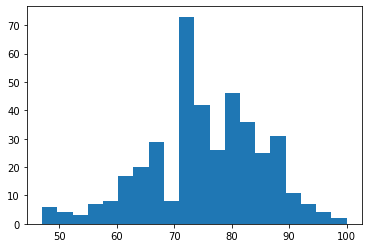

In [220]:
plt.hist(weather_df['Temp'], bins = 20);

In [221]:
weather_df.describe()

Temp        Wind
count  405.000000  405.000000
mean    75.333333    3.244444
std     10.017559    0.711991
min     47.000000    1.000000
25%     70.000000    3.000000
50%     75.000000    3.000000
75%     82.000000    3.000000
max    100.000000    5.000000

In [222]:
len(weather_df['Park'].unique())

31

In [223]:
len(weather_df['Date'].unique())

30

In [224]:
main_df = main_df.merge(weather_df, on = ['Date', 'Park'], how = 'left')

In [225]:
main_df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5537 entries, 0 to 5536
Data columns (total 103 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            5537 non-null   datetime64[ns]
 1   Name            5537 non-null   object        
 2   Team            5537 non-null   object        
 3   HR              5537 non-null   int64         
 4   PA              5537 non-null   float64       
 5   Events          5537 non-null   float64       
 6   EV              5537 non-null   float64       
 7   maxEV           5537 non-null   float64       
 8   LA              5537 non-null   float64       
 9   Barrels         5537 non-null   float64       
 10  Barrel%         5537 non-null   object        
 11  HardHit         5537 non-null   float64       
 12  HardHit%        5537 non-null   object        
 13  AVG             5537 non-null   float64       
 14  SLG             5537 non-null   float64       
 15  wOB

In [226]:
main_df.dropna(inplace=True)
main_df.reset_index(drop=True, inplace = True)

In [227]:
missing = pd.concat([main_df.isnull().sum(), 100 * main_df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

count    %
Date                0  0.0
SP_LD%              0  0.0
SP_HardHit          0  0.0
SP_maxEV            0  0.0
SP_Barrel%          0  0.0
SP_Barrels          0  0.0
SP_LA               0  0.0
SP_EV               0  0.0
SP_Hard%            0  0.0
SP_Med%             0  0.0
SP_Soft%            0  0.0
SP_FB%              0  0.0
SP_GB%              0  0.0
SP_Events           0  0.0
SP_FIP              0  0.0
SP_SIERA            0  0.0
SP_HR/FB            0  0.0
SP_BABIP            0  0.0
SP_BB%              0  0.0
SP_HR/9             0  0.0
SP_BB/9             0  0.0
SP_K%               0  0.0
SP_K/9              0  0.0
Pitcher             0  0.0
SP_HardHit%         0  0.0
BP_IP               0  0.0
Opp_Team            0  0.0
BP_Hard%            0  0.0
Temp                0  0.0
Pk_Fct_HR           0  0.0
Pk_Fct_Overall      0  0.0
BP_HardHit%         0  0.0
BP_HardHit          0  0.0
BP_maxEV            0  0.0
BP_Barrel%          0  0.0
BP_Barrels          0  0.0
BP_LA               0  0.0
BP_EV               0  0.0
BP_Med%             0  0.0
BP_K/9              0  0.0
BP_Soft%            0  0.0
BP_SIERA            0  0.0
BP_FB%              0  0.0
BP_LD%              0  0.0
BP_FIP              0  0.0
BP_HR/FB            0  0.0
BP_GB%              0  0.0
BP_BABIP            0  0.0
BP_HR/9             0  0.0
BP_BB/9             0  0.0
Park                0  0.0
Opp_Pitcher         0  0.0
Name                0  0.0
AVG                 0  0.0
LD%                 0  0.0
GB/FB               0  0.0
BABIP               0  0.0
ISO                 0  0.0
OPS                 0  0.0
OBP                 0  0.0
K%                  0  0.0
BB%                 0  0.0
wOBA                0  0.0
SLG                 0  0.0
HardHit%            0  0.0
FB%                 0  0.0
HardHit             0  0.0
Barrel%             0  0.0
Barrels             0  0.0
LA                  0  0.0
maxEV               0  0.0
EV                  0  0.0
Events              0  0.0
PA                  0  0.0
HR                  0  0.0
Team                0  0.0
GB%                 0  0.0
IFFB%               0  0.0
Opp_Hand            0  0.0
Soft%               0  0.0
OpenOU              0  0.0
Proj_Runs           0  0.0
Bats                0  0.0
DK_Pts              0  0.0
wRC+                0  0.0
Oppo%               0  0.0
Cent%               0  0.0
Pull%               0  0.0
Hard%               0  0.0
Med%                0  0.0
SwStr%              0  0.0
HR/FB               0  0.0
F-Strike%           0  0.0
Zone%               0  0.0
Contact%            0  0.0
Z-Contact%          0  0.0
O-Contact%          0  0.0
Swing%              0  0.0
Z-Swing%            0  0.0
O-Swing%            0  0.0
UBR                 0  0.0
BsR                 0  0.0
Wind                0  0.0

In [228]:
null_data = main_df[main_df.isnull().any(axis=1)]
null_data

Empty DataFrame
Columns: [Date, Name, Team, HR, PA, Events, EV, maxEV, LA, Barrels, Barrel%, HardHit, HardHit%, AVG, SLG, wOBA, BB%, K%, OBP, OPS, ISO, BABIP, GB/FB, LD%, GB%, FB%, IFFB%, HR/FB, BsR, UBR, O-Swing%, Z-Swing%, Swing%, O-Contact%, Z-Contact%, Contact%, Zone%, F-Strike%, SwStr%, Soft%, Med%, Hard%, Pull%, Cent%, Oppo%, wRC+, DK_Pts, Bats, Proj_Runs, OpenOU, Opp_Hand, Opp_Pitcher, Opp_Team, Park, Pitcher, SP_K/9, SP_K%, SP_BB/9, SP_HR/9, SP_BB%, SP_BABIP, SP_HR/FB, SP_SIERA, SP_FIP, SP_GB%, SP_LD%, SP_FB%, SP_Soft%, SP_Med%, SP_Hard%, SP_EV, SP_LA, SP_Barrels, SP_Barrel%, SP_maxEV, SP_HardHit, SP_HardHit%, SP_Events, BP_IP, BP_K/9, BP_BB/9, BP_HR/9, BP_BABIP, BP_GB%, BP_HR/FB, BP_FIP, BP_LD%, BP_FB%, BP_SIERA, BP_Soft%, BP_Med%, BP_Hard%, BP_EV, BP_LA, BP_Barrels, BP_Barrel%, BP_maxEV, BP_HardHit, BP_HardHit%, Pk_Fct_Overall, ...]
Index: []

[0 rows x 103 columns]

<a href='#contents'>Back to Table of Contents</a>

<a id='Fixing_Data_Types'></a>

# Fixing data types

In [229]:
main_df.select_dtypes(include = object)

Name Team Barrel% HardHit%    BB%     K%     LD%  \
0               Jared Walsh  LAA   13.2%    33.8%   8.2%  19.4%   25.0%   
1         Andrew Benintendi  KCR    6.3%    37.5%  10.6%  21.3%   21.0%   
2            Salvador Perez  KCR   13.9%    52.8%   3.8%  26.7%   26.4%   
3            Willie Calhoun  TEX    5.3%    42.1%   6.1%  14.3%   23.7%   
4         Jeimer Candelario  DET    5.2%    37.7%   8.0%  23.9%   28.6%   
5                Josh Rojas  ARI    6.7%    44.4%  12.3%  26.0%   22.2%   
6                 Alec Bohm  PHI   11.0%    52.1%   5.7%  25.5%   23.3%   
7              Nico Hoerner  CHC    3.8%    46.2%  17.9%  15.4%   19.2%   
8              Niko Goodrum  DET   15.4%    56.4%   7.7%  41.0%   25.6%   
9        Isiah Kiner-Falefa  TEX    4.3%    37.6%   3.3%  19.5%   20.7%   
10            Nolan Arenado  STL    8.0%    37.9%   7.0%  16.5%   19.5%   
11           Anthony Rendon  LAA    4.7%    53.5%  10.2%  16.9%   23.3%   
12         Michael Conforto  NYM    9.4%    34.0%   9.2%  25.3%   26.4%   
13             Trevor Story  COL   10.1%    39.2%   8.2%  20.0%   24.1%   
14         Paul Goldschmidt  STL    9.0%    50.0%   6.1%  25.4%   17.9%   
15             Mookie Betts  LAD    5.6%    38.0%  12.4%  16.2%   25.4%   
16                Yan Gomes  WSN    8.1%    35.1%   4.3%  14.9%   21.6%   
17               Mike Trout  LAA   20.8%    58.5%  16.1%  25.8%   24.5%   
18           Hunter Renfroe  BOS    6.5%    41.3%   8.3%  27.8%   21.7%   
19               Mark Canha  OAK   12.7%    45.1%  13.2%  23.1%   19.7%   
20               Luis Urias  MIL   12.2%    46.9%  17.1%  23.2%   22.9%   
21        Michael A. Taylor  KCR    8.3%    36.7%   8.0%  23.0%   27.1%   
22            J.P. Crawford  SEA    0.0%    27.4%   9.0%  18.0%   19.7%   
23          Yasmani Grandal  CHW    9.5%    52.4%  23.3%  19.2%   12.2%   
24            Jesus Aguilar  MIA    6.4%    34.6%  14.8%  13.0%   12.8%   
25            Austin Hedges  CLE   14.3%    28.6%   7.7%  38.5%   15.4%   
26              Colin Moran  PIT   10.9%    37.5%   8.9%  27.7%   33.3%   
27                Dom Nunez  COL   17.2%    37.9%  11.5%  41.0%   27.6%   
28              Tommy Edman  STL    1.0%    38.0%   5.8%   9.9%   19.0%   
29            J.D. Martinez  BOS   15.1%    47.9%  12.5%  21.4%   15.1%   
30               Matt Beaty  LAD    0.0%    25.0%  20.0%  20.0%   31.3%   
31            Josh Harrison  WSN    2.0%    27.5%   7.5%  11.9%   22.0%   
32              Aaron Judge  NYY   19.7%    59.0%  14.9%  24.8%   27.9%   
33              Travis Shaw  MIL    9.5%    39.7%   7.0%  28.0%   21.0%   
34             Raimel Tapia  COL    2.5%    29.6%   7.9%  11.9%   18.5%   
35           Ramon Laureano  OAK   12.9%    44.3%   6.5%  25.9%   27.1%   
36              Kyle Farmer  CIN    8.1%    35.1%   7.1%  19.6%   24.3%   
37             Tyler Naquin  CIN   19.1%    59.6%  10.1%  26.6%    8.7%   
38          Gregory Polanco  PIT   12.2%    49.0%  11.0%  29.3%   22.4%   
39                Josh Bell  WSN   12.2%    53.7%   7.8%  26.6%   17.1%   
40             Chad Wallach  MIA    4.2%    37.5%   2.4%  38.1%   20.8%   
41              Josh Naylor  CLE   10.0%    40.0%   3.7%  21.0%   18.6%   
42              Pete Alonso  NYM   21.8%    58.2%   8.8%  29.7%   18.2%   
43           Bryan Reynolds  PIT    8.6%    31.4%  12.8%  22.0%   31.9%   
44         Charlie Blackmon  COL    7.6%    45.5%  12.6%  14.7%   21.2%   
45               Tommy Pham  SDP   13.0%    50.0%  14.3%  19.0%   18.5%   
46           Avisail Garcia  MIL   11.7%    55.0%  11.1%  27.3%   20.0%   
47              Nelson Cruz  MIN   20.6%    58.8%   6.6%  16.5%   14.7%   
48            Manny Machado  SDP    9.5%    58.3%  12.5%  17.5%   15.7%   
49             Tim Anderson  CHW    8.0%    34.0%   4.1%  28.4%   22.0%   
50           Mauricio Dubon  SFG    4.9%    34.1%   5.4%  21.4%   32.5%   
51             D.J. Stewart  BAL    4.5%    31.8%  13.0%  23.2%   15.9%   
52           Alex Kirilloff  MIN   28.0%    64.0

In [230]:
main_df_obj = main_df.select_dtypes(include=['object', 'datetime64[ns]'])

In [231]:
main_df_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5521 entries, 0 to 5520
Data columns (total 53 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5521 non-null   datetime64[ns]
 1   Name         5521 non-null   object        
 2   Team         5521 non-null   object        
 3   Barrel%      5521 non-null   object        
 4   HardHit%     5521 non-null   object        
 5   BB%          5521 non-null   object        
 6   K%           5521 non-null   object        
 7   LD%          5521 non-null   object        
 8   GB%          5521 non-null   object        
 9   FB%          5521 non-null   object        
 10  IFFB%        5521 non-null   object        
 11  HR/FB        5521 non-null   object        
 12  O-Swing%     5521 non-null   object        
 13  Z-Swing%     5521 non-null   object        
 14  Swing%       5521 non-null   object        
 15  O-Contact%   5521 non-null   object        
 16  Z-Cont

# Separating non-number objects

We'll probably want these six columns to be the first ones in the dataframe.

In [232]:
non_num_obj = main_df_obj.iloc[:, [0, 1, 2, 27, 28, 29, 30, 31, 32]]

In [233]:
non_num_obj.head()

Date               Name Team Bats Opp_Hand  Opp_Pitcher Opp_Team Park  \
0 2021-05-01        Jared Walsh  LAA    L        R     LNEWSOME      SEA  SEA   
1 2021-05-01  Andrew Benintendi  KCR    L        R    MSHOEMAKE      MIN  MIN   
2 2021-05-01     Salvador Perez  KCR    R        R    MSHOEMAKE      MIN  MIN   
3 2021-05-01     Willie Calhoun  TEX    L        L  ERODRIGUE-L      BOS  TEX   
4 2021-05-01  Jeimer Candelario  DET    S        R     JTAILLON      NYY  NYY   

             Pitcher  
0       Ljay Newsome  
1     Matt Shoemaker  
2     Matt Shoemaker  
3  Eduardo Rodriguez  
4    Jameson Taillon

In [234]:
main_df_obj = main_df_obj.drop(['Date', 'Name', 'Team', 'Bats', 'Opp_Hand', 'Opp_Pitcher', 'Opp_Team', 'Park', 'Pitcher'], 1)

In [235]:
main_df_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5521 entries, 0 to 5520
Data columns (total 44 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Barrel%      5521 non-null   object
 1   HardHit%     5521 non-null   object
 2   BB%          5521 non-null   object
 3   K%           5521 non-null   object
 4   LD%          5521 non-null   object
 5   GB%          5521 non-null   object
 6   FB%          5521 non-null   object
 7   IFFB%        5521 non-null   object
 8   HR/FB        5521 non-null   object
 9   O-Swing%     5521 non-null   object
 10  Z-Swing%     5521 non-null   object
 11  Swing%       5521 non-null   object
 12  O-Contact%   5521 non-null   object
 13  Z-Contact%   5521 non-null   object
 14  Contact%     5521 non-null   object
 15  Zone%        5521 non-null   object
 16  F-Strike%    5521 non-null   object
 17  SwStr%       5521 non-null   object
 18  Soft%        5521 non-null   object
 19  Med%         5521 non-null 

In [236]:
main_df_nums = main_df.select_dtypes(include=['int64', 'float'])

In [237]:
main_df_nums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5521 entries, 0 to 5520
Data columns (total 50 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HR              5521 non-null   int64  
 1   PA              5521 non-null   float64
 2   Events          5521 non-null   float64
 3   EV              5521 non-null   float64
 4   maxEV           5521 non-null   float64
 5   LA              5521 non-null   float64
 6   Barrels         5521 non-null   float64
 7   HardHit         5521 non-null   float64
 8   AVG             5521 non-null   float64
 9   SLG             5521 non-null   float64
 10  wOBA            5521 non-null   float64
 11  OBP             5521 non-null   float64
 12  OPS             5521 non-null   float64
 13  ISO             5521 non-null   float64
 14  BABIP           5521 non-null   float64
 15  GB/FB           5521 non-null   float64
 16  BsR             5521 non-null   float64
 17  UBR             5521 non-null   f

In [238]:
main_df_nums.describe()

HR           PA       Events           EV        maxEV  \
count  5521.000000  5521.000000  5521.000000  5521.000000  5521.000000   
mean      0.141279    81.943307    55.626517    89.114146   108.853287   
std       0.378259    31.019481    23.114945     3.133489     3.923043   
min       0.000000     1.000000     1.000000    65.600000    71.200000   
25%       0.000000    62.000000    40.000000    87.300000   106.700000   
50%       0.000000    89.000000    59.000000    89.200000   109.000000   
75%       0.000000   107.000000    73.000000    91.000000   111.300000   
max       3.000000   144.000000   123.000000   107.800000   122.200000   

                LA      Barrels      HardHit          AVG          SLG  ...  \
count  5521.000000  5521.000000  5521.000000  5521.000000  5521.000000  ...   
mean     12.750299     4.771237    22.399022     0.250592     0.427206  ...   
std       6.572027     3.574012    10.913958     0.067299     0.142241  ...   
min     -40.300000     0.000000     0.000000     0.000000     0.000000  ...   
25%       8.600000     2.000000    14.000000     0.213000     0.338000  ...   
50%      12.900000     4.000000    23.000000     0.252000     0.423000  ...   
75%      16.900000     7.000000    30.000000     0.289000     0.506000  ...   
max      68.000000    25.000000    54.000000     1.000000     2.000000  ...   

          BP_SIERA        BP_EV        BP_LA   BP_Barrels     BP_maxEV  \
count  5521.000000  5521.000000  5521.000000  5521.000000  5521.000000   
mean      3.991639    88.546948    12.609672    20.917769   113.600489   
std       0.403163     1.152545     2.566395     5.949039     2.200126   
min       2.990000    85.000000     3.100000     5.000000   109.000000   
25%       3.700000    87.800000    10.900000    17.000000   111.900000   
50%       3.990000    88.700000    12.700000    20.000000   113.500000   
75%       4.270000    89.300000    14.300000    25.000000   115.100000   
max       5.120000    92.600000    20.200000    39.000000   120.200000   

        BP_HardHit  Pk_Fct_Overall    Pk_Fct_HR         Temp         Wind  
count  5521.000000     5521.000000  5521.000000  5521.000000  5521.000000  
mean    104.449194       99.839522    99.589748    75.517479     3.256294  
std      18.858070        3.869610    14.371418     9.851861     0.722609  
min      51.000000       93.000000    68.000000    47.000000     1.000000  
25%      91.000000       97.000000    89.000000    70.000000     3.000000  
50%     103.000000      100.000000    98.000000    75.000000     3.000000  
75%     117.000000      102.000000   107.000000    82.000000     4.000000  
max     158.000000      110.000000   148.000000   100.000000     5.000000  

[8 rows x 50 columns]

In [239]:
main_df_obj.head()

Barrel% HardHit%    BB%     K%    LD%    GB%    FB%  IFFB%  HR/FB O-Swing%  \
0   13.2%    33.8%   8.2%  19.4%  25.0%  36.8%  38.2%  23.1%  23.1%    34.8%   
1    6.3%    37.5%  10.6%  21.3%  21.0%  46.8%  32.3%   5.0%  15.0%    29.6%   
2   13.9%    52.8%   3.8%  26.7%  26.4%  37.5%  36.1%  11.5%  23.1%    50.2%   
3    5.3%    42.1%   6.1%  14.3%  23.7%  44.7%  31.6%  33.3%  16.7%    30.5%   
4    5.2%    37.7%   8.0%  23.9%  28.6%  35.1%  36.4%   3.6%   7.1%    36.1%   

   ... SP_HardHit% BP_GB% BP_HR/FB BP_LD% BP_FB% BP_Soft% BP_Med% BP_Hard%  \
0  ...       36.4%  49.0%     5.6%  16.0%  35.0%    13.2%   54.5%    32.3%   
1  ...       37.9%  42.7%    16.2%  23.6%  33.6%    19.0%   50.2%    30.8%   
2  ...       37.9%  42.7%    16.2%  23.6%  33.6%    19.0%   50.2%    30.8%   
3  ...       36.1%  46.5%     8.8%  20.3%  33.2%    20.0%   52.2%    27.8%   
4  ...       38.0%  42.0%     8.3%  18.5%  39.5%    22.4%   53.7%    24.0%   

  BP_Barrel% BP_HardHit%  
0       5.0%       36.0%  
1      11.3%       48.4%  
2      11.3%       48.4%  
3       6.1%       42.4%  
4       5.3%       29.6%  

[5 rows x 44 columns]

# Removing percentage sign and changing strings to numeric type

In [240]:
main_df_obj_cols = list(main_df_obj.columns)

In [241]:
main_df_obj[main_df_obj_cols] = main_df_obj[main_df_obj_cols].replace({'\%':''}, regex = True)

In [242]:
main_df_obj.head()

Barrel% HardHit%   BB%    K%   LD%   GB%   FB% IFFB% HR/FB O-Swing%  ...  \
0    13.2     33.8   8.2  19.4  25.0  36.8  38.2  23.1  23.1     34.8  ...   
1     6.3     37.5  10.6  21.3  21.0  46.8  32.3   5.0  15.0     29.6  ...   
2    13.9     52.8   3.8  26.7  26.4  37.5  36.1  11.5  23.1     50.2  ...   
3     5.3     42.1   6.1  14.3  23.7  44.7  31.6  33.3  16.7     30.5  ...   
4     5.2     37.7   8.0  23.9  28.6  35.1  36.4   3.6   7.1     36.1  ...   

  SP_HardHit% BP_GB% BP_HR/FB BP_LD% BP_FB% BP_Soft% BP_Med% BP_Hard%  \
0        36.4   49.0      5.6   16.0   35.0     13.2    54.5     32.3   
1        37.9   42.7     16.2   23.6   33.6     19.0    50.2     30.8   
2        37.9   42.7     16.2   23.6   33.6     19.0    50.2     30.8   
3        36.1   46.5      8.8   20.3   33.2     20.0    52.2     27.8   
4        38.0   42.0      8.3   18.5   39.5     22.4    53.7     24.0   

  BP_Barrel% BP_HardHit%  
0        5.0        36.0  
1       11.3        48.4  
2       11.3        48.4  
3        6.1        42.4  
4        5.3        29.6  

[5 rows x 44 columns]

In [243]:
def change_to_num(cols, df):
    for col in cols:
        df[col] = pd.to_numeric(df[col])  

In [244]:
change_to_num(main_df_obj_cols, main_df_obj)

In [245]:
main_df_obj.head()

Barrel%  HardHit%   BB%    K%   LD%   GB%   FB%  IFFB%  HR/FB  O-Swing%  \
0     13.2      33.8   8.2  19.4  25.0  36.8  38.2   23.1   23.1      34.8   
1      6.3      37.5  10.6  21.3  21.0  46.8  32.3    5.0   15.0      29.6   
2     13.9      52.8   3.8  26.7  26.4  37.5  36.1   11.5   23.1      50.2   
3      5.3      42.1   6.1  14.3  23.7  44.7  31.6   33.3   16.7      30.5   
4      5.2      37.7   8.0  23.9  28.6  35.1  36.4    3.6    7.1      36.1   

   ...  SP_HardHit%  BP_GB%  BP_HR/FB  BP_LD%  BP_FB%  BP_Soft%  BP_Med%  \
0  ...         36.4    49.0       5.6    16.0    35.0      13.2     54.5   
1  ...         37.9    42.7      16.2    23.6    33.6      19.0     50.2   
2  ...         37.9    42.7      16.2    23.6    33.6      19.0     50.2   
3  ...         36.1    46.5       8.8    20.3    33.2      20.0     52.2   
4  ...         38.0    42.0       8.3    18.5    39.5      22.4     53.7   

   BP_Hard%  BP_Barrel%  BP_HardHit%  
0      32.3         5.0         36.0  
1      30.8        11.3         48.4  
2      30.8        11.3         48.4  
3      27.8         6.1         42.4  
4      24.0         5.3         29.6  

[5 rows x 44 columns]

In [246]:
main_df = pd.concat([non_num_obj, main_df_nums, main_df_obj], axis = 1)

In [247]:
main_df.head()

Date               Name Team Bats Opp_Hand  Opp_Pitcher Opp_Team Park  \
0 2021-05-01        Jared Walsh  LAA    L        R     LNEWSOME      SEA  SEA   
1 2021-05-01  Andrew Benintendi  KCR    L        R    MSHOEMAKE      MIN  MIN   
2 2021-05-01     Salvador Perez  KCR    R        R    MSHOEMAKE      MIN  MIN   
3 2021-05-01     Willie Calhoun  TEX    L        L  ERODRIGUE-L      BOS  TEX   
4 2021-05-01  Jeimer Candelario  DET    S        R     JTAILLON      NYY  NYY   

             Pitcher  HR  ...  SP_HardHit%  BP_GB%  BP_HR/FB  BP_LD%  BP_FB%  \
0       Ljay Newsome   2  ...         36.4    49.0       5.6    16.0    35.0   
1     Matt Shoemaker   2  ...         37.9    42.7      16.2    23.6    33.6   
2     Matt Shoemaker   1  ...         37.9    42.7      16.2    23.6    33.6   
3  Eduardo Rodriguez   1  ...         36.1    46.5       8.8    20.3    33.2   
4    Jameson Taillon   1  ...         38.0    42.0       8.3    18.5    39.5   

   BP_Soft%  BP_Med%  BP_Hard%  BP_Barrel%  BP_HardHit%  
0      13.2     54.5      32.3         5.0         36.0  
1      19.0     50.2      30.8        11.3         48.4  
2      19.0     50.2      30.8        11.3         48.4  
3      20.0     52.2      27.8         6.1         42.4  
4      22.4     53.7      24.0         5.3         29.6  

[5 rows x 103 columns]

In [248]:
main_df.tail()

Date          Name Team Bats Opp_Hand Opp_Pitcher Opp_Team Park  \
5516 2021-08-29  Yuli Gurriel  HOU    R        L    THEARN-L      TEX  TEX   
5517 2021-08-29  Brent Rooker  MIN    R        L    AASHBY-L      MIL  MIN   
5518 2021-08-29  Abraham Toro  SEA    S        R     BSINGER      KCR  SEA   
5519 2021-08-29   Cal Raleigh  SEA    S        R     BSINGER      KCR  SEA   
5520 2021-08-29  Ryan Jeffers  MIN    R        L    AASHBY-L      MIL  MIN   

           Pitcher  HR  ...  SP_HardHit%  BP_GB%  BP_HR/FB  BP_LD%  BP_FB%  \
5516  Taylor Hearn   0  ...         27.4    38.0       8.7    19.0    43.0   
5517   Aaron Ashby   0  ...         22.7    40.0      12.8    21.1    38.9   
5518  Brady Singer   0  ...         39.2    38.4       6.5    23.1    38.4   
5519  Brady Singer   0  ...         39.2    38.4       6.5    23.1    38.4   
5520   Aaron Ashby   0  ...         22.7    40.0      12.8    21.1    38.9   

      BP_Soft%  BP_Med%  BP_Hard%  BP_Barrel%  BP_HardHit%  
5516      15.0     52.9      32.1         6.4         34.6  
5517      16.8     51.6      31.6         7.0         34.4  
5518      13.8     49.3      36.9         8.1         41.0  
5519      13.8     49.3      36.9         8.1         41.0  
5520      16.8     51.6      31.6         7.0         34.4  

[5 rows x 103 columns]

In [249]:
null_data = main_df[main_df.isnull().any(axis=1)]

In [250]:
null_data

Empty DataFrame
Columns: [Date, Name, Team, Bats, Opp_Hand, Opp_Pitcher, Opp_Team, Park, Pitcher, HR, PA, Events, EV, maxEV, LA, Barrels, HardHit, AVG, SLG, wOBA, OBP, OPS, ISO, BABIP, GB/FB, BsR, UBR, wRC+, DK_Pts, Proj_Runs, OpenOU, SP_K/9, SP_BB/9, SP_HR/9, SP_BABIP, SP_SIERA, SP_FIP, SP_EV, SP_LA, SP_Barrels, SP_maxEV, SP_HardHit, SP_Events, BP_IP, BP_K/9, BP_BB/9, BP_HR/9, BP_BABIP, BP_FIP, BP_SIERA, BP_EV, BP_LA, BP_Barrels, BP_maxEV, BP_HardHit, Pk_Fct_Overall, Pk_Fct_HR, Temp, Wind, Barrel%, HardHit%, BB%, K%, LD%, GB%, FB%, IFFB%, HR/FB, O-Swing%, Z-Swing%, Swing%, O-Contact%, Z-Contact%, Contact%, Zone%, F-Strike%, SwStr%, Soft%, Med%, Hard%, Pull%, Cent%, Oppo%, SP_K%, SP_BB%, SP_HR/FB, SP_GB%, SP_LD%, SP_FB%, SP_Soft%, SP_Med%, SP_Hard%, SP_Barrel%, SP_HardHit%, BP_GB%, BP_HR/FB, BP_LD%, BP_FB%, BP_Soft%, BP_Med%, ...]
Index: []

[0 rows x 103 columns]

In [251]:
missing = pd.concat([main_df.isnull().sum(), 100 * main_df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

count    %
Date                0  0.0
FB%                 0  0.0
F-Strike%           0  0.0
Zone%               0  0.0
Contact%            0  0.0
Z-Contact%          0  0.0
O-Contact%          0  0.0
Swing%              0  0.0
Z-Swing%            0  0.0
O-Swing%            0  0.0
HR/FB               0  0.0
IFFB%               0  0.0
GB%                 0  0.0
Soft%               0  0.0
LD%                 0  0.0
K%                  0  0.0
BB%                 0  0.0
HardHit%            0  0.0
Barrel%             0  0.0
Wind                0  0.0
Temp                0  0.0
Pk_Fct_HR           0  0.0
Pk_Fct_Overall      0  0.0
BP_HardHit          0  0.0
SwStr%              0  0.0
Med%                0  0.0
BP_Barrels          0  0.0
SP_Hard%            0  0.0
BP_Barrel%          0  0.0
BP_Hard%            0  0.0
BP_Med%             0  0.0
BP_Soft%            0  0.0
BP_FB%              0  0.0
BP_LD%              0  0.0
BP_HR/FB            0  0.0
BP_GB%              0  0.0
SP_HardHit%         0  0.0
SP_Barrel%          0  0.0
SP_Med%             0  0.0
Hard%               0  0.0
SP_Soft%            0  0.0
SP_FB%              0  0.0
SP_LD%              0  0.0
SP_GB%              0  0.0
SP_HR/FB            0  0.0
SP_BB%              0  0.0
SP_K%               0  0.0
Oppo%               0  0.0
Cent%               0  0.0
Pull%               0  0.0
BP_maxEV            0  0.0
BP_LA               0  0.0
Name                0  0.0
maxEV               0  0.0
BABIP               0  0.0
ISO                 0  0.0
OPS                 0  0.0
OBP                 0  0.0
wOBA                0  0.0
SLG                 0  0.0
AVG                 0  0.0
HardHit             0  0.0
Barrels             0  0.0
LA                  0  0.0
EV                  0  0.0
BsR                 0  0.0
Events              0  0.0
PA                  0  0.0
HR                  0  0.0
Pitcher             0  0.0
Park                0  0.0
Opp_Team            0  0.0
Opp_Pitcher         0  0.0
Opp_Hand            0  0.0
Bats                0  0.0
Team                0  0.0
GB/FB               0  0.0
UBR                 0  0.0
BP_EV               0  0.0
SP_Barrels          0  0.0
BP_SIERA            0  0.0
BP_FIP              0  0.0
BP_BABIP            0  0.0
BP_HR/9             0  0.0
BP_BB/9             0  0.0
BP_K/9              0  0.0
BP_IP               0  0.0
SP_Events           0  0.0
SP_HardHit          0  0.0
SP_maxEV            0  0.0
SP_LA               0  0.0
wRC+                0  0.0
SP_EV               0  0.0
SP_FIP              0  0.0
SP_SIERA            0  0.0
SP_BABIP            0  0.0
SP_HR/9             0  0.0
SP_BB/9             0  0.0
SP_K/9              0  0.0
OpenOU              0  0.0
Proj_Runs           0  0.0
DK_Pts              0  0.0
BP_HardHit%         0  0.0

In [252]:
print(all(main_df))

True


In [253]:
main_df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5521 entries, 0 to 5520
Data columns (total 103 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            5521 non-null   datetime64[ns]
 1   Name            5521 non-null   object        
 2   Team            5521 non-null   object        
 3   Bats            5521 non-null   object        
 4   Opp_Hand        5521 non-null   object        
 5   Opp_Pitcher     5521 non-null   object        
 6   Opp_Team        5521 non-null   object        
 7   Park            5521 non-null   object        
 8   Pitcher         5521 non-null   object        
 9   HR              5521 non-null   int64         
 10  PA              5521 non-null   float64       
 11  Events          5521 non-null   float64       
 12  EV              5521 non-null   float64       
 13  maxEV           5521 non-null   float64       
 14  LA              5521 non-null   float64       
 15  Bar

In [254]:
main_df.describe().T

count        mean        std         min      25%        50%  \
HR              5521.0    0.141279   0.378259    0.000000    0.000    0.00000   
PA              5521.0   81.943307  31.019481    1.000000   62.000   89.00000   
Events          5521.0   55.626517  23.114945    1.000000   40.000   59.00000   
EV              5521.0   89.114146   3.133489   65.600000   87.300   89.20000   
maxEV           5521.0  108.853287   3.923043   71.200000  106.700  109.00000   
LA              5521.0   12.750299   6.572027  -40.300000    8.600   12.90000   
Barrels         5521.0    4.771237   3.574012    0.000000    2.000    4.00000   
HardHit         5521.0   22.399022  10.913958    0.000000   14.000   23.00000   
AVG             5521.0    0.250592   0.067299    0.000000    0.213    0.25200   
SLG             5521.0    0.427206   0.142241    0.000000    0.338    0.42300   
wOBA            5521.0    0.323442   0.077418    0.000000    0.279    0.32400   
OBP             5521.0    0.324253   0.070819    0.000000    0.284    0.32700   
OPS             5521.0    0.751445   0.197900    0.000000    0.635    0.75100   
ISO             5521.0    0.176615   0.100870    0.000000    0.110    0.16700   
BABIP           5521.0    0.296349   0.086294    0.000000    0.250    0.29500   
GB/FB           5521.0    1.338134   0.804300    0.000000    0.850    1.16000   
BsR             5521.0    0.017569   0.623283   -2.100000   -0.400    0.00000   
UBR             5521.0    0.011574   0.366087   -1.900000   -0.200    0.00000   
wRC+            5521.0  103.113566  50.917214 -100.000000   74.000  104.00000   
DK_Pts          5521.0    7.320413   7.321798    0.000000    2.000    5.00000   
Proj_Runs       5521.0    4.383883   0.828437    1.746875    3.825    4.33125   
OpenOU          5521.0    8.766528   0.961398    6.000000    8.000    9.00000   
SP_K/9          5521.0    8.715926   2.392872    2.450000    7.040    8.78000   
SP_BB/9         5521.0    3.027343   1.685339    0.000000    1.980    2.86000   
SP_HR/9         5521.0    1.284352   0.863796    0.000000    0.670    1.14000   
SP_BABIP        5521.0    0.287695   0.064421    0.077000    0.245    0.28600   
SP_SIERA        5521.0    4.246080   0.896550    1.230000    3.700    4.23000   
SP_FIP          5521.0    4.231873   1.500782   -0.070000    3.250    4.03000   
SP_EV           5521.0   88.882413   2.423463   75.900000   87.600   89.00000   
SP_LA           5521.0   12.325901   6.501754   -7.900000    8.100   12.50000   
SP_Barrels      5521.0    5.221518   2.865211    0.000000    3.000    5.00000   
SP_maxEV        5521.0  111.062308   3.005056   94.400000  109.200  111.00000   
SP_HardHit      5521.0   25.481978   9.767630    0.000000   19.000   26.00000   
SP_Events       5521.0   65.692447  22.760209    3.000000   52.000   70.00000   
BP_IP           5521.0   98.965423  12.463829   65.200000   90.100   98.00000   
BP_K/9          5521.0    9.410424   1.079505    6.210000    8.620    9.43000   
BP_BB/9         5521.0    3.838296   0.793709    1.780000    3.300    3.77000   
BP_HR/9         5521.0    1.170545   0.386994    0.110000    0.900    1.17000   
BP_BABIP        5521.0    0.288495   0.029969    0.193000    0.270    0.29000   
BP_FIP          5521.0    4.215936   0.682815    2.580000    3.720    4.21000   
BP_SIERA        5521.0    3.991639   0.403163    2.990000    3.700    3.99000   
BP_EV           5521.0   88.546948   1.152545   85.000000   87.800   88.70000   
BP_LA           5521.0   12.609672   2.566395    3.100000   10.900   12.70000   
BP_Barrels      5521.0   20.917769   5.949039    5.000000   17.000   20.00000   
BP_maxEV        5521.0  113.600489   2.200126  109.000000  111.900  113.50000   
BP_HardHit      5521.0  104.449194  18.858070   51.000000   91.000  103.00000   
Pk_Fct_Overall  5521.0   99.839522   3.869610   93.000000   97.000  100.00000   
Pk_Fct_HR       5521.0   99.589748  14.371418   68.000000   89.000   98.00000   
Temp            5521.0   75.517479   9.851861   

In [255]:
#Checking value counts for each of our 30 dates. Only 67 on Aug. 9 but that was a Monday and schedules can be light on Mondays.
main_df['Date'].value_counts()

2021-07-24    232
2021-08-21    230
2021-06-22    226
2021-06-06    224
2021-06-18    216
2021-05-25    216
2021-05-05    213
2021-05-01    210
2021-08-17    207
2021-07-04    203
2021-07-28    199
2021-07-20    197
2021-07-16    195
2021-05-21    195
2021-08-29    195
2021-08-13    190
2021-06-14    189
2021-05-09    183
2021-08-05    177
2021-06-30    177
2021-05-13    176
2021-06-26    176
2021-08-01    175
2021-08-25    164
2021-05-29    147
2021-06-02    142
2021-06-10    139
2021-05-17    132
2021-07-08    129
2021-08-09     67
Name: Date, dtype: int64

In [256]:
#Checking Name column. No name should appear more than 30 times.
main_df['Name'].value_counts().max()

27

In [257]:
#Making sure we have three values for Bats column.
main_df['Bats'].value_counts()

R    3188
L    1671
S     662
Name: Bats, dtype: int64

In [258]:
#Checking Opp_Hand column. 
#Two values and it sounds about right that there are more than twice as many righties as lefties.
main_df['Opp_Hand'].value_counts()

R    3741
L    1780
Name: Opp_Hand, dtype: int64

In [259]:
#Checking Park column
#We're looking at value counts and unique here. 
#TOR and BUF are the two lowest value counts, as expected, 
#because we dropped a lot of TOR home games and the Blue Jays only played in BUF for part of the year. 
#We also see that there are 31 different values, 30 teams plus we added BUF.
main_df['Park'].value_counts()

SEA    244
NYY    231
MIN    230
WSN    220
KCR    208
CIN    204
OAK    201
COL    198
HOU    197
CHW    196
BOS    196
STL    195
TEX    194
SDP    193
ARI    191
MIA    189
LAA    181
ATL    178
TBR    171
DET    171
MIL    170
PIT    164
NYM    160
PHI    160
SFG    152
CLE    147
CHC    146
BAL    142
LAD    130
BUF    101
TOR     61
Name: Park, dtype: int64

In [260]:
len(main_df['Park'].unique())

31

<a href='#contents'>Back to Table of Contents</a>

<a id='Categorical'></a>

# Creating categorical variables for handedness matchups
Four possible values:<br>
Righty vs righty (RvR)<br>
Switch-and-lefty vs. righty (SLvR)<br>
Lefty vs lefty (LvL)<br>
Switch-and-righty vs. lefty (SRvL)<br>
We assume switch-hitters will opt to bat against their opposite hand

In [261]:
conds = [(main_df['Bats'] == 'R') & (main_df['Opp_Hand'] == 'R'), \
         (main_df['Bats'] != 'R') & (main_df['Opp_Hand'] == 'R'),\
        (main_df['Bats'] == 'L') & (main_df['Opp_Hand'] == 'L'),\
        (main_df['Bats'] != 'L') & (main_df['Opp_Hand'] == 'L')]
choices = ['RvR', 'SLvR', 'LvL', 'SRvL']

In [262]:
main_df['Hnd_Mtch'] = np.select(conds, choices)

## Dummy variables for our categorical variables

In [263]:
main_df = pd.get_dummies(main_df, columns = ['Hnd_Mtch'], drop_first = False, prefix = 'HM_')

In [264]:
main_df.head()

Date               Name Team Bats Opp_Hand  Opp_Pitcher Opp_Team Park  \
0 2021-05-01        Jared Walsh  LAA    L        R     LNEWSOME      SEA  SEA   
1 2021-05-01  Andrew Benintendi  KCR    L        R    MSHOEMAKE      MIN  MIN   
2 2021-05-01     Salvador Perez  KCR    R        R    MSHOEMAKE      MIN  MIN   
3 2021-05-01     Willie Calhoun  TEX    L        L  ERODRIGUE-L      BOS  TEX   
4 2021-05-01  Jeimer Candelario  DET    S        R     JTAILLON      NYY  NYY   

             Pitcher  HR  ...  BP_FB%  BP_Soft%  BP_Med%  BP_Hard%  \
0       Ljay Newsome   2  ...    35.0      13.2     54.5      32.3   
1     Matt Shoemaker   2  ...    33.6      19.0     50.2      30.8   
2     Matt Shoemaker   1  ...    33.6      19.0     50.2      30.8   
3  Eduardo Rodriguez   1  ...    33.2      20.0     52.2      27.8   
4    Jameson Taillon   1  ...    39.5      22.4     53.7      24.0   

   BP_Barrel%  BP_HardHit%  HM__LvL  HM__RvR  HM__SLvR  HM__SRvL  
0         5.0         36.0        0        0         1         0  
1        11.3         48.4        0        0         1         0  
2        11.3         48.4        0        1         0         0  
3         6.1         42.4        1        0         0         0  
4         5.3         29.6        0        0         1         0  

[5 rows x 107 columns]

In [265]:
#Dropping columns we don't need now that we have handedness matchups, park factors and pitcher information
main_df.drop(columns = ['Bats', 'Opp_Hand', 'Opp_Pitcher', 'Opp_Team', 'Park', 'Pitcher', 'HR'], inplace = True)

In [266]:
main_df.shape

(5521, 100)

<a id='Histogram'></a>

# Histogram time
We need a new set of histograms since we added so many features. Some scrolling is required because there are 121 features.

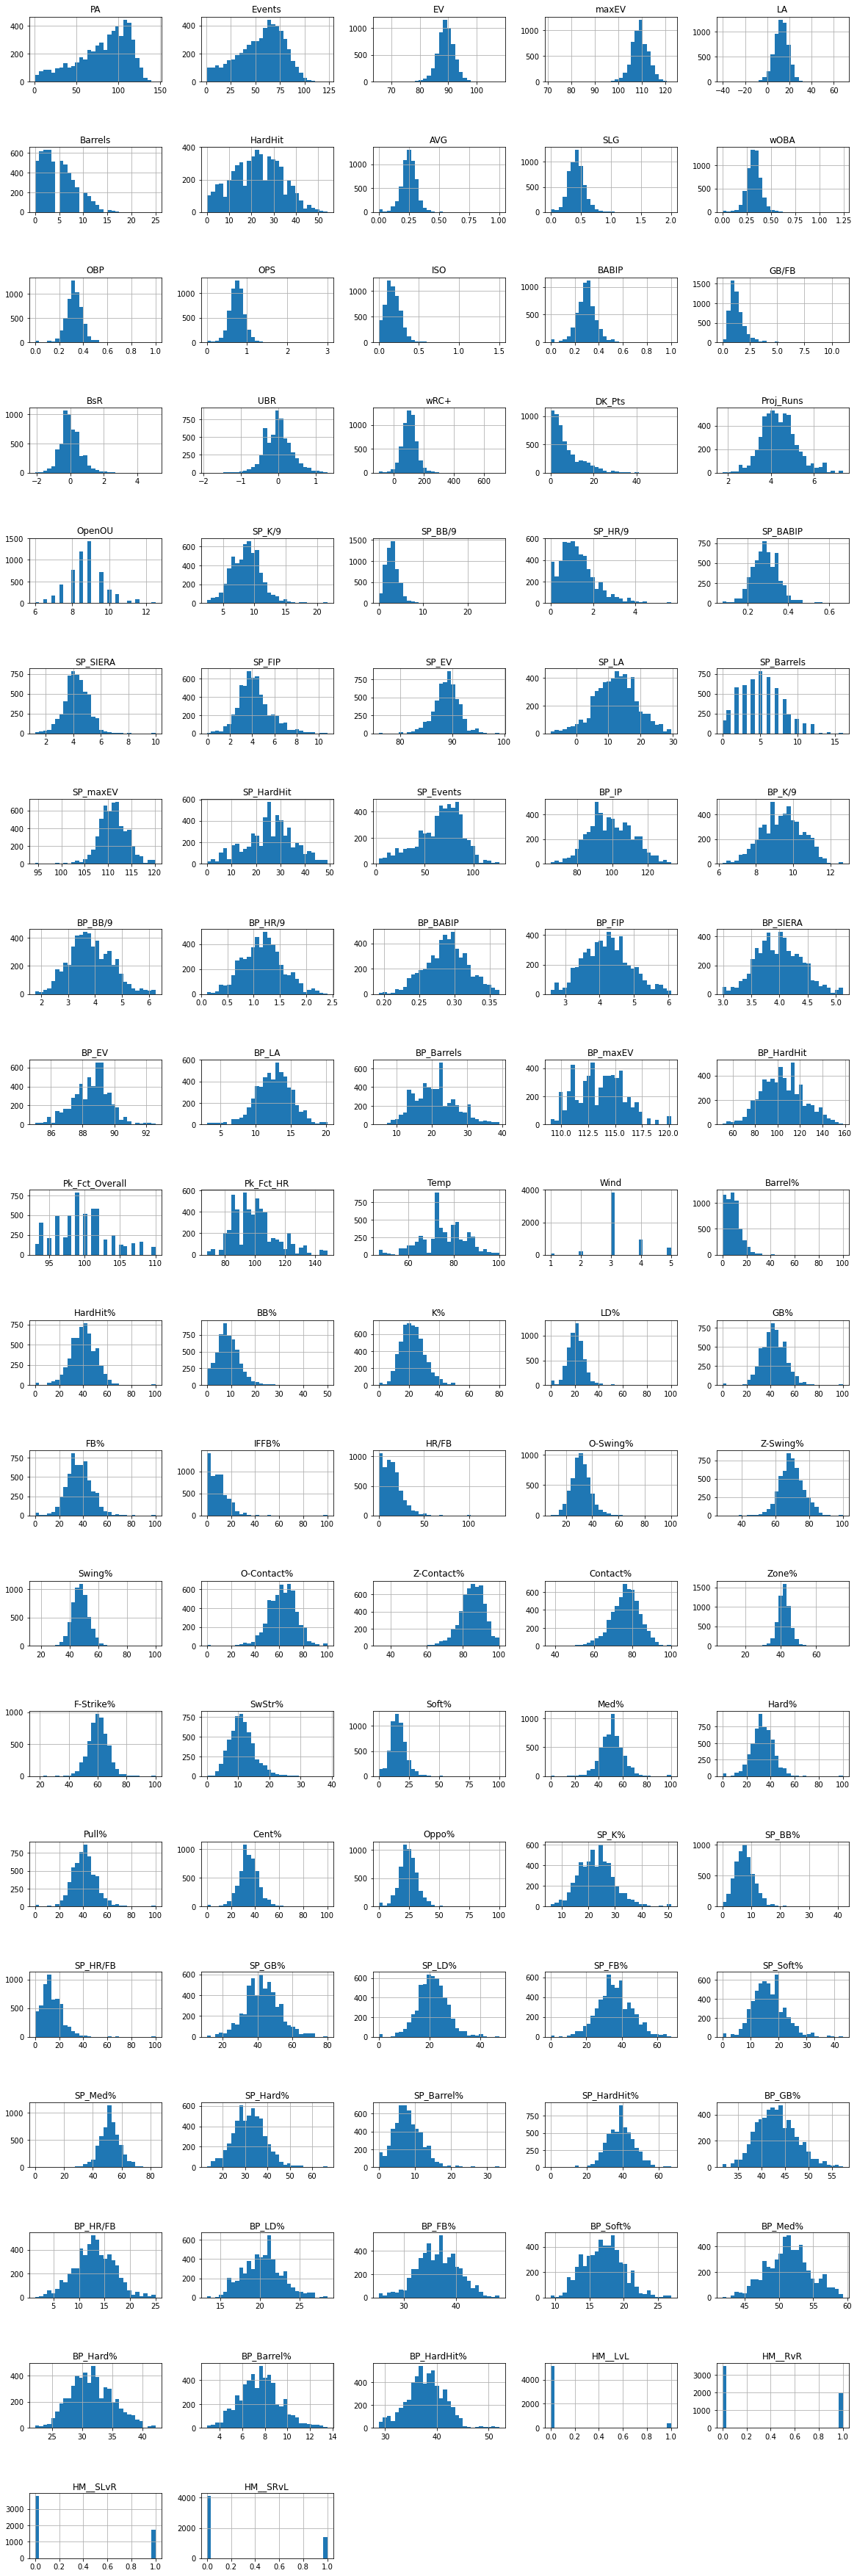

In [267]:
main_df.hist(layout=(25, 5), figsize=(20,80), bins = 30)
plt.subplots_adjust(hspace=1)
plt.show()

In [268]:
main_df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5521 entries, 0 to 5520
Data columns (total 100 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            5521 non-null   datetime64[ns]
 1   Name            5521 non-null   object        
 2   Team            5521 non-null   object        
 3   PA              5521 non-null   float64       
 4   Events          5521 non-null   float64       
 5   EV              5521 non-null   float64       
 6   maxEV           5521 non-null   float64       
 7   LA              5521 non-null   float64       
 8   Barrels         5521 non-null   float64       
 9   HardHit         5521 non-null   float64       
 10  AVG             5521 non-null   float64       
 11  SLG             5521 non-null   float64       
 12  wOBA            5521 non-null   float64       
 13  OBP             5521 non-null   float64       
 14  OPS             5521 non-null   float64       
 15  ISO

<a id='#contents'>Back to Table of Contents<a>

<a id='Correlations'></a>

# Checking correlations

In [269]:
main_df_corr = main_df.corr()

In [270]:
main_df_corr_sorted = main_df_corr.unstack().sort_values(ascending = False)

In [271]:
DK_corr_list = main_df_corr_sorted.loc['DK_Pts']

In [272]:
DK_corr_list

DK_Pts            1.000000
HardHit           0.106452
Barrels           0.103426
PA                0.090010
maxEV             0.084418
EV                0.084361
Proj_Runs         0.083220
HardHit%          0.082481
wOBA              0.080831
OPS               0.079657
wRC+              0.078526
Events            0.076795
SLG               0.074151
OBP               0.073630
Hard%             0.073590
Temp              0.066864
ISO               0.063072
AVG               0.062234
Barrel%           0.059494
Pk_Fct_Overall    0.056810
OpenOU            0.055847
BP_SIERA          0.049895
HR/FB             0.047746
Pk_Fct_HR         0.046245
BsR               0.045140
BP_Hard%          0.045077
BB%               0.044915
BABIP             0.044546
BP_EV             0.042803
BP_FIP            0.041725
BP_HardHit%       0.036596
BP_HardHit        0.035045
SP_EV             0.034384
Z-Swing%          0.034194
SP_BABIP          0.030994
BP_BB/9           0.028269
LA                0.027087
F

In [273]:
features = DK_corr_list[1:]
features

HardHit           0.106452
Barrels           0.103426
PA                0.090010
maxEV             0.084418
EV                0.084361
Proj_Runs         0.083220
HardHit%          0.082481
wOBA              0.080831
OPS               0.079657
wRC+              0.078526
Events            0.076795
SLG               0.074151
OBP               0.073630
Hard%             0.073590
Temp              0.066864
ISO               0.063072
AVG               0.062234
Barrel%           0.059494
Pk_Fct_Overall    0.056810
OpenOU            0.055847
BP_SIERA          0.049895
HR/FB             0.047746
Pk_Fct_HR         0.046245
BsR               0.045140
BP_Hard%          0.045077
BB%               0.044915
BABIP             0.044546
BP_EV             0.042803
BP_FIP            0.041725
BP_HardHit%       0.036596
BP_HardHit        0.035045
SP_EV             0.034384
Z-Swing%          0.034194
SP_BABIP          0.030994
BP_BB/9           0.028269
LA                0.027087
FB%               0.026458
S

In [274]:
features = features.index.to_list()

In [275]:
features

['HardHit',
 'Barrels',
 'PA',
 'maxEV',
 'EV',
 'Proj_Runs',
 'HardHit%',
 'wOBA',
 'OPS',
 'wRC+',
 'Events',
 'SLG',
 'OBP',
 'Hard%',
 'Temp',
 'ISO',
 'AVG',
 'Barrel%',
 'Pk_Fct_Overall',
 'OpenOU',
 'BP_SIERA',
 'HR/FB',
 'Pk_Fct_HR',
 'BsR',
 'BP_Hard%',
 'BB%',
 'BABIP',
 'BP_EV',
 'BP_FIP',
 'BP_HardHit%',
 'BP_HardHit',
 'SP_EV',
 'Z-Swing%',
 'SP_BABIP',
 'BP_BB/9',
 'LA',
 'FB%',
 'SP_SIERA',
 'SP_Hard%',
 'BP_HR/9',
 'HM__SLvR',
 'SP_BB%',
 'SP_BB/9',
 'BP_Barrels',
 'SP_HardHit%',
 'BP_HR/FB',
 'SP_LD%',
 'UBR',
 'BP_LD%',
 'BP_Barrel%',
 'HM__RvR',
 'Oppo%',
 'SP_LA',
 'SP_FIP',
 'Wind',
 'BP_IP',
 'SP_Med%',
 'Contact%',
 'LD%',
 'Pull%',
 'BP_GB%',
 'Z-Contact%',
 'O-Contact%',
 'SP_GB%',
 'SP_K/9',
 'SP_HR/9',
 'SwStr%',
 'BP_BABIP',
 'BP_Med%',
 'SP_FB%',
 'BP_FB%',
 'F-Strike%',
 'Swing%',
 'Cent%',
 'SP_maxEV',
 'BP_LA',
 'K%',
 'SP_Barrel%',
 'SP_K%',
 'SP_HR/FB',
 'SP_HardHit',
 'BP_maxEV',
 'HM__SRvL',
 'IFFB%',
 'O-Swing%',
 'HM__LvL',
 'GB%',
 'SP_Barrels',
 

<a id='Train_Test'></a>

# Train-test split

In [276]:
main_df.shape

(5521, 100)

In [277]:
main_df = main_df.set_index(['Date', 'Team', 'Name'])

In [278]:
cols = list(main_df.columns.values)
print(cols)

['PA', 'Events', 'EV', 'maxEV', 'LA', 'Barrels', 'HardHit', 'AVG', 'SLG', 'wOBA', 'OBP', 'OPS', 'ISO', 'BABIP', 'GB/FB', 'BsR', 'UBR', 'wRC+', 'DK_Pts', 'Proj_Runs', 'OpenOU', 'SP_K/9', 'SP_BB/9', 'SP_HR/9', 'SP_BABIP', 'SP_SIERA', 'SP_FIP', 'SP_EV', 'SP_LA', 'SP_Barrels', 'SP_maxEV', 'SP_HardHit', 'SP_Events', 'BP_IP', 'BP_K/9', 'BP_BB/9', 'BP_HR/9', 'BP_BABIP', 'BP_FIP', 'BP_SIERA', 'BP_EV', 'BP_LA', 'BP_Barrels', 'BP_maxEV', 'BP_HardHit', 'Pk_Fct_Overall', 'Pk_Fct_HR', 'Temp', 'Wind', 'Barrel%', 'HardHit%', 'BB%', 'K%', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%', 'Contact%', 'Zone%', 'F-Strike%', 'SwStr%', 'Soft%', 'Med%', 'Hard%', 'Pull%', 'Cent%', 'Oppo%', 'SP_K%', 'SP_BB%', 'SP_HR/FB', 'SP_GB%', 'SP_LD%', 'SP_FB%', 'SP_Soft%', 'SP_Med%', 'SP_Hard%', 'SP_Barrel%', 'SP_HardHit%', 'BP_GB%', 'BP_HR/FB', 'BP_LD%', 'BP_FB%', 'BP_Soft%', 'BP_Med%', 'BP_Hard%', 'BP_Barrel%', 'BP_HardHit%', 'HM__LvL', 'HM__RvR', 'HM__SLvR', 'HM__SRv

In [279]:
cols.pop(cols.index('DK_Pts'))
main_df = main_df[cols + ['DK_Pts']]

In [280]:
missing = pd.concat([main_df.isnull().sum(), 100 * main_df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

count    %
PA                  0  0.0
HardHit%            0  0.0
Oppo%               0  0.0
Cent%               0  0.0
Pull%               0  0.0
Hard%               0  0.0
Med%                0  0.0
Soft%               0  0.0
SwStr%              0  0.0
F-Strike%           0  0.0
Zone%               0  0.0
Contact%            0  0.0
Z-Contact%          0  0.0
O-Contact%          0  0.0
Swing%              0  0.0
Z-Swing%            0  0.0
O-Swing%            0  0.0
HR/FB               0  0.0
IFFB%               0  0.0
FB%                 0  0.0
GB%                 0  0.0
LD%                 0  0.0
K%                  0  0.0
SP_K%               0  0.0
SP_BB%              0  0.0
SP_HR/FB            0  0.0
BP_FB%              0  0.0
HM__SRvL            0  0.0
HM__SLvR            0  0.0
HM__RvR             0  0.0
HM__LvL             0  0.0
BP_HardHit%         0  0.0
BP_Barrel%          0  0.0
BP_Hard%            0  0.0
BP_Med%             0  0.0
BP_Soft%            0  0.0
BP_LD%              0  0.0
SP_GB%              0  0.0
BP_HR/FB            0  0.0
BP_GB%              0  0.0
SP_HardHit%         0  0.0
SP_Barrel%          0  0.0
SP_Hard%            0  0.0
SP_Med%             0  0.0
SP_Soft%            0  0.0
SP_FB%              0  0.0
SP_LD%              0  0.0
BB%                 0  0.0
Barrel%             0  0.0
Events              0  0.0
Wind                0  0.0
SP_HR/9             0  0.0
SP_BB/9             0  0.0
SP_K/9              0  0.0
OpenOU              0  0.0
Proj_Runs           0  0.0
wRC+                0  0.0
UBR                 0  0.0
BsR                 0  0.0
GB/FB               0  0.0
BABIP               0  0.0
ISO                 0  0.0
OPS                 0  0.0
OBP                 0  0.0
wOBA                0  0.0
SLG                 0  0.0
AVG                 0  0.0
HardHit             0  0.0
Barrels             0  0.0
LA                  0  0.0
maxEV               0  0.0
EV                  0  0.0
SP_BABIP            0  0.0
SP_SIERA            0  0.0
SP_FIP              0  0.0
BP_FIP              0  0.0
Temp                0  0.0
Pk_Fct_HR           0  0.0
Pk_Fct_Overall      0  0.0
BP_HardHit          0  0.0
BP_maxEV            0  0.0
BP_Barrels          0  0.0
BP_LA               0  0.0
BP_EV               0  0.0
BP_SIERA            0  0.0
BP_BABIP            0  0.0
SP_EV               0  0.0
BP_HR/9             0  0.0
BP_BB/9             0  0.0
BP_K/9              0  0.0
BP_IP               0  0.0
SP_Events           0  0.0
SP_HardHit          0  0.0
SP_maxEV            0  0.0
SP_Barrels          0  0.0
SP_LA               0  0.0
DK_Pts              0  0.0

In [281]:
print(all(main_df))

True


In [282]:
#main_df.drop(columns = ['DK_Pts'], inplace = True)
#main_df.shape
# , 'Zone%', 'O-Swing%', 'IFFB%', 'HBP/PA', 'K%', 'Cent%', 'Swing%',\
#                        'F-Strike%', 'SwStr%', 'BP_BABIP', 'Pull%', 'Z-Contact%', 'HBP', 'O-Contact%',\
#                        'Contact%', 'BP_IP', 'Oppo%', 'UBR', '3B/PA', '1B/PA', 'SP_BB%', 'SP_BB/9',\
#                        'BP_BB/9', '2B/PA', 'R/PA', '3B', 'Z-Swing%','BsR', 'BB%', 'BB/PA','SB/PA',\
#                        'H/PA', 'AVG', '1B', 'BB', 'SB', 'R'

In [283]:
main_df.head()

PA  Events    EV  maxEV    LA  Barrels  \
Date       Team Name                                                           
2021-05-01 LAA  Jared Walsh         98.0    68.0  88.1  110.5  11.3      9.0   
           KCR  Andrew Benintendi   94.0    64.0  89.5  103.9  10.8      4.0   
                Salvador Perez     105.0    72.0  92.1  111.9  12.6     10.0   
           TEX  Willie Calhoun      49.0    38.0  89.6  110.6  13.8      2.0   
           DET  Jeimer Candelario  113.0    77.0  87.9  109.6  14.4      4.0   

                                   HardHit    AVG    SLG   wOBA  ...  \
Date       Team Name                                             ...   
2021-05-01 LAA  Jared Walsh           23.0  0.360  0.640  0.445  ...   
           KCR  Andrew Benintendi     24.0  0.250  0.405  0.321  ...   
                Salvador Perez        38.0  0.280  0.530  0.356  ...   
           TEX  Willie Calhoun        16.0  0.333  0.489  0.380  ...   
           DET  Jeimer Candelario     29.0  0.279  0.385  0.317  ...   

                                   BP_Soft%  BP_Med%  BP_Hard%  BP_Barrel%  \
Date       Team Name                                                         
2021-05-01 LAA  Jared Walsh            13.2     54.5      32.3         5.0   
           KCR  Andrew Benintendi      19.0     50.2      30.8        11.3   
                Salvador Perez         19.0     50.2      30.8        11.3   
           TEX  Willie Calhoun         20.0     52.2      27.8         6.1   
           DET  Jeimer Candelario      22.4     53.7      24.0         5.3   

                                   BP_HardHit%  HM__LvL  HM__RvR  HM__SLvR  \
Date       Team Name                                                         
2021-05-01 LAA  Jared Walsh               36.0        0        0         1   
           KCR  Andrew Benintendi         48.4        0        0         1   
                Salvador Perez            48.4        0        1         0   
           TEX  Willie Calhoun            42.4        1        0         0   
           DET  Jeimer Candelario         29.6        0        0         1   

                                   HM__SRvL  DK_Pts  
Date       Team Name                                 
2021-05-01 LAA  Jared Walsh               0      38  
           KCR  Andrew Benintendi         0      33  
                Salvador Perez            0      25  
           TEX  Willie Calhoun            0      26  
           DET  Jeimer Candelario         0      20  

[5 rows x 97 columns]

In [284]:
#main_df.drop(columns = ['Date'], inplace = True)

In [285]:
main_df.shape

(5521, 97)

In [286]:
features = list(main_df.columns[:-1])

In [287]:
len(features)

96

In [288]:
X = main_df[features]
y = main_df['DK_Pts']

In [289]:
y.head()

Date        Team  Name             
2021-05-01  LAA   Jared Walsh          38
            KCR   Andrew Benintendi    33
                  Salvador Perez       25
            TEX   Willie Calhoun       26
            DET   Jeimer Candelario    20
Name: DK_Pts, dtype: int64

In [290]:
X.head()

PA  Events    EV  maxEV    LA  Barrels  \
Date       Team Name                                                           
2021-05-01 LAA  Jared Walsh         98.0    68.0  88.1  110.5  11.3      9.0   
           KCR  Andrew Benintendi   94.0    64.0  89.5  103.9  10.8      4.0   
                Salvador Perez     105.0    72.0  92.1  111.9  12.6     10.0   
           TEX  Willie Calhoun      49.0    38.0  89.6  110.6  13.8      2.0   
           DET  Jeimer Candelario  113.0    77.0  87.9  109.6  14.4      4.0   

                                   HardHit    AVG    SLG   wOBA  ...  BP_FB%  \
Date       Team Name                                             ...           
2021-05-01 LAA  Jared Walsh           23.0  0.360  0.640  0.445  ...    35.0   
           KCR  Andrew Benintendi     24.0  0.250  0.405  0.321  ...    33.6   
                Salvador Perez        38.0  0.280  0.530  0.356  ...    33.6   
           TEX  Willie Calhoun        16.0  0.333  0.489  0.380  ...    33.2   
           DET  Jeimer Candelario     29.0  0.279  0.385  0.317  ...    39.5   

                                   BP_Soft%  BP_Med%  BP_Hard%  BP_Barrel%  \
Date       Team Name                                                         
2021-05-01 LAA  Jared Walsh            13.2     54.5      32.3         5.0   
           KCR  Andrew Benintendi      19.0     50.2      30.8        11.3   
                Salvador Perez         19.0     50.2      30.8        11.3   
           TEX  Willie Calhoun         20.0     52.2      27.8         6.1   
           DET  Jeimer Candelario      22.4     53.7      24.0         5.3   

                                   BP_HardHit%  HM__LvL  HM__RvR  HM__SLvR  \
Date       Team Name                                                         
2021-05-01 LAA  Jared Walsh               36.0        0        0         1   
           KCR  Andrew Benintendi         48.4        0        0         1   
                Salvador Perez            48.4        0        1         0   
           TEX  Willie Calhoun            42.4        1        0         0   
           DET  Jeimer Candelario         29.6        0        0         1   

                                   HM__SRvL  
Date       Team Name                         
2021-05-01 LAA  Jared Walsh               0  
           KCR  Andrew Benintendi         0  
                Salvador Perez            0  
           TEX  Willie Calhoun            0  
           DET  Jeimer Candelario         0  

[5 rows x 96 columns]

In [291]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 44)

In [292]:
y_test.head()

Date        Team  Name            
2021-06-06  TEX   Joey Gallo           6
2021-05-25  TEX   Jose Trevino         0
2021-05-21  NYM   Johneshwy Fargas    15
2021-07-20  ARI   Josh Rojas           9
2021-06-02  MIN   Nick Gordon          5
Name: DK_Pts, dtype: int64

In [293]:
test_players = X_test.index.get_level_values(2).tolist()
test_team = X_test.index.get_level_values(1).tolist()
test_dates = X_test.index.get_level_values(0).tolist()

In [294]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [295]:
X_train = scaler.fit_transform(X_train)

In [296]:
X_test = scaler.transform(X_test)

In [297]:
X_scaled_df = pd.DataFrame(X_train, columns = features)

In [298]:
X_scaled_df.head()

PA    Events        EV     maxEV        LA   Barrels   HardHit  \
0  0.522615  0.845087 -0.969726 -1.029114  0.066057 -1.331385  0.249353   
1  0.359467  0.757472 -0.613149  0.043488 -2.087428 -1.331385 -0.029779   
2  0.555244  0.626049  1.072486  0.880641  1.173564  1.184841  0.807616   
3 -0.913080 -0.469145 -1.164222  0.932963 -1.379854 -0.772223 -0.681086   
4  1.305721  1.283165  1.493895  0.906802  0.758249  0.905261  2.296318   

        AVG       SLG      wOBA  ...    BP_FB%  BP_Soft%   BP_Med%  BP_Hard%  \
0  0.016628 -0.588562 -0.254187  ... -0.146859 -1.668892 -0.795030  2.070513   
1 -0.672209 -1.481566 -1.372005  ... -0.901573  0.643070 -0.638249  0.048840   
2  0.046577  0.128653 -0.215194  ...  1.412882 -1.116782 -0.136551  1.045439   
3  0.346072 -0.117450 -0.150204  ... -0.901573  1.436729  0.177011 -1.346400   
4  0.226274  1.091972  0.928621  ... -0.650002 -0.047068 -0.951811  0.874594   

   BP_Barrel%  BP_HardHit%   HM__LvL   HM__RvR  HM__SLvR  HM__SRvL  
0    1.803815     0.999682 -0.271388  1.321120 -0.671264 -0.587392  
1   -1.639946    -0.161123 -0.271388  1.321120 -0.671264 -0.587392  
2    1.303915     1.054959 -0.271388  1.321120 -0.671264 -0.587392  
3    0.692925     0.502194 -0.271388 -0.756934 -0.671264  1.702441  
4   -0.029154    -0.769163 -0.271388 -0.756934  1.489726 -0.587392  

[5 rows x 96 columns]

In [299]:
X_scaled_df.mean()

PA               -3.470788e-17
Events           -7.114880e-18
EV               -3.543918e-15
maxEV            -1.702174e-15
LA               -2.081534e-16
Barrels           9.816691e-17
HardHit          -1.128727e-16
AVG               3.896105e-16
SLG               2.619181e-16
wOBA             -9.302476e-17
OBP               1.616963e-16
OPS              -2.233955e-16
ISO              -1.348224e-16
BABIP             1.176595e-16
GB/FB            -1.119073e-16
BsR               1.768044e-16
UBR               7.743571e-17
wRC+             -5.936609e-17
Proj_Runs         4.934861e-16
OpenOU            9.359126e-17
SP_K/9           -1.681961e-16
SP_BB/9          -2.038091e-17
SP_HR/9           9.691657e-17
SP_BABIP         -2.740695e-16
SP_SIERA          1.157421e-16
SP_FIP            1.592929e-16
SP_EV             1.076165e-15
SP_LA            -3.298489e-18
SP_Barrels       -6.666165e-16
SP_maxEV          2.157158e-15
SP_HardHit        8.876421e-17
SP_Events        -2.098161e-16
BP_IP   

In [300]:
X_scaled_df.std()

PA                1.000121
Events            1.000121
EV                1.000121
maxEV             1.000121
LA                1.000121
Barrels           1.000121
HardHit           1.000121
AVG               1.000121
SLG               1.000121
wOBA              1.000121
OBP               1.000121
OPS               1.000121
ISO               1.000121
BABIP             1.000121
GB/FB             1.000121
BsR               1.000121
UBR               1.000121
wRC+              1.000121
Proj_Runs         1.000121
OpenOU            1.000121
SP_K/9            1.000121
SP_BB/9           1.000121
SP_HR/9           1.000121
SP_BABIP          1.000121
SP_SIERA          1.000121
SP_FIP            1.000121
SP_EV             1.000121
SP_LA             1.000121
SP_Barrels        1.000121
SP_maxEV          1.000121
SP_HardHit        1.000121
SP_Events         1.000121
BP_IP             1.000121
BP_K/9            1.000121
BP_BB/9           1.000121
BP_HR/9           1.000121
BP_BABIP          1.000121
B

In [301]:
main_df.shape

(5521, 97)

In [302]:
len(X_test)

1381

<a id='Models'></a>

# Models
We'll start with basic, out-of-the-box Linear Regression.

In [303]:
from sklearn.linear_model import LinearRegression

In [304]:
from sklearn.metrics import mean_absolute_error

In [305]:
Baseline_reg = LinearRegression()
Baseline_reg.fit(X_train, y_train)
y_pred = Baseline_reg.predict(X_test)

print(f"Baseline_reg Train R-squared: {Baseline_reg.score(X_train, y_train)}")
print(f"Baseline_reg Test R-squared: {Baseline_reg.score(X_test, y_test)}")
print(f"Baseline_reg MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Baseline_reg RMSE: {mean_squared_error(y_test, y_pred, squared = False)}")
print(f"Baseline_reg MSE: {mean_squared_error(y_test, y_pred)}")

Baseline_reg Train R-squared: 0.04755544130851053
Baseline_reg Test R-squared: 0.021913355860980865
Baseline_reg MAE: 5.676063962532742
Baseline_reg RMSE: 7.6525155125173505
Baseline_reg MSE: 58.56099366931869


In [306]:
Baseline_reg.score(X_train, y_train)

0.04755544130851053

# Function to plot predictions vs. actual values
We'll plot predicted values compared to actual values for each of our models.

In [308]:
def make_hist(model, split, bins):
    fig, ax = plt.subplots(figsize = (12, 8))
    ax.hist(y_test, label = 'Actual DK Points', histtype = 'step', bins = bins)
    ax.hist(y_pred, label = 'Predicted DK Points', histtype = 'step', bins = bins)
    ax.set_title(model + ' ' + split + ' ' + 'Set Results')
    plt.legend()
    plt.show()

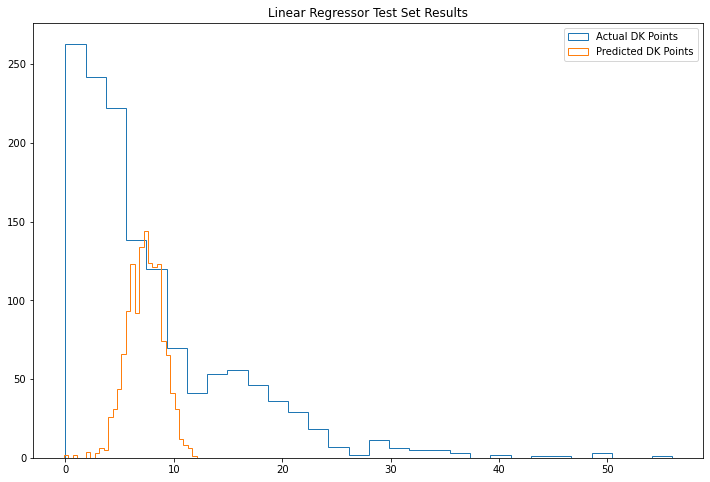

In [309]:
make_hist('Linear Regressor', 'Test', 30)

In [ ]:
make_hist('Linear Regressor', 'Train')

## Lasso regression

In [309]:
from sklearn.linear_model import Lasso

In [310]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': np.arange(0, 1, .01)}
Lasso_mod = Lasso(random_state = 44)
lasso_cv = GridSearchCV(Lasso_mod, param_grid, cv = 5, scoring = 'r2')
lasso_cv.fit(X_train, y_train)
print(f"Best params: {lasso_cv.best_params_}")
print(f"Best score: {lasso_cv.best_score_}")

C:\Users\Owner\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82638.07615557553, tolerance: 17.261649728260867
  model = cd_fast.enet_coordinate_descent(
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

Best params: {'alpha': 0.11}
Best score: 0.014592029774359094


In [311]:
best_lasso = Lasso(alpha = 0.11)
best_lasso.fit(X_train, y_train)
y_pred = best_lasso.predict(X_test)
print(f"best_lasso Train R-squared: {best_lasso.score(X_train, y_train)}")
print(f"best_lasso Test R-squared: {best_lasso.score(X_test, y_test)}")
print(f"best_lasso MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"best_lasso RMSE: {mean_squared_error(y_test, y_pred, squared = False)}")
print(f"best_lasso MSE: {mean_squared_error(y_test, y_pred)}")

best_lasso Train R-squared: 0.03060794640924913
best_lasso Test R-squared: 0.027060420807347052
best_lasso MAE: 5.661033671783055
best_lasso RMSE: 7.632353725195519
best_lasso MSE: 58.252823386505916


In [312]:
best_lasso.score(X_train, y_train)

0.03060794640924913

In [313]:
y_pred.max()

10.181264259216073

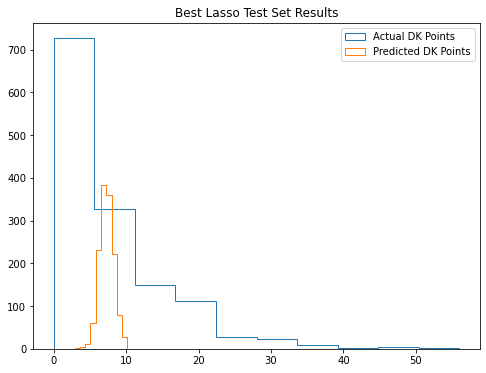

In [314]:
make_hist('Best Lasso', 'Test')

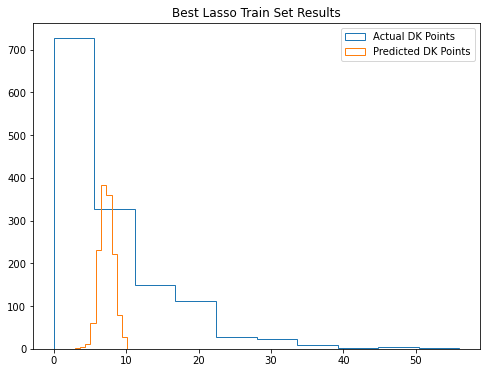

In [315]:
make_hist('Best Lasso', 'Train')

# Random Forest
Let's start with default parameters

In [316]:
from sklearn.ensemble import RandomForestRegressor

In [317]:
Base_rf = RandomForestRegressor(random_state = 44)
Base_rf.fit(X_train, y_train)
y_pred = Base_rf.predict(X_test)
print(f"Base Random Forest Train R-squared: {Base_rf.score(X_train, y_train)}")
print(f"Base Random Forest Test R-squared: {Base_rf.score(X_test, y_test)}")
print(f"Base Random Forest MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Base Random Forest RMSE: {mean_squared_error(y_test, y_pred, squared = False)}")
print(f"Base Random Forest MSE: {mean_squared_error(y_test, y_pred)}")

Base Random Forest Train R-squared: 0.863204503352816
Base Random Forest Test R-squared: 0.05168840423425092
Base Random Forest MAE: 5.681940622737147
Base Random Forest RMSE: 7.535135820408667
Base Random Forest MSE: 56.77827183200579


In [318]:
Base_rf.score(X_train, y_train)

0.863204503352816

In [319]:
y_pred.max()

20.32

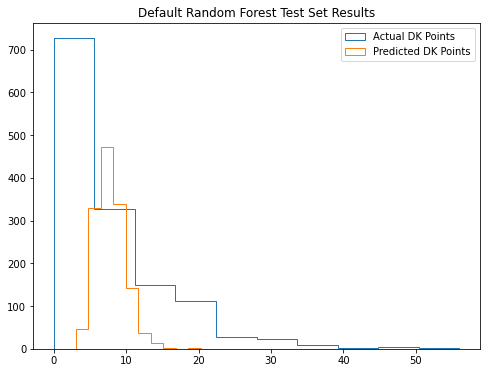

In [320]:
make_hist('Default Random Forest', 'Test')

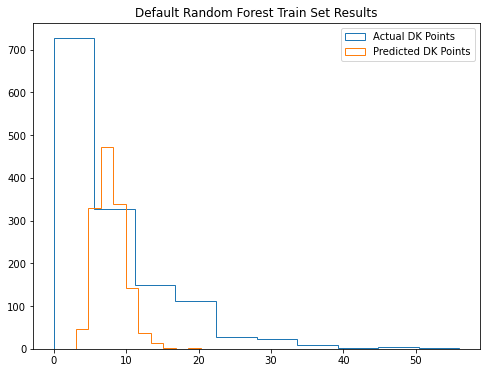

In [321]:
make_hist('Default Random Forest', 'Train')

# Tuned Random Forest
Let's use a Randomized Grid Search.<br>
<br>
**Best estimator:**<br>
RandomForestRegressor(max_depth=9, max_features='sqrt', n_estimators=4800, random_state=44)<br>
**Best score:** -7.072175985605168<br>
**Best params:** {'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 4800}<br>
**Run time:** 459.2389051914215<br>

Commented code below:

In [322]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {'n_estimators': [2400, 3600, 4800], 'max_depth': [3, 6, 9], 'max_features': ['sqrt']}

In [323]:
#from sklearn.model_selection import cross_val_score
# start = time.time()
# rf = RandomForestRegressor(random_state = 44)
# cv_search = GridSearchCV(estimator = rf, param=param_grid, scoring = 'neg_root_mean_squared_error', cv=3,\
#                                n_jobs = 2, verbose = 3)
# cv_search.fit(X_train, y_train)

# print(f"Best estimator: {cv_search.best_estimator_}")
# print(f"Best score: {cv_search.best_score_}")
# print(f"Best params: {cv_search.best_params_}")
# end = time.time()
# print(f"Run time: {end - start}")


# cv_search.fit(X_train, y_train)
# y_pred = cv_search.predict(X_test)
# print(f"Random Forest Test R2 Score: {rf.score(X_test, y_test)}")
# print(f"Random Forest Train R2 Score: {rf.score(X_train, y_train)}")
# print(f"Random Forest MAE: {mean_absolute_error(y_test, y_pred)}")
# print(f"Random Forest RMSE: {mean_squared_error(y_test, y_pred, squared = False)}")
# print(f"Random Forest MSE: {mean_squared_error(y_test, y_pred)}")


In [324]:
best_rf = RandomForestRegressor(max_depth=9, max_features='sqrt', n_estimators=4800, random_state=44)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
print(f"Best Random Forest Train R2 Score: {best_rf.score(X_train, y_train)}")
print(f"Best Random Forest Test R2 Score: {best_rf.score(X_test, y_test)}")
print(f"Best Random Forest MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Best Random Forest RMSE: {mean_squared_error(y_test, y_pred, squared = False)}")
print(f"Best Random Forest MSE: {mean_squared_error(y_test, y_pred)}")

Best Random Forest Train R2 Score: 0.36121924114850656
Best Random Forest Test R2 Score: 0.04678191602420945
Best Random Forest MAE: 5.607980896380161
Best Random Forest RMSE: 7.554603765977863
Best Random Forest MSE: 57.0720380609269


In [325]:
y_pred.max()

14.38429265005629

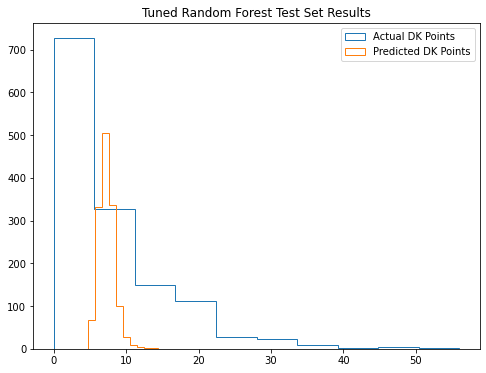

In [326]:
make_hist('Tuned Random Forest', 'Test')

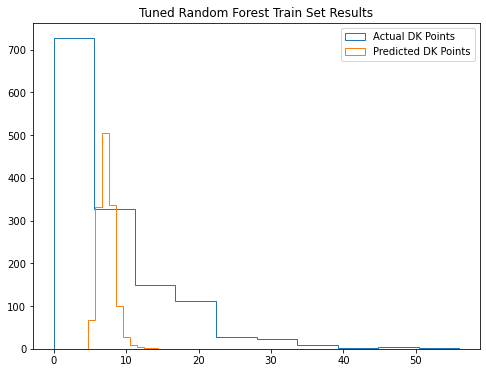

In [327]:
make_hist('Tuned Random Forest', 'Train')

# Gradient Boost
**Best estimator:**<br>
GradientBoostingRegressor(learning_rate=0.01, max_depth=9, max_features='log2', n_estimators=200, random_state=44)<br>
**Best score:** -7.044262980105945<br>
**Best params:** {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 9, 'learning_rate': 0.01}<br>
**Run time:** 1710.9960205554962<br>
<br>
Commented code below:

In [328]:
from sklearn.ensemble import GradientBoostingRegressor


In [329]:
# gb_param_grid = {'n_estimators': [200, 400, 600, 800, 1000], 'learning_rate': [0.01],\
#                 'max_features': ['log2', 'sqrt', 'auto'], 'max_depth': [3, 6, 9]}

In [330]:
# start = time.time()
# gb = GradientBoostingRegressor(random_state = 44)
# rand_cv = RandomizedSearchCV(estimator = gb, param_distributions = gb_param_grid, scoring = 'neg_root_mean_squared_error',\
#                                n_iter = 30, cv = 3, n_jobs = 2, verbose = 3)
# rand_cv.fit(X_train, y_train)

# print(f"Best estimator: {rand_cv.best_estimator_}")
# print(f"Best score: {rand_cv.best_score_}")
# print(f"Best params: {rand_cv.best_params_}")
# # y_pred = gb.predict(X_test)
# # print(f"Gradient Boost R2 Train Score: {gb.score(X_train, y_train)}")
# # print(f"Gradient Boost R2 Test Score: {gb.score(X_test, y_test)}")
# # print(f"Gradient Boost MAE: {mean_absolute_error(y_test, y_pred)}")
# # print(f"Gradient Boost RMSE: {mean_squared_error(y_test, y_pred, squared = False)}")
# # print(f"Gradient Boost MSE: {mean_squared_error(y_test, y_pred)}")
# end = time.time()
# print(f"Run time: {end-start}")

In [331]:
best_gb = GradientBoostingRegressor(learning_rate=0.01, max_features='log2', max_depth = 9, n_estimators=200, random_state=44)
best_gb.fit(X_train, y_train)
y_pred = best_gb.predict(X_test)
print(f"Best Gradient Boost R2 Train Score: {best_gb.score(X_train, y_train)}")
print(f"Best Gradient Boost R2 Test Score: {best_gb.score(X_test, y_test)}")
print(f"Best Gradient Boost MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Best Gradient Boost RMSE: {mean_squared_error(y_test, y_pred, squared = False)}")
print(f"Best Gradient Boost MSE: {mean_squared_error(y_test, y_pred)}")

Best Gradient Boost R2 Train Score: 0.5786612119646487
Best Gradient Boost R2 Test Score: 0.055100035319626595
Best Gradient Boost MAE: 5.586402527762847
Best Gradient Boost RMSE: 7.521569464020647
Best Gradient Boost MSE: 56.57400720208785


In [332]:
y_pred.max()

16.252602510569094

In [333]:
print(np.sort(y_pred)[:25])

[4.11537578 4.506215   4.53248484 4.57874896 4.59033587 4.64151813
 4.65359326 4.65745092 4.65790086 4.65883665 4.66025922 4.70950322
 4.73272435 4.74021809 4.74188336 4.74943051 4.81769556 4.83423239
 4.88640871 4.90448816 4.90561464 4.91617003 4.93046064 4.95754815
 4.95920154]


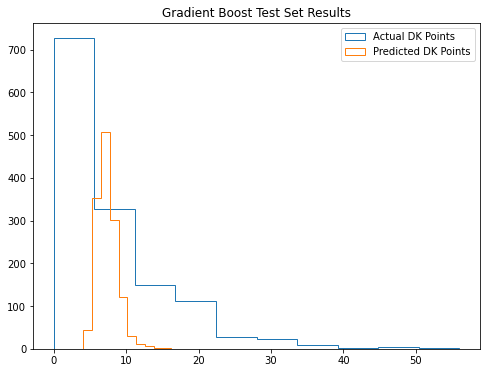

In [334]:
make_hist('Gradient Boost', 'Test')

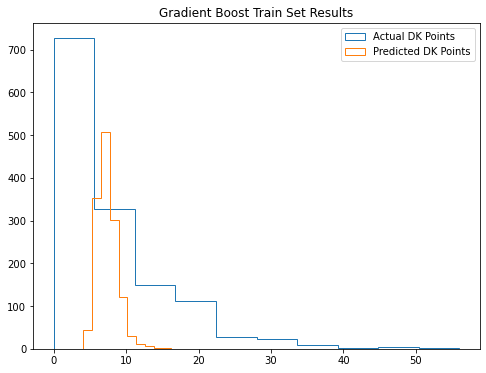

In [335]:
make_hist('Gradient Boost', 'Train')

# Quick recap so far

**Baseline Linear Regressor:**<br>
Baseline_reg Train R-squared: 0.04755544130851053<br>
Baseline_reg R-squared: 0.021913355860980865<br>
Baseline_reg MAE: 5.676063962532742<br>
Baseline_reg RMSE: 7.6525155125173505<br>
Baseline_reg MSE: 58.56099366931869<br>

**Lasso Regression:**<br>
best_lasso Train R-squared: 0.03060794640924913<br>
best_lasso R-squared: 0.027060420807347052<br>
best_lasso MAE: 5.661033671783055<br>
best_lasso RMSE: 7.632353725195519<br>
best_lasso MSE: 58.252823386505916<br>

**Default Random Forest:**<br>
Base Random Forest Train R-squared: 0.863204503352816<br>
Base Random Forest R-squared: 0.05168840423425092<br>
Base Random Forest MAE: 5.681940622737147<br>
Base Random Forest RMSE: 7.535135820408667<br>
Base Random Forest MSE: 56.77827183200579<br>

**Tuned Random Forest:**<br>
Best Random Forest Test R2 Score: 0.04678191602420945<br>
Best Random Forest Train R2 Score: 0.36121924114850656<br>
Best Random Forest MAE: 5.607980896380161<br>
Best Random Forest RMSE: 7.554603765977863<br>
Best Random Forest MSE: 57.0720380609269<br>

**Gradient Boost:**<br>
Best Gradient Boost R2 Train Score: 0.5786612119646487<br>
Best Gradient Boost R2 Test Score: 0.055100035319626595<br>
Best Gradient Boost MAE: 5.586402527762847<br>
Best Gradient Boost RMSE: 7.521569464020647<br>
Best Gradient Boost MSE: 56.57400720208785<br>

<a id='final_model'></a>

# XGBoost
**Best estimator:** XGBRegressor(alpha=15, base_score=0.5, booster='gbtree', colsample_bylevel=1,<br>
             colsample_bynode=1, colsample_bytree=0.06,<br>
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,<br>
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,<br>
             max_depth=9, min_child_weight=1, missing=nan,<br>
             monotone_constraints='()', n_estimators=500, n_jobs=8,<br>
             num_parallel_tree=1, predictor='auto', random_state=44,<br>
             reg_alpha=15, reg_lambda=1, scale_pos_weight=1, subsample=1,<br>
             tree_method='exact', validate_parameters=1, verbosity=None)<br>
**Best score:** -7.012560477101293<br>
**Best params:** {'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.06, 'alpha': 15}<br>
**Run time:** 1380.0610756874084<br>

Commented code below:

In [336]:
from xgboost import XGBRegressor

In [339]:
#from sklearn.model_selection import RandomizedSearchCV

In [340]:
# #dk_dmatrix = xgb.DMatrix(data = X_train, label = y_train)
# alpha_params = [0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
# xgb_params = {'learning_rate': [0.01], 'max_depth': [9],\
#               'n_estimators': [250, 500, 750, 1000], 'colsample_bytree': [0.06], 'alpha': alpha_params}

In [341]:
# start = time.time()
# xgb = XGBRegressor(objective = 'reg:squarederror', random_state = 44)
# rand_cv = GridSearchCV(estimator = xgb, param_grid = xgb_params, scoring = 'neg_root_mean_squared_error',\
#                        cv = 3, n_jobs = 2, verbose = 3)
# rand_cv.fit(X_train, y_train)

# print(f"Best estimator: {rand_cv.best_estimator_}")
# print(f"Best score: {rand_cv.best_score_}")
# print(f"Best params: {rand_cv.best_params_}")
# end = time.time()
# print(f"Run time: {end-start}")
# # start = time.time()
# # for reg in l1_params:
# #     params['alpha'] = reg
# #     cv_results = xgb.cv(dtrain = dk_dmatrix, params = params, nfold = 5, num_boost_round = 12, metrics = 'rmse',\
# #                        as_pandas = True, seed = 77)
# #     rmses_l1.append(cv_results['test-rmse-mean'].tail(1).values[0])
# # print("Best RMSE as a function of l1:")
# # print(pd.DataFrame(list(zip(l1_params, rmses_l1)), columns = ['l1', 'rmse']))
# # start = time.time()
# # print(f"Run time: {end - start} seconds")

In [342]:
best_xgb = XGBRegressor(objective = 'reg:squarederror', reg_alpha = 5, max_depth = 9, n_estimators = 500,\
                            colsample_bytree = 0.06, learning_rate = 0.01, seed = 44)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
print(f"XG Boost R2 Train Score: {best_xgb.score(X_train, y_train)}")
print(f"XG Boost R2 Test Score: {best_xgb.score(X_test, y_test)}")
print(f"XG Boost MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"XG Boost RMSE: {mean_squared_error(y_test, y_pred, squared = False)}")
print(f"XG Boost MSE: {mean_squared_error(y_test, y_pred)}")

XG Boost R2 Train Score: 0.7433917304682094
XG Boost R2 Test Score: 0.06509103360510893
XG Boost MAE: 5.48481725576043
XG Boost RMSE: 7.481698740186611
XG Boost MSE: 55.97581603890993


In [343]:
y_pred.max(), y_pred.min()

(15.29524, 3.0677361)

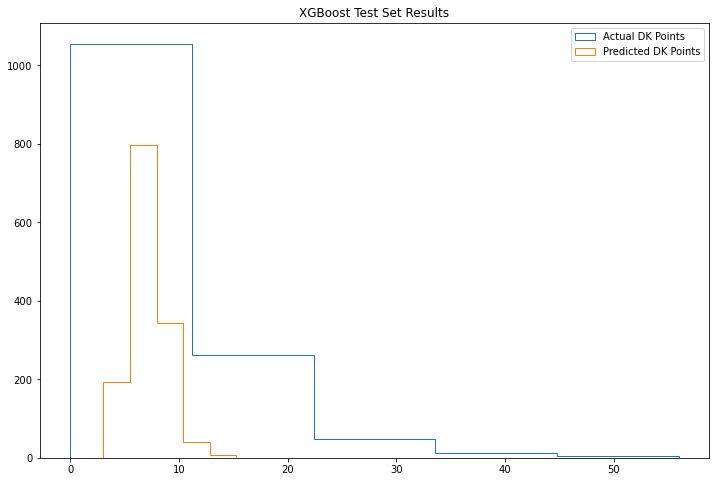

<Figure size 432x288 with 0 Axes>

In [464]:
make_hist('XGBoost', 'Test', 5)
plt.savefig('TestHist_5Bins.png')

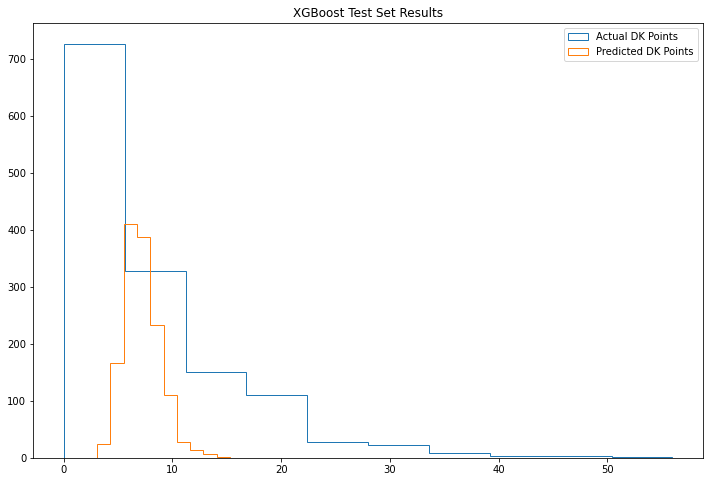

<Figure size 432x288 with 0 Axes>

In [450]:
make_hist('XGBoost', 'Test', 10)
plt.savefig('TestHist_10Bins.png')

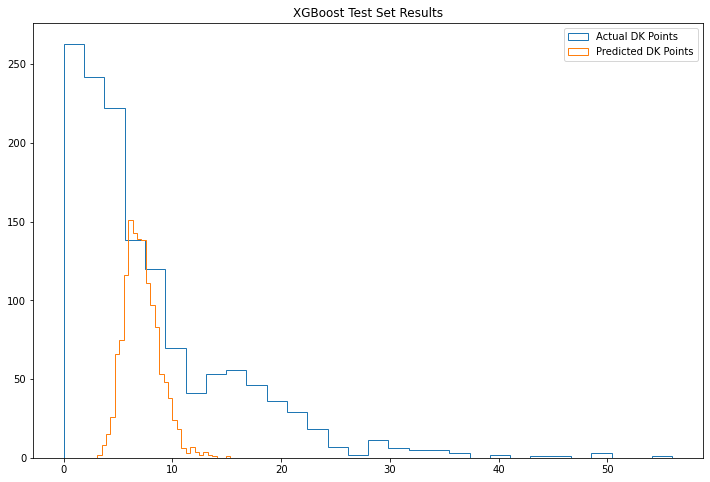

<Figure size 432x288 with 0 Axes>

In [451]:
make_hist('XGBoost', 'Test', 30)
plt.savefig('TestHist_30Bins.pdf')

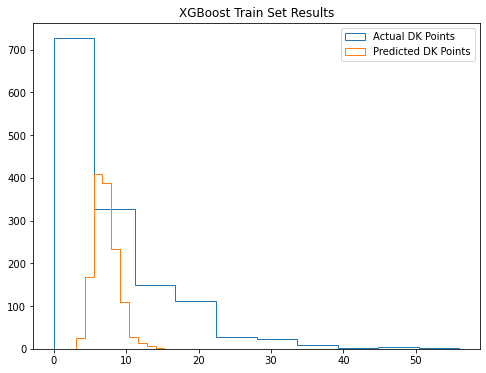

In [345]:
make_hist('XGBoost', 'Train')

In [346]:
y_test.head(10)

Date        Team  Name            
2021-06-06  TEX   Joey Gallo           6
2021-05-25  TEX   Jose Trevino         0
2021-05-21  NYM   Johneshwy Fargas    15
2021-07-20  ARI   Josh Rojas           9
2021-06-02  MIN   Nick Gordon          5
2021-08-17  PHI   Didi Gregorius       3
2021-08-29  CLE   Amed Rosario         5
2021-08-17  SEA   Jake Fraley          0
2021-05-29  SFG   Buster Posey         9
2021-06-18  DET   Eric Haase           0
Name: DK_Pts, dtype: int64

<a href='#contents'>Back to Table of Contents</a>

<a id='Classification Models'></a>

In [347]:
test_df = pd.DataFrame(y_test)

In [348]:
test_df['Pred_DK_Pts'] = y_pred
test_df['Error'] = test_df['Pred_DK_Pts'] - test_df['DK_Pts']

In [349]:
test_df.head()

DK_Pts  Pred_DK_Pts     Error
Date       Team Name                                           
2021-06-06 TEX  Joey Gallo             6     6.462012  0.462012
2021-05-25 TEX  Jose Trevino           0     6.539774  6.539774
2021-05-21 NYM  Johneshwy Fargas      15     5.909397 -9.090603
2021-07-20 ARI  Josh Rojas             9     7.630152 -1.369848
2021-06-02 MIN  Nick Gordon            5     6.473986  1.473986

In [350]:
len(test_df)

1381

In [351]:
test_df.sort_index(level=0, inplace = True)

In [353]:
test_df.head(10)

DK_Pts  Pred_DK_Pts      Error
Date       Team Name                                           
2021-05-01 ARI  Eduardo Escobar       0     8.798412   8.798412
                Josh Rojas           24     7.184348 -16.815652
           BAL  Freddy Galvis         5     7.040551   2.040551
                Pedro Severino        3     6.964675   3.964675
           BOS  Alex Verdugo          7     9.691764   2.691764
                Xander Bogaerts      17     8.535526  -8.464474
           CHC  Ian Happ              8     6.790861  -1.209139
                Javier Baez          10     7.452722  -2.547278
           CHW  Jose Abreu            6     8.992029   2.992029
           CIN  Mike Moustakas        4     6.046857   2.046857

In [354]:
at_least_14 = test_df[test_df['DK_Pts'] >= 14]

In [355]:
len(at_least_14)

285

In [357]:
print(f"{round((len(at_least_14)/len(test_df)) * 100, 2)} percent of players in test set scored at least 14 points")

20.64 percent of players in test set scored at least 14 points


(array([ 4.,  8.,  9.,  9., 17., 20., 18., 21., 30., 20., 19., 24., 15.,
        16., 17.,  7., 12.,  7.,  2.,  0.,  3.,  3.,  1.,  1.,  0.,  0.,
         1.,  0.,  0.,  1.]),
 array([ 4.295791 ,  4.6624393,  5.0290875,  5.395736 ,  5.7623844,
         6.1290326,  6.495681 ,  6.8623295,  7.2289777,  7.595626 ,
         7.962274 ,  8.328922 ,  8.695571 ,  9.06222  ,  9.428867 ,
         9.795516 , 10.162164 , 10.528812 , 10.895461 , 11.262109 ,
        11.628757 , 11.995405 , 12.362054 , 12.728703 , 13.09535  ,
        13.461999 , 13.828648 , 14.195295 , 14.561944 , 14.928592 ,
        15.29524  ], dtype=float32),
 <BarContainer object of 30 artists>)

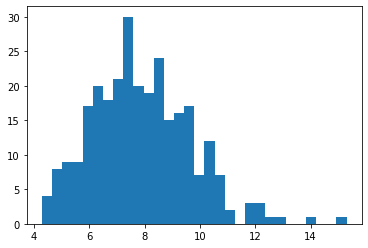

In [358]:
plt.hist(at_least_14['Pred_DK_Pts'], bins = 30)

In [359]:
thresholds = np.arange(4, 16, 0.5)

In [361]:
for threshold in thresholds:
    pred_df_14 = test_df[test_df['Pred_DK_Pts']>= threshold] 
    actual_df_14 = pred_df_14[pred_df_14['DK_Pts'] >= 14]
    pred_df_u14 = test_df[test_df['Pred_DK_Pts'] < threshold]
    missed_14 = pred_df_u14[pred_df_u14['DK_Pts'] >= 14]
    print(f"Predicted {threshold} or more: {len(pred_df_14)}")
    print(f"{len(actual_df_14)} scored 14 or more")
    print(f"{round((len(actual_df_14)/len(pred_df_14)) * 100, 2)} percent of players predicted to score {threshold} scored 14 or more points.")
    print()
    print(f"Predicted {threshold} or less: {len(pred_df_u14)}")
    print(f"{len(missed_14)} scored 14 or more")
    print(f"{round((len(missed_14)/len(pred_df_u14)) * 100, 2)} percent of players predicted to score less than {threshold} scored 14 or more points.")
    print()
    print()

Predicted 4.0 or more: 1370
285 scored 14 or more
20.8 percent of players predicted to score 4.0 scored 14 or more points.

Predicted 4.0 or less: 11
0 scored 14 or more
0.0 percent of players predicted to score less than 4.0 scored 14 or more points.


Predicted 4.5 or more: 1341
282 scored 14 or more
21.03 percent of players predicted to score 4.5 scored 14 or more points.

Predicted 4.5 or less: 40
3 scored 14 or more
7.5 percent of players predicted to score less than 4.5 scored 14 or more points.


Predicted 5.0 or more: 1280
273 scored 14 or more
21.33 percent of players predicted to score 5.0 scored 14 or more points.

Predicted 5.0 or less: 101
12 scored 14 or more
11.88 percent of players predicted to score less than 5.0 scored 14 or more points.


Predicted 5.5 or more: 1192
262 scored 14 or more
21.98 percent of players predicted to score 5.5 scored 14 or more points.

Predicted 5.5 or less: 189
23 scored 14 or more
12.17 percent of players predicted to score less than 5.5 s

ZeroDivisionError: division by zero

In [366]:
print("Players predicted to score 7.5 points or more:")
print(f"514 players, {round((514/1381) * 100, 2)} percent of test set")
print(f"156 scored 14 or more, 30.35 percent of these 'interesting' players")
print(f"That's {round((156/285) * 100, 2)} percent of all players who score 14 or more points.")

Players predicted to score 7.5 points or more:
514 players, 37.22 percent of test set
156 scored 14 or more, 30.35 percent of test set
That's 54.74 percent of all players who score 14 or more points.


In [372]:
print("10-game slate, with 8 batters for 20 teams, 160 available batters")
print(f"{round(160 * .2064)} would score 14 or more points, according to this model.")
print(f"{round(160 * .3722)} would be predicted to score 7.5 or more.")
print(f"Of those 60, {round(60 * .3035)} would score 14 or more.")
print("You would detect 18 and miss 15 of the 14-point scorers")

10-game slate, with 8 batters for 20 teams, 160 available batters
33 would score 14 or more points, according to this model.
60 would be predicted to score 7.5 or more.
Of those 60, 18 would score 14 or more.
You would detect 18 and miss 15 of the 14-point scorers


In [374]:
print("Players predicted to score 7.0 points or more:")
print(f"690 players, {round((690/1381) * 100, 2)} percent of test set")
print(f"193 scored 14 or more, 27.97 percent of these 'interesting' players")
print(f"That's {round((193/285) * 100, 2)} percent of all players who score 14 or more points.")

Players predicted to score 7.0 points or more:
690 players, 49.96 percent of test set
193 scored 14 or more, 27.97 percent of these 'interesting' players
That's 67.72 percent of all players who score 14 or more points.


In [378]:
print("10-game slate, with 8 batters for 20 teams, 160 available batters")
print(f"{round(160 * .2064)} would score 14 or more points, according to this model.")
print(f"{round(160 * .4996)} would be predicted to score 7.0 or more.")
print(f"Of those 80, {round(80 * .2797)} would score 14 or more.")
print("You would detect 22 and miss 11 of the 14-point scorers")

10-game slate, with 8 batters for 20 teams, 160 available batters
33 would score 14 or more points, according to this model.
80 would be predicted to score 7.0 or more.
Of those 80, 22 would score 14 or more.
You would detect 22 and miss 11 of the 14-point scorers


In [379]:
success_df = test_df['DK_Pts'] >= 14
potential_df = test_df['Pred_DK_Pts'] >= 8.5

In [380]:
success_df.head()

Date        Team  Name           
2021-05-01  ARI   Eduardo Escobar    False
                  Josh Rojas          True
            BAL   Freddy Galvis      False
                  Pedro Severino     False
            BOS   Alex Verdugo       False
Name: DK_Pts, dtype: bool

In [381]:
potential_df.head()

Date        Team  Name           
2021-05-01  ARI   Eduardo Escobar     True
                  Josh Rojas         False
            BAL   Freddy Galvis      False
                  Pedro Severino     False
            BOS   Alex Verdugo        True
Name: Pred_DK_Pts, dtype: bool

In [382]:
stacks_df = test_df[success_df | potential_df]

In [383]:
stacks_df.head(25)

DK_Pts  Pred_DK_Pts      Error
Date       Team Name                                              
2021-05-01 ARI  Eduardo Escobar          0     8.798412   8.798412
                Josh Rojas              24     7.184348 -16.815652
           BOS  Alex Verdugo             7     9.691764   2.691764
                Xander Bogaerts         17     8.535526  -8.464474
           CHW  Jose Abreu               6     8.992029   2.992029
           CLE  Jose Ramirez             4     8.515690   4.515690
           COL  Charlie Blackmon        16    11.859218  -4.140782
                Ryan McMahon            18    12.430717  -5.569283
           KCR  Carlos Santana          14    10.711523  -3.288477
                Jorge Soler              2    10.268972   8.268972
           MIL  Jackie Bradley Jr.       0     8.572267   8.572267
                Travis Shaw             21     9.344769 -11.655231
           MIN  Nelson Cruz             16     7.214240  -8.785760
           OAK  Seth Brown               9     8.566194  -0.433806
           PIT  Bryan Reynolds          14     7.379938  -6.620062
           STL  Nolan Arenado           28    10.279466 -17.720534
           TEX  Isiah Kiner-Falefa      29     7.377891 -21.622109
           WSN  Trea Turner             18     9.676949  -8.323051
                Yadiel Hernandez        12     9.619285  -2.380715
2021-05-05 ATL  Dansby Swanson           0     9.453277   9.453277
           BOS  J.D. Martinez           20     8.227271 -11.772729
           CLE  Josh Naylor             21     6.551437 -14.448563
           DET  Victor Reyes             0     8.870542   8.870542
           LAD  Max Muncy               25     5.927926 -19.072074
           MIA  Jesus Aguilar            0     9.939748   9.939748

In [384]:
len(stacks_df)

459

In [385]:
final_model_features = list(main_df.columns)

In [386]:
main_df.columns

Index(['PA', 'Events', 'EV', 'maxEV', 'LA', 'Barrels', 'HardHit', 'AVG', 'SLG',
       'wOBA', 'OBP', 'OPS', 'ISO', 'BABIP', 'GB/FB', 'BsR', 'UBR', 'wRC+',
       'Proj_Runs', 'OpenOU', 'SP_K/9', 'SP_BB/9', 'SP_HR/9', 'SP_BABIP',
       'SP_SIERA', 'SP_FIP', 'SP_EV', 'SP_LA', 'SP_Barrels', 'SP_maxEV',
       'SP_HardHit', 'SP_Events', 'BP_IP', 'BP_K/9', 'BP_BB/9', 'BP_HR/9',
       'BP_BABIP', 'BP_FIP', 'BP_SIERA', 'BP_EV', 'BP_LA', 'BP_Barrels',
       'BP_maxEV', 'BP_HardHit', 'Pk_Fct_Overall', 'Pk_Fct_HR', 'Temp', 'Wind',
       'Barrel%', 'HardHit%', 'BB%', 'K%', 'LD%', 'GB%', 'FB%', 'IFFB%',
       'HR/FB', 'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%',
       'Contact%', 'Zone%', 'F-Strike%', 'SwStr%', 'Soft%', 'Med%', 'Hard%',
       'Pull%', 'Cent%', 'Oppo%', 'SP_K%', 'SP_BB%', 'SP_HR/FB', 'SP_GB%',
       'SP_LD%', 'SP_FB%', 'SP_Soft%', 'SP_Med%', 'SP_Hard%', 'SP_Barrel%',
       'SP_HardHit%', 'BP_GB%', 'BP_HR/FB', 'BP_LD%', 'BP_FB%', 'BP_Soft%',
       'BP_Med

In [453]:
len(final_model_features)

97

In [390]:
param_string = """objective=reg:squarederror, base_score=0.5, booster='gbtree', colsample_bylevel=1,
colsample_bynode=1, enable_categorical=False, gamma=0,
gpu_id=-1, importance_type=None, interaction_constraints='', 
max_delta_step=0, min_child_weight=1, missing=nan,
monotone_constraints='()', n_jobs=8,
num_parallel_tree=1, predictor='auto', random_state=44,
reg_alpha=5, reg_lambda=1, scale_pos_weight=1, subsample=1,
tree_method='exact', validate_parameters=1, verbosity=None
"""

In [391]:
param_list = param_string.split(',')

In [392]:
param_list = [str.replace('\n', '') for str in param_list]

In [393]:
param_list = [str.replace(' ', '') for str in param_list]

In [394]:
param_list

['objective=reg:squarederror',
 'base_score=0.5',
 "booster='gbtree'",
 'colsample_bylevel=1',
 'colsample_bynode=1',
 'enable_categorical=False',
 'gamma=0',
 'gpu_id=-1',
 'importance_type=None',
 "interaction_constraints=''",
 'max_delta_step=0',
 'min_child_weight=1',
 'missing=nan',
 "monotone_constraints='()'",
 'n_jobs=8',
 'num_parallel_tree=1',
 "predictor='auto'",
 'random_state=44',
 'reg_alpha=5',
 'reg_lambda=1',
 'scale_pos_weight=1',
 'subsample=1',
 "tree_method='exact'",
 'validate_parameters=1',
 'verbosity=None']

In [395]:
tuned_param_string = "alpha=5, colsample_bytree=0.06, learning_rate=0.01, max_depth=9, n_estimators=500"

In [396]:
tuned_param_list = tuned_param_string.split(',')
tuned_param_list = [str.replace('\n', '') for str in tuned_param_list]
tuned_param_list = [str.replace(' ', '') for str in tuned_param_list]

In [397]:
tuned_param_list

['alpha=5',
 'colsample_bytree=0.06',
 'learning_rate=0.01',
 'max_depth=9',
 'n_estimators=500']

In [398]:
model_metrics_string = "Best neg_root_mean_squared_error: -7.004106855390056, XG Boost R2 Train Score: 0.7433917304682094, XG Boost R2 Test Score: 0.06509103360510893, XG Boost MAE: 5.48481725576043, XG Boost RMSE: 7.481698740186611, XG Boost MSE: 55.97581603890993"

In [399]:
model_metrics_list = model_metrics_string.split(",")

In [400]:
model_metrics_list

['Best neg_root_mean_squared_error: -7.004106855390056',
 ' XG Boost R2 Train Score: 0.7433917304682094',
 ' XG Boost R2 Test Score: 0.06509103360510893',
 ' XG Boost MAE: 5.48481725576043',
 ' XG Boost RMSE: 7.481698740186611',
 ' XG Boost MSE: 55.97581603890993']

In [401]:
model_metrics_dict = {'Features': final_model_features, 'Paramters': param_list,\
                      'Tuned Parameters': tuned_param_list, 'Metrics': model_metrics_list}

In [403]:
model_metrics_dict = {"Model": ['Linear Regressor', 'Lasso Regression', 'Default Random Forest', 'Tuned Random Forest',\
                                'Gradient Boost', 'XG Boost'], 'Train R2': [0.048, 0.031, 0.086, 0.361, 0.579, 0.743],\
                     'Test R2': [0.022, 0.027, 0.052, 0.047, 0.055, 0.065], 'MAE': [5.676, 5.661, 5.682, 5.608, 5.586, 5.485],\
                     'RMSE': [7.652, 7.632, 7.535, 7.555, 7.522, 7.482]}

In [404]:
model_metrics_df = pd.DataFrame(model_metrics_dict)

In [405]:
model_metrics_df

Model  Train R2  Test R2    MAE   RMSE
0       Linear Regressor     0.048    0.022  5.676  7.652
1       Lasso Regression     0.031    0.027  5.661  7.632
2  Default Random Forest     0.086    0.052  5.682  7.535
3    Tuned Random Forest     0.361    0.047  5.608  7.555
4         Gradient Boost     0.579    0.055  5.586  7.522
5               XG Boost     0.743    0.065  5.485  7.482

In [406]:
model_metrics_df.set_index('Model', inplace = True)

In [407]:
model_metrics_df

Train R2  Test R2    MAE   RMSE
Model                                                 
Linear Regressor          0.048    0.022  5.676  7.652
Lasso Regression          0.031    0.027  5.661  7.632
Default Random Forest     0.086    0.052  5.682  7.535
Tuned Random Forest       0.361    0.047  5.608  7.555
Gradient Boost            0.579    0.055  5.586  7.522
XG Boost                  0.743    0.065  5.485  7.482

In [410]:
labels = list(model_metrics_df.index)

In [411]:
labels

['Linear Regressor',
 'Lasso Regression',
 'Default Random Forest',
 'Tuned Random Forest',
 'Gradient Boost',
 'XG Boost']

In [412]:
MAEs = list(model_metrics_df['MAE'])
RMSEs = list(model_metrics_df['RMSE'])

In [420]:
MAEs

[5.676, 5.661, 5.682, 5.608, 5.586, 5.485]

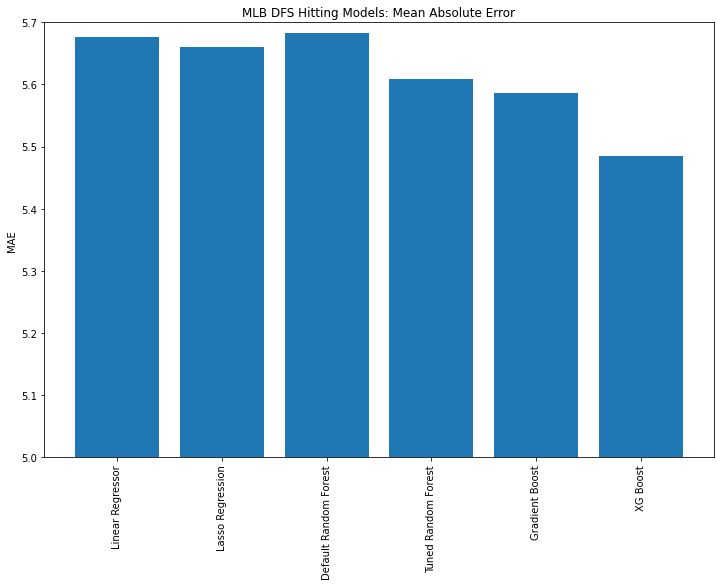

In [468]:
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize = (12,8))
ax.bar(labels, MAEs)

ax.set_ylabel('MAE')
ax.set_title('MLB DFS Hitting Models: Mean Absolute Error')
ax.set_xticks(x)
ax.set_ylim(5, 5.7)
ax.set_xticklabels(labels, rotation=90)
#plt.savefig("MAE_Plot_Margins.png")

plt.show()


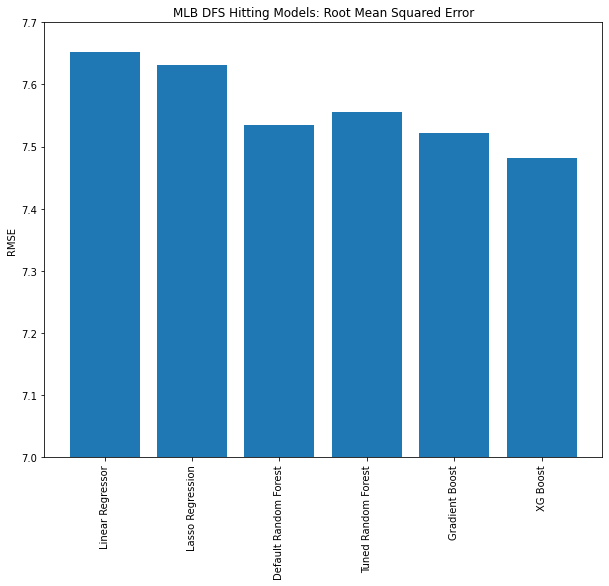

<Figure size 432x288 with 0 Axes>

In [460]:
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize = (8, 6))
ax.bar(labels, RMSEs)

ax.set_ylabel('RMSE')
ax.set_title('MLB DFS Hitting Models: Root Mean Squared Error')
ax.set_xticks(x)
ax.set_ylim(7, 7.7)
ax.set_xticklabels(labels, rotation=90)

plt.show()
plt.savefig("RMSE_Plot.pdf")